In [1]:
import scanpy as sc
import scanpy.external as sce
import muon as mu
import numpy as np
import loompy as lp
import pandas as pd
import anndata as ad
import seaborn as sns
import os
import re
import json
import decoupler as dc
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats
import gseapy

/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/muon/_core/preproc.py:31: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  if Version(scanpy.__version__) < Version("1.10"):


In [2]:
import warnings
# Suppress the specific Pandas fragmentation warning
from pandas.errors import PerformanceWarning
warnings.simplefilter(action='ignore', category=PerformanceWarning)

In [20]:
# Set the default font family to sans-serif
plt.rcParams['font.family'] = 'sans-serif'
# Specify Arial as the font to use for sans-serif
plt.rcParams['font.sans-serif'] = ['Arial']
# Specify defoult of font size 12
plt.rcParams['font.size'] = 14

## Initial Analyses

Load any of the anndata objects that I have created but most specifically the NK anndata object from the transplant data

In [3]:
#CD34_ad = sc.read_h5ad('CD34_ad.h5ad')
#TNC_ad = sc.read_h5ad('TNC_ad.h5ad')
NK_ad = sc.read_h5ad('NK_ad_with_SAVER.h5ad')
#bl_ad = sc.read_h5ad('/users/PAS1800/ruesch6/Single_Cell_Files/Anderson_Blood_NK_RNAseq/Scanpy/singlet_adata.h5ad')
#ts_ad = sc.read_h5ad('/users/PAS1800/ruesch6/Single_Cell_Files/pySCENIC_Analyses/tonsil_ad_v2.h5ad')

In [ ]:
#Create a plot of the reclustered and harmonized NK cells
# 1. Run the plot with show=False to get the axes object
ax = sc.pl.umap(NK_ad, 
                color='Time', 
                size=10,
                #legend_loc='on data', 
                show=False, 
                title='',
                palette='tab10')

# 2. Customize the title and labels
ax.set_title('Reclustered NK Cells', 
             fontname='Arial', 
             fontsize=18)

ax.set_xlabel('UMAP 1', 
              fontname='Arial', 
              fontsize=14)

ax.set_ylabel('UMAP 2', 
              fontname='Arial', 
              fontsize=14)

# 3. Customize the 'on data' legend (which are text annotations)
# We have to loop through all text objects on the plot
legend = ax.legend_
for t in legend.get_texts():
    t.set_fontsize(14)
    t.set_fontname('Arial')

# 4. Show the plot
plt.savefig('figures/NK_reclustered_umap.png', dpi=300, bbox_inches='tight')
plt.show()

Use decoupler to pull out the pyscenic and msigdb data

In [6]:
misg_acts = dc.get_acts(NK_ad, obsm_key='msigdb_aucell')
scenic_acts = dc.get_acts(NK_ad, obsm_key='Pyscenic_AUC')
#print(misg_acts.var_names.unique())
#print(scenic_acts.var_names.unique())

In [7]:
## 1. Define your list of genes
genes_to_add = [
    'EOMES', 'TBX21', 'IKZF3', 'PRDM1', 
    'TCF4', 'TCF7', 'LEF1', 'RUNX2',
    'FOS', 'FOSB', 'JUN', 'JUNB'
]

## 2. Create the new column names with the '_imputed' suffix
new_column_names = [f"{gene}_imputed" for gene in genes_to_add]

## 3. Extract the imputed data from the layer
# First, we slice the NK_ad object to get only the genes we want
imputed_data_slice = NK_ad[:, genes_to_add].layers['saver_log1p']

# 4. Create a new DataFrame with the extracted data
# We use .toarray() in case the layer is stored as a sparse matrix
# The index is set to NK_ad.obs_names to ensure correct cell alignment
imputed_df = pd.DataFrame(
    imputed_data_slice.toarray(),
    index=NK_ad.obs_names,
    columns=new_column_names
)

## 5. Join the new DataFrame with scenic_acts.obs
# The .join() method automatically aligns the data based on the
# cell index (NK_ad.obs_names), adding your new columns.
scenic_acts.obs = scenic_acts.obs.join(imputed_df)

In [10]:
stuff = ['EOMES(+)', 'EOMES_imputed',
        'TBX21(+)', 'TBX21_imputed',
        'IKZF3(+)', 'IKZF3_imputed',
        'PRDM1(+)', 'PRDM1_imputed',
        'TCF4(+)', 'TCF4_imputed',
        'TCF7(+)', 'TCF7_imputed',
        'LEF1(+)', 'LEF1_imputed',
        'RUNX2(+)', 'RUNX2_imputed',
        'FOS(+)', 'FOS_imputed',
        'FOSB(+)', 'FOSB_imputed',
        'JUN(+)', 'JUN_imputed',
         'JUNB(+)', 'JUNB_imputed']
ax = sc.pl.dotplot(scenic_acts, groupby='Time', var_names=stuff, standard_scale='var', cmap='Purples', save='imputation_regulons.png', 
                   return_fig=True, 
                   show=True)
#sc.pl.stacked_violin(scenic_acts, groupby='Time', var_names=stuff, standard_scale='var', cmap='Blues', scale=)
#sc.pl.heatmap(scenic_acts, groupby='Time', var_names=stuff, standard_scale='var' )
#ax.savefig('figures/dotplot_imputation_regulons.png', dpi=300, bbox_inches='tight')


TypeError: 'module' object is not callable

Lets look at EOMES transcript and activity over time in transplant

In [4]:
#Create a new palette for the time point plotting
# --- 1. Define colors ---

# Your category order from the LMM setup
# (This order MUST match adata.obs['Time'].cat.categories)
category_order = ['Donor', 'HC', 'd1', 'd14', 'd21', 'd30', 'd60', 'd90', '>d180']

# Generate the 7-color blue gradient (from light to dark)
# We skip the first 2 colors of the 9-step palette to avoid colors that are too light
color_gradient = list(sns.color_palette("RdPu", 9).as_hex()[2:])

# Create the final color list in the correct order
final_color_list = [
    '#98019F',  # Donor
    '#FEE5E7', # HC
] + color_gradient # The 7 time points

# --- 2. Store the colors in the AnnData object ---
# The key MUST be '[groupby_key]_colors'
NK_ad.uns['Time_colors'] = final_color_list

In [ ]:
sc.pl.violin(NK_ad, groupby='Time', keys='EOMES', layer='saver_log1p', use_raw=False, inner='quart', inner_kws={'color': 'black'})
sc.pl.violin(scenic_acts, groupby='Time', keys='EOMES(+)', inner='quart', inner_kws={'color': 'black'})
sc.pl.violin(NK_ad, groupby='Time', keys='TBX21', layer='saver_log1p', use_raw=False, inner='quart', inner_kws={'color': 'black'})
sc.pl.violin(scenic_acts, groupby='Time', keys='TBX21(+)', inner='quart', inner_kws={'color': 'black'})
sc.pl.violin(NK_ad, groupby='Time', keys='IKZF3', layer='saver_log1p', use_raw=False, inner='quart', inner_kws={'color': 'black'})
sc.pl.violin(scenic_acts, groupby='Time', keys='IKZF3(+)', inner='quart', inner_kws={'color': 'black'})

In [ ]:
sc.pl.violin(misg_acts, groupby='Time', keys='KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY', inner='quart', inner_kws={'color': 'black'})
sc.pl.violin(misg_acts, groupby='Time', keys='GOBP_GRANZYME_MEDIATED_PROGRAMMED_CELL_DEATH_SIGNALING_PATHWAY', inner='quart', inner_kws={'color': 'black'})
sc.pl.violin(misg_acts, groupby='Time', keys='GOBP_CYTOLYSIS', inner='quart', inner_kws={'color': 'black'})

In [ ]:
Genes=['KIR2DL1', 'KIR2DL3', 'KIR2DL4', 'KIR3DL1']
for gene in Genes:
    sc.pl.violin(NK_ad, groupby='Time', keys=gene, use_raw=False, layer='saver_log1p', inner='quart', inner_kws={'color': 'black'}, ylabel=f'{gene} imputed', )
    sc.pl.violin(NK_ad, groupby='Time', keys=gene, use_raw=True, inner='quart', inner_kws={'color': 'black'})

In [ ]:
KIRs=['KIR2DL1', 'KIR2DL3', 'KIR2DL4', 'KIR3DL1', 'KIR3DL2']
sc.pl.dotplot(NK_ad, groupby='Time', var_names=KIRs, use_raw=True)
sc.pl.dotplot(NK_ad, groupby='Time', var_names=KIRs, use_raw=False)
sc.pl.heatmap(NK_ad, groupby='Time', var_names=KIRs, use_raw=False, layer='saver_log1p')

Run a new PCA and UMAP with the SAVER imputed counts that I calculated

In [ ]:
# 1. Create a deep copy of your object for the SAVER analysis
# This prevents overwriting your original work.
NK_ad_saver = NK_ad.copy()

# 2. Set the .X of the new object to your imputed data
# The pipeline (scale, pca) runs on .X by default.
# We assume 'saver_log1p' is your log-normalized SAVER data.
NK_ad_saver.X = NK_ad_saver.layers['saver_log1p'].copy()

# 3. Re-run the standard processing pipeline
print("Finding new Highly Variable Genes on SAVER data...")
sc.pp.highly_variable_genes(NK_ad_saver)

print("Scaling SAVER data...")
sc.pp.scale(NK_ad_saver, max_value=10)

print("Running PCA on SAVER data...")
sc.pp.pca(NK_ad_saver, mask_var="highly_variable")

# Re-run Harmony Integration
#    - It runs on the PCA calculated from the SAVER data (in .obsm['X_pca']).
#    - Use the SAME keys you used before to remove batch/patient effects.
print("Running Harmony on SAVER PCA embedding...")
sce.pp.harmony_integrate(NK_ad_saver,
                         key=['Patient']) # Use your actual column names!

# Harmony creates NK_ad_saver.obsm['X_pca_harmony'] by default.

# 2. Re-compute Neighbors USING the Harmony-corrected embedding
#    - Use the same (smaller) n_pcs you chose for the SAVER PCA elbow plot.
print("Re-computing neighbors on Harmony-corrected embedding...")
sc.pp.neighbors(NK_ad_saver,
                n_pcs=20, # Use the n_pcs you determined from SAVER PCA
                use_rep='X_pca_harmony') # <-- CRITICAL: Use the corrected embedding

# 3. Re-run UMAP
print("Re-running UMAP...")
sc.tl.umap(NK_ad_saver)

# Recalculate leiden clustering
print("Re-running leiden clustering...")
for res in [0.4, 0.6, 0.8, 1.0, 1.2]:
    sc.tl.leiden(NK_ad_saver, 
                  resolution=res, 
                  key_added=f'leiden_res_{res}', 
                  flavor='igraph')

# 4. Plot the NEW, Integrated UMAP
print("Plotting final UMAP...")
sc.pl.umap(
    NK_ad_saver,
    color=['Patient', 'Time', 'leiden_res_0.8'], # Check mixing and original clusters
)

In [ ]:
sc.pl.umap(
    NK_ad_saver, 
    color=['Patient', 'Time'],
)
sc.pl.umap(
    NK_ad,
    color=['Patient', 'Time'],
)

In [ ]:
MTORC1_Regulons = ['NFKB1(+)', 'NFKB2(+)', 'REL(+)', 'RELA(+)', 'RELB(+)', 'SREBF1(+)', 'SREBF2(+)', 'TFEB(+)', 'TFE3(+)', 'ATF4(+)', 'DDIT3(+)', 'NFE2L2(+)', 'NFATC1(+)', 'NFATC2(+)', 'NFATC3(+)']
IL15_Regulons = ['STAT1(+)', 'STAT5A(+)', 'STAT5B(+)', 'PRDM1(+)', 'NFKB1(+)', 'NFKB2(+)', 'REL(+)', 'RELA(+)', 'RELB(+)', 'FOS(+)', 'FOSB(+)', 'FOSL2(+)', 'JUN(+)', 'JUNB(+)', 'JUND(+)']
sc.tl.score_genes(scenic_acts, gene_list=MTORC1_Regulons, use_raw=False, score_name='MTORC1_Regulon_Module')
sc.tl.score_genes(scenic_acts, gene_list=IL15_Regulons, use_raw=False, score_name='IL15_Regulon_Module')
sc.pl.violin(scenic_acts, groupby='Time', keys='MTORC1_Regulon_Module', inner='quart', inner_kws={'color':'black'})
#sc.pl.violin(scenic_acts, groupby='Time', keys='IL15_Regulon_Module', inner='quart', inner_kws={'color':'black'})

## Comparison of Blood, Tonsil, and SCT NK

### Module scoring like figures 2D and S5B

In [4]:
sc.tl.rank_genes_groups(ts_ad, groupby='cell_type', method='wilcoxon', corr_method='benjamini-hochberg', layer='log_counts')
sc.tl.rank_genes_groups(ts_ad, 
                        groupby='leiden',
                        group='28',
                        method='wilcoxon', 
                        corr_method='benjamini-hochberg', 
                        layer='log_counts', 
                        key_added='pNK')
sc.tl.rank_genes_groups(bl_ad, groupby='cell_type', group=['CD56_bright'], reference='CD56_dim', method='wilcoxon', corr_method='benjamini-hochberg', layer='log_counts', key_added = 'CD56_bright')
sc.tl.rank_genes_groups(bl_ad, groupby='cell_type', group=['CD56_dim'], reference='CD56_bright', method='wilcoxon', corr_method='benjamini-hochberg', layer='log_counts', key_added = 'CD56_dim')
sc.tl.rank_genes_groups(bl_ad, groupby='cell_type', group=['Proliferating_NK'], reference='rest', method='wilcoxon', corr_method='benjamini-hochberg', layer='log_counts', key_added = 'Proliferating_NK')

In [5]:
cells = ['Stage3', 'Stage4a', 'Stage4b', 'Stage5', 'pNK', 'CD56_bright', 'CD56_dim', 'Proliferating_NK']
cell_dict = {}
for cell in cells:
    if cell == 'pNK':
        x = sc.get.rank_genes_groups_df(ts_ad, group='28', log2fc_min=0, pval_cutoff=0.05, key=cell)
        genes = x['names'].tolist()[0:50]
        cell_dict[cell] = genes
    elif cell in ['CD56_bright', 'CD56_dim', 'Proliferating_NK']:
        x = sc.get.rank_genes_groups_df(bl_ad, group=cell, log2fc_min=0, pval_cutoff=0.05, key=cell)
        genes = x['names'].tolist()[0:50]
        cell_dict[cell] = genes
    else:
        x = sc.get.rank_genes_groups_df(ts_ad, group=cell, log2fc_min=0, pval_cutoff=0.05)
        genes = x['names'].tolist()[0:50]
        cell_dict[cell] = genes

In [6]:
for cell in cells:
    sc.tl.score_genes(NK_ad, gene_list=cell_dict[cell], score_name=f'{cell}_score')

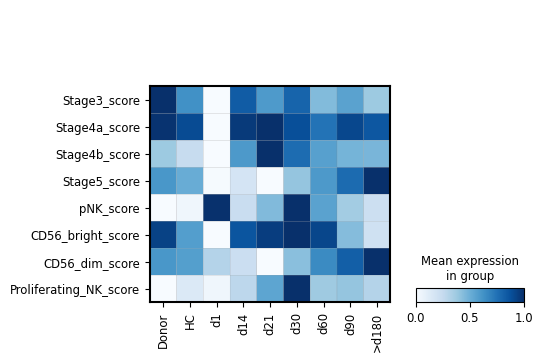

In [8]:
scores = NK_ad.obs.columns.tolist()[21:]
sc.pl.matrixplot(NK_ad, groupby='Time', var_names=scores, standard_scale='var', cmap="Blues", swap_axes=True)
#for s in scores:
#    sc.pl.violin(D28_NK['rna'], groupby='cell_condition', keys=s, inner='quart', inner_kws={'color':'black'}, palette=['#FF0000', '#0000FF', '#FF6666', '#66B2FF'])

Filtering dataset to keep only: PB
Running LMM on PB...
--- Testing Stage3_score ---
--- Testing Stage4a_score ---


/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


--- Testing Stage4b_score ---
--- Testing Stage5_score ---
--- Testing pNK_score ---


/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


--- Testing CD56_bright_score ---
--- Testing CD56_dim_score ---


/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/s

--- Testing Proliferating_NK_score ---


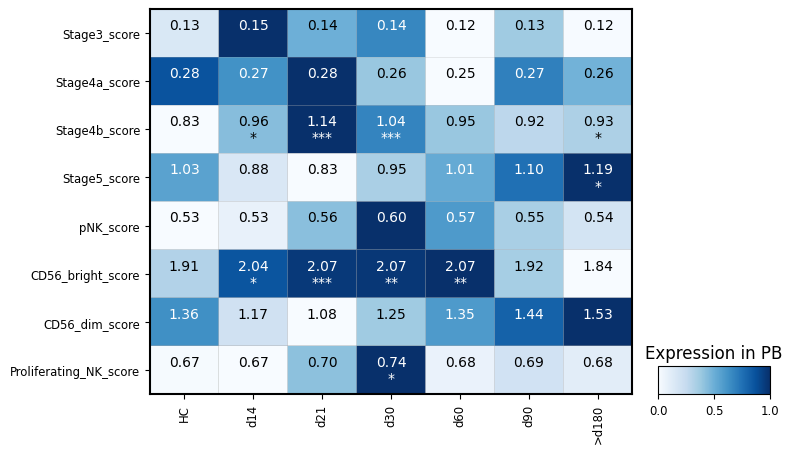

In [37]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

#This configuration is set to look at only Peripheral Blood (PB) cells with HC as the reference since "Donor" cells
# are not from the PB.

# --- 1. Configuration ---
scores = NK_ad.obs.columns.tolist()[21:] 
groupby_key = 'Time'
patient_col = 'Patient' 
ref_group = 'HC'
tissue_col = 'Tissue'  
target_tissue = 'PB'   # Set to 'PB', 'BM', or None

use_fdr_correction = True 

categories_order = [
    'Donor', 'HC', 'd1', 'd14', 'd21', 'd30', 'd60', 'd90', '>d180'
]

# --- 2. Data Setup & Filtering ---
adata_subset = NK_ad.copy()

# A. Tissue Filtering
if target_tissue is not None:
    print(f"Filtering dataset to keep only: {target_tissue}")
    adata_subset = adata_subset[adata_subset.obs[tissue_col] == target_tissue].copy()
    
    # Check if we lost the reference
    if ref_group not in adata_subset.obs[groupby_key].unique():
        print(f"⚠️ CRITICAL WARNING: '{ref_group}' is missing from {target_tissue}!")

# B. THE FIX: Force 'Time' to be an Ordered Category
# This bypasses the bug in sc.pl.matrixplot
# We only keep categories that actually exist in the filtered data to avoid empty-bin errors
existing_cats = [c for c in categories_order if c in adata_subset.obs[groupby_key].unique()]

adata_subset.obs[groupby_key] = pd.Categorical(
    adata_subset.obs[groupby_key],
    categories=existing_cats,
    ordered=True
)

# C. Prepare DataFrames
obs_df = sc.get.obs_df(adata_subset, keys=scores + [groupby_key, patient_col])
mean_df = obs_df.groupby(groupby_key, observed=True)[scores].mean().reindex(existing_cats)
scaled_df = (mean_df - mean_df.min()) / (mean_df.max() - mean_df.min())

# --- 3. Run Single-Cell LMM ---
print(f"Running LMM on {target_tissue if target_tissue else 'All Data'}...")
p_values_df = pd.DataFrame(np.nan, index=mean_df.index, columns=mean_df.columns)
target_groups = [g for g in existing_cats if g != ref_group]

for gene in scores:
    print(f"--- Testing {gene} ---")
    formula = f"Q('{gene}') ~ C({groupby_key}, Treatment('{ref_group}'))"
    
    gene_raw_pvals = []
    gene_group_labels = []
    
    try:
        model = smf.mixedlm(formula, obs_df, groups=obs_df[patient_col])
        result = model.fit()
        
        for group in target_groups:
            term_key = f"C({groupby_key}, Treatment('{ref_group}'))[T.{group}]"
            if term_key in result.pvalues:
                gene_raw_pvals.append(result.pvalues[term_key])
                gene_group_labels.append(group)
        
        if gene_raw_pvals:
            if use_fdr_correction:
                reject, final_pvals, _, _ = multipletests(gene_raw_pvals, method='fdr_bh')
            else:
                final_pvals = gene_raw_pvals
            
            for group, p_val in zip(gene_group_labels, final_pvals):
                p_values_df.loc[group, gene] = p_val
                
    except Exception as e:
        print(f"   Error fitting {gene}: {e}")

# --- 4. Plotting (FIXED) ---
# We REMOVED 'categories_order=...' because adata_subset is now already sorted.
mp = sc.pl.matrixplot(adata_subset, 
                      groupby=groupby_key, 
                      var_names=scores,
                      # categories_order=categories_order,  <-- REMOVED THIS CAUSE OF BUG
                      figsize=(8, 5), 
                      standard_scale='var', 
                      cmap="Blues",
                      swap_axes=True, 
                      return_fig=True)

ax = mp.get_axes()['mainplot_ax']

def get_sig_string(p):
    if pd.isna(p): return ""
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return ""

for y_i, gene in enumerate(scores):
    for x_i, group in enumerate(existing_cats): # Iterate over the actual sorted cats
        
        # Guard against potential mismatch if sorting failed
        if group not in mean_df.index: continue

        real_val = mean_df.loc[group, gene]
        p_val = p_values_df.loc[group, gene]
        bg_val = scaled_df.loc[group, gene]
        
        if pd.isna(real_val): continue
            
        text_color = 'white' if bg_val > 0.5 else 'black'
        sig_str = get_sig_string(p_val)
        display_str = f"{real_val:.2f}\n{sig_str}"
        
        ax.text(x_i + 0.5, y_i + 0.5, display_str,
                ha='center', va='center', color=text_color, fontsize=10)

plt.title(f"Expression in {target_tissue if target_tissue else 'All'}")
plt.show()

Filtering dataset to keep only: BM
Running LMM on BM...
--- Testing Stage3_score ---
--- Testing Stage4a_score ---
--- Testing Stage4b_score ---
--- Testing Stage5_score ---


/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


--- Testing pNK_score ---
--- Testing CD56_bright_score ---
--- Testing CD56_dim_score ---
--- Testing Proliferating_NK_score ---


/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


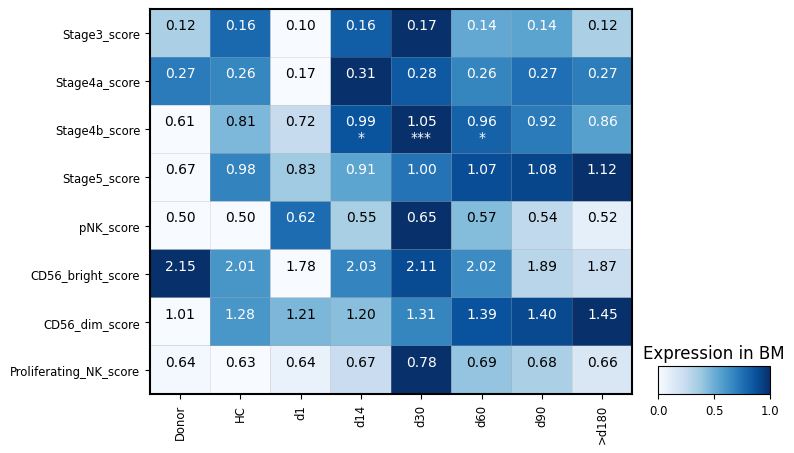

In [36]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

#This configuration is set to look at only BM cells with Donor as the reference

# --- 1. Configuration ---
scores = NK_ad.obs.columns.tolist()[21:] 
groupby_key = 'Time'
patient_col = 'Patient' 
ref_group = 'HC'
tissue_col = 'Tissue'  
target_tissue = 'BM'   # Set to 'PB', 'BM', or None

use_fdr_correction = True 

categories_order = [
    'Donor', 'HC', 'd1', 'd14', 'd21', 'd30', 'd60', 'd90', '>d180'
]

# --- 2. Data Setup & Filtering ---
adata_subset = NK_ad.copy()

# A. Tissue Filtering
if target_tissue is not None:
    print(f"Filtering dataset to keep only: {target_tissue}")
    adata_subset = adata_subset[adata_subset.obs[tissue_col] == target_tissue].copy()
    
    # Check if we lost the reference
    if ref_group not in adata_subset.obs[groupby_key].unique():
        print(f"⚠️ CRITICAL WARNING: '{ref_group}' is missing from {target_tissue}!")

# B. THE FIX: Force 'Time' to be an Ordered Category
# This bypasses the bug in sc.pl.matrixplot
# We only keep categories that actually exist in the filtered data to avoid empty-bin errors
existing_cats = [c for c in categories_order if c in adata_subset.obs[groupby_key].unique()]

adata_subset.obs[groupby_key] = pd.Categorical(
    adata_subset.obs[groupby_key],
    categories=existing_cats,
    ordered=True
)

# C. Prepare DataFrames
obs_df = sc.get.obs_df(adata_subset, keys=scores + [groupby_key, patient_col])
mean_df = obs_df.groupby(groupby_key, observed=True)[scores].mean().reindex(existing_cats)
scaled_df = (mean_df - mean_df.min()) / (mean_df.max() - mean_df.min())

# --- 3. Run Single-Cell LMM ---
print(f"Running LMM on {target_tissue if target_tissue else 'All Data'}...")
p_values_df = pd.DataFrame(np.nan, index=mean_df.index, columns=mean_df.columns)
target_groups = [g for g in existing_cats if g != ref_group]

for gene in scores:
    print(f"--- Testing {gene} ---")
    formula = f"Q('{gene}') ~ C({groupby_key}, Treatment('{ref_group}'))"
    
    gene_raw_pvals = []
    gene_group_labels = []
    
    try:
        model = smf.mixedlm(formula, obs_df, groups=obs_df[patient_col])
        result = model.fit()
        
        for group in target_groups:
            term_key = f"C({groupby_key}, Treatment('{ref_group}'))[T.{group}]"
            if term_key in result.pvalues:
                gene_raw_pvals.append(result.pvalues[term_key])
                gene_group_labels.append(group)
        
        if gene_raw_pvals:
            if use_fdr_correction:
                reject, final_pvals, _, _ = multipletests(gene_raw_pvals, method='fdr_bh')
            else:
                final_pvals = gene_raw_pvals
            
            for group, p_val in zip(gene_group_labels, final_pvals):
                p_values_df.loc[group, gene] = p_val
                
    except Exception as e:
        print(f"   Error fitting {gene}: {e}")

# --- 4. Plotting (FIXED) ---
# We REMOVED 'categories_order=...' because adata_subset is now already sorted.
mp = sc.pl.matrixplot(adata_subset, 
                      groupby=groupby_key, 
                      var_names=scores,
                      # categories_order=categories_order,  <-- REMOVED THIS CAUSE OF BUG
                      figsize=(8, 5), 
                      standard_scale='var', 
                      cmap="Blues",
                      swap_axes=True, 
                      return_fig=True)

ax = mp.get_axes()['mainplot_ax']

def get_sig_string(p):
    if pd.isna(p): return ""
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return ""

for y_i, gene in enumerate(scores):
    for x_i, group in enumerate(existing_cats): # Iterate over the actual sorted cats
        
        # Guard against potential mismatch if sorting failed
        if group not in mean_df.index: continue

        real_val = mean_df.loc[group, gene]
        p_val = p_values_df.loc[group, gene]
        bg_val = scaled_df.loc[group, gene]
        
        if pd.isna(real_val): continue
            
        text_color = 'white' if bg_val > 0.5 else 'black'
        sig_str = get_sig_string(p_val)
        display_str = f"{real_val:.2f}\n{sig_str}"
        
        ax.text(x_i + 0.5, y_i + 0.5, display_str,
                ha='center', va='center', color=text_color, fontsize=10)

plt.title(f"Expression in {target_tissue if target_tissue else 'All'}")
plt.show()

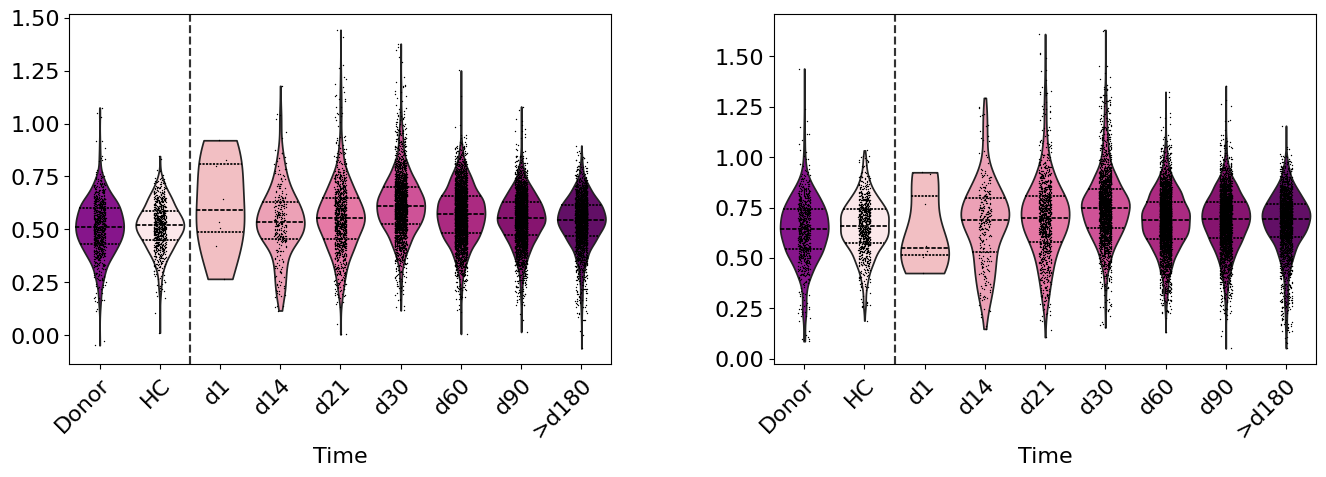

In [9]:
import matplotlib.pyplot as plt

# 1. Call sc.pl.violin with show=False
axes_list = sc.pl.violin(
    NK_ad, 
    groupby='Time', 
    keys=['pNK_score', 'Proliferating_NK_score'], 
    inner='quart', 
    inner_kws={'color':'black'},
    order=category_order,
    show=False  # <-- This is the key change
)

# 2. Loop through each axis in the list
for ax in axes_list:
    # 3. Add a vertical dashed line
    ax.axvline(
        x=1.5,
        color='black',
        linestyle='--',
        linewidth=1.55,
        alpha=0.8
    )

    # 4. NEW: Adjust font sizes
    # Adjust title (what scanpy uses for the y-axis main label)
    ax.set_title(ax.get_title(), fontsize=18)

    # Adjust x-axis label
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)

    # Adjust y-axis label (scanpy leaves this blank, let's add one)
    ax.set_ylabel('', fontsize=16)
    
    # Adjust tick label sizes
    ax.tick_params(axis='x', labelsize=16, rotation=45) # For x-ticks
    ax.tick_params(axis='y', labelsize=16) # For y-ticks
    # This aligns the *right* side of the label to the tick
    plt.setp(
        ax.get_xticklabels(), 
        ha='right',          # Set horizontal alignment to 'right'
        rotation_mode='anchor' # Rotate around the alignment point
    )    

# 5. Now, save and show the final, modified plot
#plt.savefig('figures/Time_Bright_Dim_Violins.png', dpi=300)
plt.show()

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# --- 1. Get the DataFrame from adata.obs ---
# Assuming 'NK_ad' is your AnnData object
# We .copy() to avoid any errors with pandas 'SettingWithCopyWarning'
df = NK_ad.obs.copy()

# --- 2. Select and Rename Columns ---
# We'll select only the columns we need and give them
# simple names for the model formula.
df_analysis = df[['Patient', 'Time', 'li_ad_CD56_bright', 'li_ad_CD56_dim']].rename(columns={
    'Patient': 'PatientID',
    'Time': 'GroupTime',
    'li_ad_CD56_bright': 'Score_Bright',
    'li_ad_CD56_dim': 'Score_Dim'
})

# --- 3. Set Up the 'GroupTime' Categorical Variable ---
# This is the most important step. We need to:
#  a) Define the order of the categories
#  b) Set 'Donor' as the first level, which makes it the reference

# This helper function will let us sort your time points logically
def get_time_sort_key(time_str):
    if time_str == 'Donor': return -2  # Reference group
    if time_str == 'HC': return -1     # Other control group
    if '>' in time_str: return 999    # Puts '>d180' at the very end
    return int(time_str.strip('d')) # Sorts 'd1', 'd14', 'd21' numerically

# Get all unique group/time points from your data
all_group_times = df_analysis['GroupTime'].unique().tolist()

# Sort them using our key
final_category_order = sorted(all_group_times, key=get_time_sort_key)

print(f"Categories will be ordered as: {final_category_order}")

# Now, convert the 'GroupTime' column to a proper categorical type
df_analysis['GroupTime'] = pd.Categorical(
    df_analysis['GroupTime'],
    categories=final_category_order,
    ordered=False # These are distinct groups, not an ordered progression
)

# --- 4. Check Your Work ---
print("\n--- DataFrame ready for analysis: ---")
print(df_analysis.head())

print("\n--- Data types and reference level: ---")
print(df_analysis.info())
# The first category is always the reference
print(f"\nYour reference level is: {df_analysis['GroupTime'].cat.categories[0]}")

# --- 5. Run the LMM for the 'Bright' Score ---
print("\n--- Fitting LMM for Score_Bright ---")

# Formula: "Score_Bright ~ GroupTime" -> Test 'Score_Bright' based on 'GroupTime'
# groups=df_analysis["PatientID"] -> Account for repeated measures from the same patient
lmm_bright = smf.mixedlm("Score_Bright ~ GroupTime", 
                         data=df_analysis, 
                         groups=df_analysis["PatientID"])

result_bright = lmm_bright.fit()
print(result_bright.summary())


# --- 6. Run the LMM for the 'Dim' Score ---
print("\n--- Fitting LMM for Score_Dim ---")

lmm_dim = smf.mixedlm("Score_Dim ~ GroupTime", 
                      data=df_analysis, 
                      groups=df_analysis["PatientID"])

result_dim = lmm_dim.fit()
print(result_dim.summary())

### First Trial

Load in the necessary adata objects

In [ ]:
NK_ad = sc.read_h5ad('NK_ad_with_SAVER.h5ad')
bl_ad = sc.read_h5ad('/users/PAS1800/ruesch6/Single_Cell_Files/Anderson_Blood_NK_RNAseq/Scanpy/singlet_adata.h5ad')
ts_ad = sc.read_h5ad('/users/PAS1800/ruesch6/Single_Cell_Files/pySCENIC_Analyses/tonsil_ad_v2.h5ad')

Combine the Tonsil, Blood and SCT datasets together with the CD56 Bright Cells

In [ ]:
# Subset 1: NK_ad
# Criteria: .obs['Time'] == 'd30' AND .obs['Stage_4b'] >= 1
mask_nk = (NK_ad.obs['Time'] == 'd30') & (NK_ad.obs['li_ad_CD56_bright'] >= 1.25)
NK_ad_subset = NK_ad[mask_nk, :].copy() # .copy() is recommended to avoid View warnings
print(f"\nFound {NK_ad_subset.n_obs} cells from NK_ad")

# Subset 2: ts_ad
# Criteria: .obs['cell_type'] == 'Stage 4b'
mask_ts = ts_ad.obs['cell_type'] == 'Stage4b'
ts_ad_subset = ts_ad[mask_ts, :].copy()
print(f"Found {ts_ad_subset.n_obs} cells from ts_ad")

# Subset 3: bl_ad
# Criteria: .obs['cell_type'] == 'CD56_bright'
mask_bl = bl_ad.obs['cell_type'] == 'CD56_bright'
bl_ad_subset = bl_ad[mask_bl, :].copy()
print(f"Found {bl_ad_subset.n_obs} cells from bl_ad")

In [ ]:
# --- Combine the Subsets ---

# Create a list of the anndata objects to combine
adatas_to_combine = [NK_ad_subset, 
                     ts_ad_subset, 
                     bl_ad_subset]

combined_ad = ad.concat(
    adatas_to_combine,
    join='inner',  # Use 'inner' to keep only shared genes
    label='dataset', # Creates a new .obs column to track cell origin
    keys=['HSCT',
          'Tonsil', 
          'Blood'] # Values for the new column
)

In [ ]:
combined_ad.X = combined_ad.layers['counts'].copy()
sc.pp.normalize_total(combined_ad, target_sum = 10000)
sc.pp.log1p(combined_ad)
combined_ad.layers['log_counts'] = combined_ad.X.copy()
sc.pp.highly_variable_genes(combined_ad)
sc.pp.scale(combined_ad, max_value=10)
combined_ad.layers['scale_counts'] = combined_ad.X.copy()
sc.pp.pca(combined_ad, mask_var="highly_variable")
#sc.pl.pca_variance_ratio(combined_ad, log=True, n_pcs=50) #20 was the magic number this time
sc.pp.neighbors(combined_ad, n_pcs=20)

In [ ]:
for res in [0.4, 0.6, 0.8, 1.0, 1.2]:
    sc.tl.leiden(combined_ad, 
                  resolution=res, 
                  key_added=f'leiden_res_{res}', 
                  flavor='igraph')
sc.tl.umap(combined_ad)

In [ ]:
sc.pl.umap(combined_ad, color='dataset')

In [ ]:
sce.pp.harmony_integrate(combined_ad, 'dataset')

In [ ]:
combined_ad.obsm['X_pca'] = combined_ad.obsm['X_pca_harmony']
sc.pp.neighbors(combined_ad, n_pcs=20)
sc.tl.umap(combined_ad)
for res in [0.4, 0.6, 0.8, 1.0, 1.2]:
    sc.tl.leiden(combined_ad, 
                  resolution=res, 
                  key_added=f'leiden_res_{res}', 
                  flavor='igraph')

In [ ]:
sc.pl.umap(combined_ad, color=['dataset', 'leiden_res_0.4'])

In [ ]:
scenic_acts = dc.get_acts(combined_ad, obsm_key='Pyscenic_AUC')

In [ ]:
#Create module for MTORC1 and IL-15 genesets to compare to each CD56 Bright group
IL15_gene_set_2 = [
    'ABCF2', 'AGK', 'ALG3', 'ANKLE1', 'APOO', 'ARHGAP11A', 'ARL6', 'ARPC4', 
    'ASF1B', 'ATAD2', 'ATAD5', 'ATIC', 'AURKA', 'BIRC5', 'BRCA1', 'BRCC3', 
    'BABAM2', 'BZW2', 'L3HYPDH', 'NOP9', 'ENKD1', 'RUSF1', 'HROB', 'TIMM21', 
    'FAM174C', 'CMSS1', 'C5orf15', 'ARMT1', 'CARNMT1', 'CALU', 'CCNA2', 'CDC123', 
    'CDC25A', 'CDC25C', 'CDC45', 'CDC6', 'CDCA2', 'CDK7', 'CDKN2C', 'CENPF', 
    'CENPJ', 'CETN3', 'CHADL', 'CINP', 'UTP4', 'CIT', 'CKAP2L', 'CLSPN', 
    'COMMD10', 'COPS5', 'CRLS1', 'CRTAP', 'CTR9', 'DDX20', 'DEPDC1B', 'DGCR6', 
    'DKC1', 'DNA2', 'DPAGT1', 'DUS2', 'E2F3', 'E2F8', 'ECE2', 'EIF1AD', 
    'ELAVL1', 'EME1', 'ERRFI1', 'EXOSC2', 'EZH2', 'FAM111A', 'FMR1', 'CMTR1', 
    'GEMIN4', 'GMPR2', 'GOT1', 'ADGRG3', 'GPSM2', 'GRWD1', 'GSTCD', 'HAUS1', 
    'HAUS5', 'HAUS6', 'HAUS7', 'HDAC3', 'HELLS', 'HELQ', 'HNRNPH2', 'HSD17B7', 
    'HSPA14', 'IARS1', 'ILF2', 'IPP', 'PCLAF', 'FAM234B', 'KIF20B', 'KIFC1', 
    'KPNA1', 'LAP3', 'LSM5', 'MAGOHB', 'MASTL', 'MBD4', 'MBNL3', 'MCM3', 
    'MEMO1', 'METAP2', 'METTL14', 'MID1IP1', 'MIS12', 'MOAP1', 'MPHOSPH10', 
    'MRPS18B', 'MTBP', 'MTFP1', 'MTHFD2', 'MVD', 'MYBL2', 'MYCN', 'NANP', 
    'NAT10', 'NBN', 'NCAPG', 'NEK2', 'NFX1', 'NOP2', 'NQO1', 'NUBPL', 'NUSAP1', 
    'OSGIN2', 'PARP2', 'PATL1', 'PCGF6', 'PIM2', 'PKM', 'PLAA', 'PLK4', 
    'PLRG1', 'POLE3', 'POLR3E', 'POLR3G', 'PPAT', 'PPP5C', 'PRKAR2A', 'PRPS1', 
    'PTGER3', 'PUS3', 'RAD1', 'RAD54L', 'RBMX2', 'RCC2', 'RGS16', 'MRM3', 
    'RPP40', 'SAE1', 'SCARB1', 'SEMA6D', 'SLC25A1', 'SLC29A1', 'SLC31A1', 
    'SLC7A5', 'SLC9A2', 'SNX7', 'SOCS1', 'SPRED1', 'STK39', 'SYNCRIP', 
    'TARDBP', 'TBC1D7', 'ALYREF', 'THUMPD2', 'THYN1', 'TIMM10', 'TIMM9', 
    'TM9SF4', 'TMEM101', 'TMEM107', 'TMEM201', 'TMEM39A', 'TMEM97', 'TOP2A', 
    'TP53RK', 'TRIAP1', 'TSPAN4', 'TYMS', 'UAP1', 'UBE2C', 'UBFD1', 'BLTP3A', 
    'UMPS', 'URB1', 'USP5', 'RCC1L', 'WDR4', 'WDR43', 'WDR74', 'WDR89', 
    'WEE1', 'XRCC3', 'ZWILCH', 'ZWINT'
]

hallmark_mtorc1 = [
    'ABCF2', 'ACACA', 'ACLY', 'ACSL3', 'ACTR2', 'ACTR3', 'ADD3', 'ADIPOR2', 
    'AK4', 'ALDOA', 'ARPC5L', 'ASNS', 'ATP2A2', 'ATP5MC1', 'ATP6V1D', 'AURKA', 
    'BCAT1', 'BHLHE40', 'BTG2', 'BUB1', 'CACYBP', 'CALR', 'CANX', 'CCNF', 
    'CCNG1', 'CCT6A', 'CD9', 'CDC25A', 'CDKN1A', 'CFP', 'COPS5', 'CORO1A', 
    'CTH', 'CTSC', 'CXCR4', 'CYB5B', 'CYP51A1', 'DAPP1', 'DDIT3', 'DDIT4', 
    'DDX39A', 'DHCR24', 'DHCR7', 'DHFR', 'EBP', 'EDEM1', 'EEF1E1', 'EGLN3', 
    'EIF2S2', 'ELOVL5', 'ELOVL6', 'ENO1', 'EPRS1', 'ERO1A', 'ETF1', 'FADS1', 
    'FADS2', 'NIBAN1', 'FDXR', 'FGL2', 'FKBP2', 'G6PD', 'GAPDH', 'GBE1', 
    'GCLC', 'GGA2', 'GLA', 'GLRX', 'GMPS', 'GOT1', 'GPI', 'GSK3B', 'GSR', 
    'GTF2H1', 'HK2', 'HMBS', 'HMGCR', 'HMGCS1', 'HPRT1', 'HSP90B1', 'HSPA4', 
    'HSPA5', 'HSPA9', 'HSPD1', 'HSPE1', 'IDH1', 'IDI1', 'IFI30', 'IFRD1', 
    'IGFBP5', 'IMMT', 'INSIG1', 'ITGB2', 'LDHA', 'LDLR', 'LGMN', 'LTA4H', 
    'M6PR', 'MAP2K3', 'MCM2', 'MCM4', 'ME1', 'MLLT11', 'MTHFD2', 'MTHFD2L', 
    'NAMPT', 'NFIL3', 'NFKBIB', 'NFYC', 'NMT1', 'NUFIP1', 'NUP205', 'NUPR1', 
    'P4HA1', 'PDAP1', 'PDK1', 'PFKL', 'PGK1', 'PGM1', 'PHGDH', 'PIK3R3', 
    'PITPNB', 'PLK1', 'PLOD2', 'PNO1', 'PNP', 'POLR3G', 'PPA1', 'PPIA', 
    'PPP1R15A', 'PRDX1', 'PSAT1', 'PSMA3', 'PSMA4', 'PSMB5', 'PSMC2', 'PSMC4', 
    'PSMC6', 'PSMD12', 'PSMD13', 'PSMD14', 'PSME3', 'PSMG1', 'PSPH', 'QDPR', 
    'RAB1A', 'RDH11', 'RIT1', 'RPA1', 'RPN1', 'RRM2', 'RRP9', 'SC5D', 'SCD', 
    'SDF2L1', 'SEC11A', 'SERP1', 'SERPINH1', 'SHMT2', 'SKAP2', 'SLA', 'SLC1A4', 
    'SLC1A5', 'SLC2A1', 'SLC2A3', 'SLC37A4', 'SLC6A6', 'SLC7A11', 'SLC7A5', 
    'NHERF1', 'SORD', 'SQLE', 'SQSTM1', 'SRD5A1', 'SSR1', 'STARD4', 'STC1', 
    'STIP1', 'SYTL2', 'TBK1', 'TCEA1', 'TES', 'TFRC', 'TM7SF2', 'TMEM97', 
    'TOMM40', 'TPI1', 'TRIB3', 'TUBA4A', 'TUBG1', 'TXNRD1', 'UBE2D3', 'UCHL5', 
    'UFM1', 'UNG', 'USO1', 'VLDLR', 'WARS1', 'XBP1', 'YKT6'
]

In [ ]:
sc.tl.score_genes(combined_ad, gene_list=IL15_gene_set_2, score_name='IL15_Gene_Score', layer='log_counts')
sc.tl.score_genes(combined_ad, gene_list=hallmark_mtorc1, score_name='MTORC1_Gene_Score', layer='log_counts')

In [ ]:
sc.pl.violin(combined_ad, groupby='dataset', keys=['IL15_Gene_Score'], inner='quart', inner_kws={'color':'black'})
sc.pl.violin(combined_ad, groupby='dataset', keys=['MTORC1_Gene_Score'], inner='quart', inner_kws={'color':'black'})

In [ ]:
# Ensure 'Time' is categorical for filtering
NK_ad.obs['Time'] = NK_ad.obs['Time'].astype('category')
# Filter to only the groups of interest
conditions_to_compare = ['d30', 'Donor', 'HC']
NK_ad_subset = NK_ad[NK_ad.obs['Time'].isin(conditions_to_compare)].copy()
NK_ad_subset = NK_ad_subset[NK_ad_subset.obs['li_ad_CD56_bright'] >= 1.25].copy()
NK_ad_subset.X = NK_ad_subset.layers['counts'].copy()

# 1. Use your subsetted anndata with ONLY d30 and Donor cells
# (Assuming NK_ad_subset is your filtered, bright-only object)
NK_ad_subset.obs['li_ad_CD56_bright'] = NK_ad_subset.obs['li_ad_CD56_bright'].astype('category')

# 2. Score ONLY this object
sc.tl.score_genes(NK_ad_subset, gene_list=hallmark_mtorc1, score_name='MTORC1_Score')
sc.tl.score_genes(NK_ad_subset, gene_list=IL15_gene_set_2, score_name='IL15_Score')

# 3. Create your FIRST violin plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sc.pl.violin(
    NK_ad_subset, 
    keys='IL15_Score', 
    groupby='Time', 
    show=False, 
    ax=axes[0], 
    inner='quart',
    inner_kws={'color':'black'}
)
sc.pl.violin(
    NK_ad_subset, 
    keys='MTORC1_Score', 
    groupby='Time', 
    show=False, 
    ax=axes[1],
    inner='quart',
    inner_kws={'color':'black'}
)

axes[0].set_title('IL-15 Proliferation (d30 vs Donor)')
axes[1].set_title('MTORC1 Score (d30 vs Donor)')
plt.tight_layout()
plt.show()

In [ ]:
# 1. Load the Li et al. data
# (Assuming li_ad is your bright-filtered object)

# 2. Score ONLY this object
sc.tl.score_genes(li_ad, gene_list=hallmark_mtorc1, score_name='MTORC1_Score')
sc.tl.score_genes(li_ad, gene_list=IL15_gene_set_2, score_name='Prolif_Score')

# 3. Create your SECOND violin plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sc.pl.violin(
    li_ad, 
    keys='Prolif_Score', 
    groupby='tissue', 
    show=False, 
    ax=axes[0],
    inner='quart',
    inner_kws={'color':'black'}
)
sc.pl.violin(
    li_ad, 
    keys='MTORC1_Score', 
    groupby='tissue', 
    show=False, 
    ax=axes[1],
    inner='quart',
    inner_kws={'color':'black'}
)

axes[0].set_title('IL-15 Proliferation (Tonsil vs Blood)')
axes[1].set_title('MTORC1 Score (Tonsil vs Blood)')
plt.tight_layout()
plt.show()

### Second Trial with GSEA method (Need to adjust to only include CD56Bright)

First start by getting ranked gene list for the blood and tonsil NK comparison

In [ ]:
# Subset 1: NK_ad
# Criteria: .obs['Time'] == 'd30' AND .obs['Li_ad_CD56_bright'] >= 1.25
mask_nk = (NK_ad.obs['Time'] == 'd30') & (NK_ad.obs['Li_ad_CD56_bright'] >= 1.25)
NK_ad_subset = NK_ad[mask_nk, :].copy() # .copy() is recommended to avoid View warnings
print(f"\nFound {NK_ad_subset.n_obs} cells from NK_ad")

# Subset 2: ts_ad
# Criteria: .obs['cell_type'] == 'Stage 4b'
mask_ts = ts_ad.obs['cell_type'] == 'Stage4b'
ts_ad_subset = ts_ad[mask_ts, :].copy()
print(f"Found {ts_ad_subset.n_obs} cells from ts_ad")

# Subset 3: bl_ad
# Criteria: .obs['cell_type'] == 'CD56_bright'
mask_bl = bl_ad.obs['cell_type'] == 'CD56_bright'
bl_ad_subset = bl_ad[mask_bl, :].copy()
print(f"Found {bl_ad_subset.n_obs} cells from bl_ad")

In [ ]:
# --- Combine the Subsets ---

# Create a list of the anndata objects to combine
adatas_to_combine = [ts_ad_subset, 
                     bl_ad_subset]

li_ad = ad.concat(
    adatas_to_combine,
    join='inner',  # Use 'inner' to keep only shared genes
    label='tissue', # Creates a new .obs column to track cell origin
    keys=['tonsil', 
          'blood'] # Values for the new column
)

In [ ]:
sc.tl.rank_genes_groups(li_ad, 
                        groupby='tissue', 
                        groups=['tonsil'], 
                        reference='blood', 
                        method='wilcoxon',
                        corr_method='benjamini-hochberg',
                        use_raw=False, 
                        layer='log_counts')

ts_bl_genes = sc.get.rank_genes_groups_df(li_ad, group='tonsil')

Next get the ranked gene list for the Donor to d30 tranplant NK comparison

In [ ]:
# Ensure 'Time' is categorical for filtering
NK_ad.obs['Time'] = NK_ad.obs['Time'].astype('category')
# Filter to only the groups of interest
conditions_to_compare = ['d30', 'Donor']
NK_ad_subset = NK_ad[NK_ad.obs['Time'].isin(conditions_to_compare)].copy()
NK_ad_subset = NK_ad_subset[NK_ad_subset.obs['li_ad_CD56_bright'] >= 1.25].copy()
NK_ad_subset.X = NK_ad_subset.layers['counts'].copy()

In [ ]:
# --- Step 3 (Corrected): Create the Pseudo-bulk Matrices ---

# --- 1. Create the Counts Matrix (counts_df) ---
# We need a DataFrame with cells as rows and genes as columns
# This assumes your raw counts are in NK_ad_subset.X
# If they are in .raw, use: NK_ad_subset.raw.to_adata().X

if scipy.sparse.issparse(NK_ad_subset.X):
    counts_matrix = NK_ad_subset.X.toarray()
else:
    counts_matrix = NK_ad_subset.X

counts_df = pd.DataFrame(
    data=counts_matrix,
    index=NK_ad_subset.obs_names,
    columns=NK_ad_subset.var_names
)

# Add the 'Patient' column to the DataFrame for grouping
counts_df['Patient'] = NK_ad_subset.obs['Patient'].values

# Group by 'Patient' and sum all counts
# This creates the correct (samples, genes) shape
pb_counts_df = counts_df.groupby('Patient').sum()

# Transpose the matrix so genes are rows and samples (patients) are columns
# pb_counts_df = pb_counts_df.T  <--- THIS WAS THE MISTAKE. I've removed it.

# IMPORTANT: pydeseq2 requires INTEGER counts
pb_counts_df = pb_counts_df.astype(int)


# --- 2. Create the Metadata (colData) ---
# We need a metadata table where the rows match the rows of our counts matrix
# The 'Patient' column is our sample ID
# The 'Time' column is our condition
metadata_df = NK_ad_subset.obs[['Patient', 'Time']].drop_duplicates().set_index('Patient')

# Ensure the metadata rows are in the *exact same order* as the counts rows
# FIX: We align to the .index (patients) not the .columns (genes)
metadata_df = metadata_df.loc[pb_counts_df.index]

In [ ]:
# --- Step 4 : Run pydeseq2 ---
inference = DefaultInference(n_cpus=16)

# 1. Initialize the DeseqDataSet (with the new design argument)
dds = DeseqDataSet(
    counts=pb_counts_df,
    metadata=metadata_df,
    refit_cooks=True,
    inference=inference,
    design="~ Time"  # Using the newer 'design' argument instead of 'design_factors'
)

# 2. Run the DESeq2 pipeline
dds.deseq2()

# 3. Get the results
stat_res = DeseqStats(dds, contrast=['Time', 'd30', 'Donor'])

# 4.Get the DataFrame from the .results_df attribute
stat_res.summary()
res_df = stat_res.results_df

# --- Step 5 Get Your Ranked List for GSEA ---

# 6. Now .dropna() will work!
# This correctly removes all genes with 'NaN' (usually from 0 counts)
res_df_cleaned = res_df.dropna()

# 7. Sort the results by the 'stat' column
transplant_gene_list_df = res_df_cleaned.sort_values(by='stat', ascending=False)

print("\nRanked Gene List Head:")
print(ranked_gene_list_df.head())

In [ ]:
IL15_gene_set_2 = [
    'ABCF2', 'AGK', 'ALG3', 'ANKLE1', 'APOO', 'ARHGAP11A', 'ARL6', 'ARPC4', 
    'ASF1B', 'ATAD2', 'ATAD5', 'ATIC', 'AURKA', 'BIRC5', 'BRCA1', 'BRCC3', 
    'BABAM2', 'BZW2', 'L3HYPDH', 'NOP9', 'ENKD1', 'RUSF1', 'HROB', 'TIMM21', 
    'FAM174C', 'CMSS1', 'C5orf15', 'ARMT1', 'CARNMT1', 'CALU', 'CCNA2', 'CDC123', 
    'CDC25A', 'CDC25C', 'CDC45', 'CDC6', 'CDCA2', 'CDK7', 'CDKN2C', 'CENPF', 
    'CENPJ', 'CETN3', 'CHADL', 'CINP', 'UTP4', 'CIT', 'CKAP2L', 'CLSPN', 
    'COMMD10', 'COPS5', 'CRLS1', 'CRTAP', 'CTR9', 'DDX20', 'DEPDC1B', 'DGCR6', 
    'DKC1', 'DNA2', 'DPAGT1', 'DUS2', 'E2F3', 'E2F8', 'ECE2', 'EIF1AD', 
    'ELAVL1', 'EME1', 'ERRFI1', 'EXOSC2', 'EZH2', 'FAM111A', 'FMR1', 'CMTR1', 
    'GEMIN4', 'GMPR2', 'GOT1', 'ADGRG3', 'GPSM2', 'GRWD1', 'GSTCD', 'HAUS1', 
    'HAUS5', 'HAUS6', 'HAUS7', 'HDAC3', 'HELLS', 'HELQ', 'HNRNPH2', 'HSD17B7', 
    'HSPA14', 'IARS1', 'ILF2', 'IPP', 'PCLAF', 'FAM234B', 'KIF20B', 'KIFC1', 
    'KPNA1', 'LAP3', 'LSM5', 'MAGOHB', 'MASTL', 'MBD4', 'MBNL3', 'MCM3', 
    'MEMO1', 'METAP2', 'METTL14', 'MID1IP1', 'MIS12', 'MOAP1', 'MPHOSPH10', 
    'MRPS18B', 'MTBP', 'MTFP1', 'MTHFD2', 'MVD', 'MYBL2', 'MYCN', 'NANP', 
    'NAT10', 'NBN', 'NCAPG', 'NEK2', 'NFX1', 'NOP2', 'NQO1', 'NUBPL', 'NUSAP1', 
    'OSGIN2', 'PARP2', 'PATL1', 'PCGF6', 'PIM2', 'PKM', 'PLAA', 'PLK4', 
    'PLRG1', 'POLE3', 'POLR3E', 'POLR3G', 'PPAT', 'PPP5C', 'PRKAR2A', 'PRPS1', 
    'PTGER3', 'PUS3', 'RAD1', 'RAD54L', 'RBMX2', 'RCC2', 'RGS16', 'MRM3', 
    'RPP40', 'SAE1', 'SCARB1', 'SEMA6D', 'SLC25A1', 'SLC29A1', 'SLC31A1', 
    'SLC7A5', 'SLC9A2', 'SNX7', 'SOCS1', 'SPRED1', 'STK39', 'SYNCRIP', 
    'TARDBP', 'TBC1D7', 'ALYREF', 'THUMPD2', 'THYN1', 'TIMM10', 'TIMM9', 
    'TM9SF4', 'TMEM101', 'TMEM107', 'TMEM201', 'TMEM39A', 'TMEM97', 'TOP2A', 
    'TP53RK', 'TRIAP1', 'TSPAN4', 'TYMS', 'UAP1', 'UBE2C', 'UBFD1', 'BLTP3A', 
    'UMPS', 'URB1', 'USP5', 'RCC1L', 'WDR4', 'WDR43', 'WDR74', 'WDR89', 
    'WEE1', 'XRCC3', 'ZWILCH', 'ZWINT'
]

hallmark_mtorc1 = [
    'ABCF2', 'ACACA', 'ACLY', 'ACSL3', 'ACTR2', 'ACTR3', 'ADD3', 'ADIPOR2', 
    'AK4', 'ALDOA', 'ARPC5L', 'ASNS', 'ATP2A2', 'ATP5MC1', 'ATP6V1D', 'AURKA', 
    'BCAT1', 'BHLHE40', 'BTG2', 'BUB1', 'CACYBP', 'CALR', 'CANX', 'CCNF', 
    'CCNG1', 'CCT6A', 'CD9', 'CDC25A', 'CDKN1A', 'CFP', 'COPS5', 'CORO1A', 
    'CTH', 'CTSC', 'CXCR4', 'CYB5B', 'CYP51A1', 'DAPP1', 'DDIT3', 'DDIT4', 
    'DDX39A', 'DHCR24', 'DHCR7', 'DHFR', 'EBP', 'EDEM1', 'EEF1E1', 'EGLN3', 
    'EIF2S2', 'ELOVL5', 'ELOVL6', 'ENO1', 'EPRS1', 'ERO1A', 'ETF1', 'FADS1', 
    'FADS2', 'NIBAN1', 'FDXR', 'FGL2', 'FKBP2', 'G6PD', 'GAPDH', 'GBE1', 
    'GCLC', 'GGA2', 'GLA', 'GLRX', 'GMPS', 'GOT1', 'GPI', 'GSK3B', 'GSR', 
    'GTF2H1', 'HK2', 'HMBS', 'HMGCR', 'HMGCS1', 'HPRT1', 'HSP90B1', 'HSPA4', 
    'HSPA5', 'HSPA9', 'HSPD1', 'HSPE1', 'IDH1', 'IDI1', 'IFI30', 'IFRD1', 
    'IGFBP5', 'IMMT', 'INSIG1', 'ITGB2', 'LDHA', 'LDLR', 'LGMN', 'LTA4H', 
    'M6PR', 'MAP2K3', 'MCM2', 'MCM4', 'ME1', 'MLLT11', 'MTHFD2', 'MTHFD2L', 
    'NAMPT', 'NFIL3', 'NFKBIB', 'NFYC', 'NMT1', 'NUFIP1', 'NUP205', 'NUPR1', 
    'P4HA1', 'PDAP1', 'PDK1', 'PFKL', 'PGK1', 'PGM1', 'PHGDH', 'PIK3R3', 
    'PITPNB', 'PLK1', 'PLOD2', 'PNO1', 'PNP', 'POLR3G', 'PPA1', 'PPIA', 
    'PPP1R15A', 'PRDX1', 'PSAT1', 'PSMA3', 'PSMA4', 'PSMB5', 'PSMC2', 'PSMC4', 
    'PSMC6', 'PSMD12', 'PSMD13', 'PSMD14', 'PSME3', 'PSMG1', 'PSPH', 'QDPR', 
    'RAB1A', 'RDH11', 'RIT1', 'RPA1', 'RPN1', 'RRM2', 'RRP9', 'SC5D', 'SCD', 
    'SDF2L1', 'SEC11A', 'SERP1', 'SERPINH1', 'SHMT2', 'SKAP2', 'SLA', 'SLC1A4', 
    'SLC1A5', 'SLC2A1', 'SLC2A3', 'SLC37A4', 'SLC6A6', 'SLC7A11', 'SLC7A5', 
    'NHERF1', 'SORD', 'SQLE', 'SQSTM1', 'SRD5A1', 'SSR1', 'STARD4', 'STC1', 
    'STIP1', 'SYTL2', 'TBK1', 'TCEA1', 'TES', 'TFRC', 'TM7SF2', 'TMEM97', 
    'TOMM40', 'TPI1', 'TRIB3', 'TUBA4A', 'TUBG1', 'TXNRD1', 'UBE2D3', 'UCHL5', 
    'UFM1', 'UNG', 'USO1', 'VLDLR', 'WARS1', 'XBP1', 'YKT6'
]

# --- 1. The full TRM4 list you provided ---
# (I've removed the empty/blank gene names)
trm4_full_list = [
    'ADAM8', 'ADAM9', 'ADGRG1', 'ADGRG3', 'AHR', 'ALDH2', 'ALOX5AP', 'ANXA1', 'ANXA2', 
    'ANXA4', 'ANXA5', 'APOBEC1', 'APOE', 'ARHGAP11A', 'ARRDC3', 'ATF3', 'ATP6V0A1', 
    'BLNK', 'BMP2K', 'BTK', 'C1QB', 'C1QC', 'CAPG', 'KNL1', 'CCDC88A', 'CCL3', 
    'CCNB1', 'CCNB2', 'CCR1', 'CCR8', 'CD14', 'CD24', 'CD44', 'CD63', 'CD69', 'CD74', 
    'CD80', 'CD81', 'CDKN2C', 'CENPH', 'CEP85L', 'CKS1B', 'CLEC12A', 'CPD', 'CREG1', 
    'CSF1', 'CSF1R', 'CSRNP1', 'CTNNA1', 'CTSH', 'CTSS', 'CXCL10', 'CXCL16', 'CXCL2', 
    'CYBB', 'CYFIP1', 'DAPK1', 'DENND5A', 'DUSP1', 'DUSP4', 'DUSP6', 'EGR1', 'EGR2', 
    'ELL2', 'FABP5', 'FCER1G', 'FGL2', 'FOS', 'GADD45B', 'GAS2L3', 'GAS7', 'GCNT1', 
    'GEM', 'GPR141', 'GPX1', 'GRN', 'GSTK1', 'GSTM5', 'H1-0', 'HAVCR2', 'HHEX', 
    'H1-2', 'H2BC4', 'H2BC14', 'H2BP2', 'HSPA13', 'HSPA1A', 'IER2', 'IFI30', 'IFITM1', 
    'IFITM2', 'IFITM3', 'IFNGR2', 'IL2RA', 'IRF4', 'IRF8', 'ITGA1', 'ITGAE', 'ITSN1', 
    'JUN', 'KIF11', 'KIF15', 'KIF23', 'KLF4', 'LAMP2', 'LAT2', 'LGALS3', 'LGMN', 
    'LITAF', 'LMNA', 'LPCAT2', 'LY86', 'MAF', 'MAP4K5', 'MARCKS', 'MARCKSL1', 
    'MKI67', 'MPEG1', 'MRC1', 'MYADM', 'MYO1E', 'MYO5A', 'MYO9A', 'NAAA', 'NCAPD2', 
    'NCAPG2', 'NEK6', 'NFAM1', 'NFIL3', 'NFKBIA', 'NFKBID', 'NR4A1', 'NR4A2', 
    'NR4A3', 'NUCB2', 'NUSAP1', 'ODC1', 'P2RY14', 'PF4', 'PHACTR2', 'PHLDA1', 
    'PLCG2', 'PLK1', 'PMAIP1', 'PNP', 'PPP1R15A', 'PRIM1', 'PRKAR2B', 'PRNP', 
    'PRR11', 'PSTPIP2', 'PTPRE', 'PYGL', 'QPCT', 'RAB31', 'RASGEF1B', 'RASSF4', 
    'RFC3', 'RFC4', 'RGS1', 'RGS16', 'RGS18', 'RGS2', 'RHOB', 'RNASE6', 'RNF149', 
    'RNY3', 'RRM2', 'SAT1', 'SEMA6D', 'SHCBP1', 'SIK1', 'SKIL', 'SLC41A2', 'SNX9', 
    'SPC24', 'SPI1', 'ST3GAL5', 'ST6GAL1', 'STMN1', 'STOM', 'STX7', 'STYK1', 
    'SWAP70', 'SYK', 'TACC3', 'TBC1D8', 'TGFBR3', 'TIFA', 'TJP1', 'TMEM176B', 
    'TNF', 'TNFAIP3', 'TNFRSF9', 'TNFSF9', 'TOP2A', 'TRIB1', 'TXN', 'UHRF1', 'VDR', 
    'WDFY4', 'ZCCHC24', 'ZFP36'
]

# --- 2. Define the "bad" confounding genes ---
# (I pulled these from the list above)
proliferation_genes = [
    'CCNB1', 'CCNB2', 'CENPH', 'CKS1B', 'KIF11', 'KIF15', 'KIF23', 'MKI67', 
    'NCAPD2', 'NCAPG2', 'NEK6', 'NUSAP1', 'PLK1', 'PRIM1', 'PRR11', 'RFC3', 
    'RFC4', 'RRM2', 'SHCBP1', 'SPC24', 'STMN1', 'TACC3', 'TOP2A', 'UHRF1'
]

myeloid_genes = [
    'ALOX5AP', 'C1QB', 'C1QC', 'CD14', 'CD63', 'CD74', 'CSF1', 'CSF1R', 'CTSS', 
    'CYBB', 'FCER1G', 'IFI30', 'IRF8', 'LGALS3', 'LITAF', 'MPEG1', 'MRC1', 
    'PSTPIP2', 'SPI1', 'SYK', 'SWAP70'
]

# --- 3. Create the new, "cleaned" signature ---
cleaned_trm_signature = list(
    set(trm4_full_list) - set(proliferation_genes) - set(myeloid_genes)
)

core_nk_additions = [
    'ZNF683',  # HOBIT
    'XCL1',
    'CD160',
    'GZMK',
    'PRDM1'    # BLIMP1
]

final_hybrid_residency_sig = list(
    set(cleaned_trm_signature) | set(core_nk_additions)
)

#Just in case I need it (Self made list rather than based from a published gene set)
# I should validate this with caprice and see what she thinks
core_residency_sig = [
    'CD69',    # The classic marker for tissue retention
    'CXCR6',   # Chemokine receptor for lymphoid/liver
    'ITGAE',   # CD103, epithelial homing
    'ITGA1',   # CD49a, stromal homing
    'ZNF683',  # HOBIT (key transcription factor)
    'PRDM1',   # BLIMP1 (key transcription factor)
    'GZMK',    # Granzyme K (often high in resident cells)
    'CD160',   # Marker
    'RGS1',    # Regulator of G protein signaling (prevents egress)
    'KLRC1',   # NKG2A (often high on resident/immature cells)
    'XCL1',    # Chemokine
    'XCL2'     # Chemokine
]

print(f"IL-15 signature list size: {len(IL15_gene_set_2)}")
print(f"mTOR signature list size: {len(hallmark_mtorc1)}")
print(f"Cleaned T-cell list size: {len(cleaned_trm_signature)}")
print(f"Core NK additions: {len(core_nk_additions)}")
print(f"Final hybrid signature size: {len(final_hybrid_residency_sig)}")
print(f"Core tissue residency signature size: {len(core_residency_sig)}")

In [ ]:
# Create the master gene set dictionary
gene_set_dict = {
    '1_IL15_Prolif_Sig': IL15_gene_set_2,
    '2_Hybrid_Residency_Sig': final_hybrid_residency_sig,
    '3_mTOR_Sig': hallmark_mtorc1
}

# Get the list of gene set names in the order we want
geneset_names_ordered = sorted(gene_set_dict.keys())

In [ ]:
# We assume 'transplant_gene_list_df' has genes as the index and a 'stat' column
rank_list_transplant = transplant_gene_list_df['stat'].sort_values(ascending=False)
rank_list_transplant = rank_list_transplant.dropna() # Remove any NaN genes

# Convert tonsil and blood to the required Series format (Index = gene, Value = score)
rank_list_tonsil = ts_bl_genes.set_index('names')['scores'].sort_values(ascending=False)
rank_list_tonsil = rank_list_tonsil.dropna()

In [ ]:
# (Assuming your ranked_lists_to_run and phenotype_labels dicts are defined)
ranked_lists_to_run = {
    'd30_vs_Donor': rank_list_transplant,
    'Tonsil_vs_Blood': rank_list_tonsil
}

# We will save filenames in the 2x3 order
filename_grid = [[None, None, None], [None, None, None]] # 2x3 grid

print("Starting GSEA plot generation...")

for i, (list_name, rnk_list) in enumerate(ranked_lists_to_run.items()):
    
    labels = phenotype_labels[list_name]
    
    for j, set_name in enumerate(geneset_names_ordered):
        
        current_gene_set = {set_name: gene_set_dict[set_name]}

        pr_result = gseapy.prerank(
            rnk=rnk_list,
            gene_sets=current_gene_set,
            min_size=10, 
            seed=42
        )
        
        result_key = list(pr_result.results.keys())[0]

        # --- THIS IS THE NEW LOGIC ---
        # 1. Call gseaplot, which returns a LIST of axes
        gseaplot_return_list = gseapy.gseaplot(
            rank_metric=rnk_list, 
            term=result_key,
            **pr_result.results[result_key],
            legend_loc='upper right'
        )
        
        # 2. Get the actual axis object *from* the list
        ax_plot = gseaplot_return_list[0] 
        
        # 3. Get the figure object *from* the axis
        fig_plot = ax_plot.get_figure()

        # 4. Now, apply all our custom formatting to THAT axis
        nes = pr_result.results[result_key]['nes']
        pval = pr_result.results[result_key]['pval']
        
        ax_plot.set_title(
            f"{set_name.split('_', 1)[1]}\nNES = {nes:.2f} | p-val = {pval:.3f}",
            fontsize=24,
            wrap=True 
        )
        ax_plot.set_ylabel(list_name, fontsize=16, fontweight='bold')
        ax_plot.text(0.05, 0.05, s=labels['pos'], ha='left', fontsize=20, fontweight='bold', transform=ax_plot.transAxes)
        ax_plot.text(0.95, 0.05, s=labels['neg'], ha='right', fontsize=20, fontweight='bold', transform=ax_plot.transAxes)
        ax_plot.set_xlabel('Gene Rank', fontsize=20)

        # 5. Save the figure that gseaplot created
        filename = f"{i}_{j}__{list_name}__{set_name}.png"
        filepath = os.path.join(output_dir, filename)
        
        fig_plot.savefig(filepath, dpi=150, bbox_inches='tight')
        
        # 6. Close THAT figure
        plt.close(fig_plot)
        
        # Store the filename in our grid for the next step
        filename_grid[i][j] = filepath
        
print(f"Individual GSEA plots saved to '{output_dir}'.")

In [ ]:
# Create the 2x3 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(11.8, 6.6)) # (W, H)

for i in range(2): # Rows
    for j in range(3): # Columns
        
        # Load the saved image from the correct grid position
        img = plt.imread(filename_grid[i][j])
        
        # Display the image in the correct subplot
        axes[i, j].imshow(img)
        
        # Turn off the axis ticks and labels
        axes[i, j].axis('off')

# Clean up the layout (use a light pad to avoid images touching)
plt.tight_layout(pad=0.1) 
plt.savefig(os.path.join(output_dir, 'GSEA_Grid_2x3_FINAL.png'), dpi=300)
plt.show()

### Third trial comparing d30 to healthy control or donor internally

In [ ]:
# Subset 1: NK_ad
mask_nk = (
    ((NK_ad.obs['Time'] == 'd30') | (NK_ad.obs['Time'] == 'Donor' ) | (NK_ad.obs['Time'] == 'HC')) &
    (NK_ad.obs['li_ad_CD56_bright'] >= 1.25)
)
NK_ad_subset = NK_ad[mask_nk, :].copy() # .copy() is recommended to avoid View warnings
print(f"\nFound {NK_ad_subset.n_obs} cells from NK_ad")

In [ ]:
# --- Combine the Subsets ---

# Create a list of the anndata objects to combine
adatas_to_combine = [NK_ad_subset, 
                     ts_ad_subset, 
                     bl_ad_subset]

combined_ad = ad.concat(
    adatas_to_combine,
    join='inner',  # Use 'inner' to keep only shared genes
    label='dataset', # Creates a new .obs column to track cell origin
    keys=['HSCT',
          'Tonsil', 
          'Blood'] # Values for the new column
)

In [ ]:
combined_ad.X = combined_ad.layers['counts'].copy()
sc.pp.normalize_total(combined_ad, target_sum = 10000)
sc.pp.log1p(combined_ad)
combined_ad.layers['log_counts'] = combined_ad.X.copy()
sc.pp.highly_variable_genes(combined_ad)
sc.pp.scale(combined_ad, max_value=10)
combined_ad.layers['scale_counts'] = combined_ad.X.copy()
sc.pp.pca(combined_ad, mask_var="highly_variable")
#sc.pl.pca_variance_ratio(combined_ad, log=True, n_pcs=50) #20 was the magic number this time
sc.pp.neighbors(combined_ad, n_pcs=20)

In [ ]:
sc.tl.rank_genes_groups(combined_ad, groupby='Time', reference='d30', layer='log_counts', method='t-test')

In [ ]:
vs_donor = sc.get.rank_genes_groups_df(combined_ad, group='Donor')
vs_blood = sc.get.rank_genes_groups_df(combined_ad, group='Healthy_Blood')
vs_tonsil = sc.get.rank_genes_groups_df(combined_ad, group='Healthy_Tonsil')

In [ ]:
IL15_gene_set_2 = [
    'ABCF2', 'AGK', 'ALG3', 'ANKLE1', 'APOO', 'ARHGAP11A', 'ARL6', 'ARPC4', 
    'ASF1B', 'ATAD2', 'ATAD5', 'ATIC', 'AURKA', 'BIRC5', 'BRCA1', 'BRCC3', 
    'BABAM2', 'BZW2', 'L3HYPDH', 'NOP9', 'ENKD1', 'RUSF1', 'HROB', 'TIMM21', 
    'FAM174C', 'CMSS1', 'C5orf15', 'ARMT1', 'CARNMT1', 'CALU', 'CCNA2', 'CDC123', 
    'CDC25A', 'CDC25C', 'CDC45', 'CDC6', 'CDCA2', 'CDK7', 'CDKN2C', 'CENPF', 
    'CENPJ', 'CETN3', 'CHADL', 'CINP', 'UTP4', 'CIT', 'CKAP2L', 'CLSPN', 
    'COMMD10', 'COPS5', 'CRLS1', 'CRTAP', 'CTR9', 'DDX20', 'DEPDC1B', 'DGCR6', 
    'DKC1', 'DNA2', 'DPAGT1', 'DUS2', 'E2F3', 'E2F8', 'ECE2', 'EIF1AD', 
    'ELAVL1', 'EME1', 'ERRFI1', 'EXOSC2', 'EZH2', 'FAM111A', 'FMR1', 'CMTR1', 
    'GEMIN4', 'GMPR2', 'GOT1', 'ADGRG3', 'GPSM2', 'GRWD1', 'GSTCD', 'HAUS1', 
    'HAUS5', 'HAUS6', 'HAUS7', 'HDAC3', 'HELLS', 'HELQ', 'HNRNPH2', 'HSD17B7', 
    'HSPA14', 'IARS1', 'ILF2', 'IPP', 'PCLAF', 'FAM234B', 'KIF20B', 'KIFC1', 
    'KPNA1', 'LAP3', 'LSM5', 'MAGOHB', 'MASTL', 'MBD4', 'MBNL3', 'MCM3', 
    'MEMO1', 'METAP2', 'METTL14', 'MID1IP1', 'MIS12', 'MOAP1', 'MPHOSPH10', 
    'MRPS18B', 'MTBP', 'MTFP1', 'MTHFD2', 'MVD', 'MYBL2', 'MYCN', 'NANP', 
    'NAT10', 'NBN', 'NCAPG', 'NEK2', 'NFX1', 'NOP2', 'NQO1', 'NUBPL', 'NUSAP1', 
    'OSGIN2', 'PARP2', 'PATL1', 'PCGF6', 'PIM2', 'PKM', 'PLAA', 'PLK4', 
    'PLRG1', 'POLE3', 'POLR3E', 'POLR3G', 'PPAT', 'PPP5C', 'PRKAR2A', 'PRPS1', 
    'PTGER3', 'PUS3', 'RAD1', 'RAD54L', 'RBMX2', 'RCC2', 'RGS16', 'MRM3', 
    'RPP40', 'SAE1', 'SCARB1', 'SEMA6D', 'SLC25A1', 'SLC29A1', 'SLC31A1', 
    'SLC7A5', 'SLC9A2', 'SNX7', 'SOCS1', 'SPRED1', 'STK39', 'SYNCRIP', 
    'TARDBP', 'TBC1D7', 'ALYREF', 'THUMPD2', 'THYN1', 'TIMM10', 'TIMM9', 
    'TM9SF4', 'TMEM101', 'TMEM107', 'TMEM201', 'TMEM39A', 'TMEM97', 'TOP2A', 
    'TP53RK', 'TRIAP1', 'TSPAN4', 'TYMS', 'UAP1', 'UBE2C', 'UBFD1', 'BLTP3A', 
    'UMPS', 'URB1', 'USP5', 'RCC1L', 'WDR4', 'WDR43', 'WDR74', 'WDR89', 
    'WEE1', 'XRCC3', 'ZWILCH', 'ZWINT'
]

hallmark_mtorc1 = [
    'ABCF2', 'ACACA', 'ACLY', 'ACSL3', 'ACTR2', 'ACTR3', 'ADD3', 'ADIPOR2', 
    'AK4', 'ALDOA', 'ARPC5L', 'ASNS', 'ATP2A2', 'ATP5MC1', 'ATP6V1D', 'AURKA', 
    'BCAT1', 'BHLHE40', 'BTG2', 'BUB1', 'CACYBP', 'CALR', 'CANX', 'CCNF', 
    'CCNG1', 'CCT6A', 'CD9', 'CDC25A', 'CDKN1A', 'CFP', 'COPS5', 'CORO1A', 
    'CTH', 'CTSC', 'CXCR4', 'CYB5B', 'CYP51A1', 'DAPP1', 'DDIT3', 'DDIT4', 
    'DDX39A', 'DHCR24', 'DHCR7', 'DHFR', 'EBP', 'EDEM1', 'EEF1E1', 'EGLN3', 
    'EIF2S2', 'ELOVL5', 'ELOVL6', 'ENO1', 'EPRS1', 'ERO1A', 'ETF1', 'FADS1', 
    'FADS2', 'NIBAN1', 'FDXR', 'FGL2', 'FKBP2', 'G6PD', 'GAPDH', 'GBE1', 
    'GCLC', 'GGA2', 'GLA', 'GLRX', 'GMPS', 'GOT1', 'GPI', 'GSK3B', 'GSR', 
    'GTF2H1', 'HK2', 'HMBS', 'HMGCR', 'HMGCS1', 'HPRT1', 'HSP90B1', 'HSPA4', 
    'HSPA5', 'HSPA9', 'HSPD1', 'HSPE1', 'IDH1', 'IDI1', 'IFI30', 'IFRD1', 
    'IGFBP5', 'IMMT', 'INSIG1', 'ITGB2', 'LDHA', 'LDLR', 'LGMN', 'LTA4H', 
    'M6PR', 'MAP2K3', 'MCM2', 'MCM4', 'ME1', 'MLLT11', 'MTHFD2', 'MTHFD2L', 
    'NAMPT', 'NFIL3', 'NFKBIB', 'NFYC', 'NMT1', 'NUFIP1', 'NUP205', 'NUPR1', 
    'P4HA1', 'PDAP1', 'PDK1', 'PFKL', 'PGK1', 'PGM1', 'PHGDH', 'PIK3R3', 
    'PITPNB', 'PLK1', 'PLOD2', 'PNO1', 'PNP', 'POLR3G', 'PPA1', 'PPIA', 
    'PPP1R15A', 'PRDX1', 'PSAT1', 'PSMA3', 'PSMA4', 'PSMB5', 'PSMC2', 'PSMC4', 
    'PSMC6', 'PSMD12', 'PSMD13', 'PSMD14', 'PSME3', 'PSMG1', 'PSPH', 'QDPR', 
    'RAB1A', 'RDH11', 'RIT1', 'RPA1', 'RPN1', 'RRM2', 'RRP9', 'SC5D', 'SCD', 
    'SDF2L1', 'SEC11A', 'SERP1', 'SERPINH1', 'SHMT2', 'SKAP2', 'SLA', 'SLC1A4', 
    'SLC1A5', 'SLC2A1', 'SLC2A3', 'SLC37A4', 'SLC6A6', 'SLC7A11', 'SLC7A5', 
    'NHERF1', 'SORD', 'SQLE', 'SQSTM1', 'SRD5A1', 'SSR1', 'STARD4', 'STC1', 
    'STIP1', 'SYTL2', 'TBK1', 'TCEA1', 'TES', 'TFRC', 'TM7SF2', 'TMEM97', 
    'TOMM40', 'TPI1', 'TRIB3', 'TUBA4A', 'TUBG1', 'TXNRD1', 'UBE2D3', 'UCHL5', 
    'UFM1', 'UNG', 'USO1', 'VLDLR', 'WARS1', 'XBP1', 'YKT6'
]

hallmark_il2_stat5 = [
    'ABCB1', 'ADAM19', 'AGER', 'AHCY', 'AHNAK', 'AHR', 'ALCAM', 'AMACR', 'ANXA4',
    'APLP1', 'ARL4A', 'BATF', 'BATF3', 'BCL2', 'BCL2L1', 'BHLHE40', 'BMP2', 'BMPR2',
    'CA2', 'CAPG', 'CAPN3', 'CASP3', 'DRC1', 'CCND2', 'CCND3', 'CCNE1', 'CCR4',
    'CD44', 'CD48', 'CD79B', 'CD81', 'CD83', 'CD86', 'CDC42SE2', 'CDC6', 'CDCP1',
    'CDKN1C', 'CISH', 'CKAP4', 'COCH', 'COL6A1', 'CSF1', 'CSF2', 'CST7', 'CTLA4',
    'CTSZ', 'CXCL10', 'CYFIP1', 'DCPS', 'DENND5A', 'DHRS3', 'ECM1', 'EMP1', 'ENO3',
    'ENPP1', 'EOMES', 'ETV4', 'F2RL2', 'FAH', 'HYCC2', 'FGL2', 'FLT3LG', 'FURIN',
    'GABARAPL1', 'GADD45B', 'GALM', 'GATA1', 'GBP4', 'GLIPR2', 'GPR65', 'GPR83',
    'GPX4', 'GSTO1', 'GUCY1B1', 'HIPK2', 'HK2', 'HOPX', 'HUWE1', 'ICOS', 'IFITM3',
    'IFNGR1', 'IGF1R', 'IGF2R', 'IKZF2', 'IKZF4', 'IL10', 'IL10RA', 'IL13',
    'IL18R1', 'IL1R2', 'IL1RL1', 'IL2RA', 'IL2RB', 'IL3RA', 'IL4R', 'IRF4', 'IRF6',
    'IRF8', 'ITGA6', 'ITGAE', 'ITGAV', 'ITIH5', 'KLF6', 'LCLAT1', 'LIF', 'LRIG1',
    'LRRC8C', 'LTB', 'MAFF', 'MAP3K8', 'MAP6', 'MAPKAPK2', 'ETFBKMT', 'MUC1',
    'MXD1', 'MYC', 'MYO1C', 'MYO1E', 'EEF1AKMT1', 'NCOA3', 'NCS1', 'NDRG1',
    'NFIL3', 'NFKBIZ', 'NOP2', 'NRP1', 'NT5E', 'ODC1', 'P2RX4', 'P4HA1', 'PDCD2L',
    'PENK', 'PHLDA1', 'PHTF2', 'PIM1', 'PLAGL1', 'PLEC', 'PLIN2', 'PLSCR1', 'PNP',
    'POU2F1', 'PLPP1', 'PRAF2', 'PRKCH', 'PRNP', 'PTCH1', 'PTGER2', 'PTH1R',
    'PTRH2', 'PUS1', 'RABGAP1L', 'RGS16', 'RHOB', 'RHOH', 'RNH1', 'RORA', 'RRAGD',
    'S100A1', 'SCN9A', 'SELL', 'SELP', 'SERPINB6', 'SERPINC1', 'SH3BGRL2', 'SHE',
    'SLC1A5', 'SLC29A2', 'SLC2A3', 'SLC39A8', 'SMPDL3A', 'SNX14', 'SNX9', 'SOCS1',
    'SOCS2', 'SPP1', 'SPRED2', 'SPRY4', 'ST3GAL4', 'SWAP70', 'SYNGR2', 'SYT11',
    'TGM2', 'TIAM1', 'TLR7', 'TNFRSF18', 'TNFRSF1B', 'TNFRSF21', 'TNFRSF4',
    'TNFRSF8', 'TNFRSF9', 'TNFSF10', 'TNFSF11', 'TRAF1', 'TTC39B', 'TWSG1',
    'UCK2', 'UMPS', 'WLS', 'XBP1'
]

In [ ]:
# Create the master gene set dictionary
gene_set_dict = {
    '1_IL15_Prolif_Sig': IL15_gene_set_2,
    '2_mTOR_Sig': hallmark_mtorc1,
    '3_IL2_Stat5' : hallmark_il2_stat5
}

# Get the list of gene set names in the order we want
geneset_names_ordered = sorted(gene_set_dict.keys())

In [ ]:
# Convert donor, tonsil, or blood comparison to the required Series format (Index = gene, Value = score)
rank_list_donor = vs_donor.set_index('names')['scores'].sort_values(ascending=False)
rank_list_donor = rank_list_donor.dropna()
rank_list_donor = rank_list_donor[rank_list_donor != 0]

rank_list_tonsil = vs_tonsil.set_index('names')['scores'].sort_values(ascending=False)
rank_list_tonsil = rank_list_tonsil.dropna()
rank_list_tonsil = rank_list_tonsil[rank_list_tonsil != 0]

rank_list_blood = vs_blood.set_index('names')['scores'].sort_values(ascending=False)
rank_list_blood = rank_list_blood.dropna()
rank_list_blood = rank_list_blood[rank_list_blood != 0]

In [ ]:
# (Assuming your ranked_lists_to_run and phenotype_labels dicts are defined)
ranked_lists_to_run = {
    'Donor_vs_d30': rank_list_donor,
    'Tonsil_vs_d30': rank_list_tonsil,
    'Blood_vs_d30': rank_list_blood,
}

phenotype_labels = {
    'Donor_vs_d30': {'pos': 'Donor', 'neg': 'd30'},
    'Tonsil_vs_d30': {'pos': 'Tonsil', 'neg': 'd30'},
    'Blood_vs_d30': {'pos': 'Blood', 'neg': 'd30'},
}

output_dir = 'gsea_figures/Second_Batch'

# We will save filenames in the 3x2 order
filename_grid = [[None, None, None], [None, None, None], [None, None, None]] # 3x2 grid

print("Starting GSEA plot generation...")

for i, (list_name, rnk_list) in enumerate(ranked_lists_to_run.items()):
    
    labels = phenotype_labels[list_name]
    
    for j, set_name in enumerate(geneset_names_ordered):
        
        current_gene_set = {set_name: gene_set_dict[set_name]}

        pr_result = gseapy.prerank(
            rnk=rnk_list,
            gene_sets=current_gene_set,
            min_size=10, 
            seed=42
        )
        
        result_key = list(pr_result.results.keys())[0]

        # --- THIS IS THE NEW LOGIC ---
        # 1. Call gseaplot, which returns a LIST of axes
        gseaplot_return_list = gseapy.gseaplot(
            rank_metric=rnk_list, 
            term=result_key,
            **pr_result.results[result_key],
            legend_loc='upper right'
        )
        
        # 2. Get the actual axis object *from* the list
        ax_plot = gseaplot_return_list[0] 
        
        # 3. Get the figure object *from* the axis
        fig_plot = ax_plot.get_figure()

        # 4. Now, apply all our custom formatting to THAT axis
        nes = pr_result.results[result_key]['nes']
        pval = pr_result.results[result_key]['pval']
        
        ax_plot.set_title(
            f"{set_name.split('_', 1)[1]}\nNES = {nes:.2f} | p-val = {pval:.3f}",
            fontsize=24,
            wrap=True 
        )
        ax_plot.set_ylabel(list_name, fontsize=16, fontweight='bold')
        ax_plot.text(0.05, 0.05, s=labels['pos'], ha='left', fontsize=20, fontweight='bold', transform=ax_plot.transAxes)
        ax_plot.text(0.95, 0.05, s=labels['neg'], ha='right', fontsize=20, fontweight='bold', transform=ax_plot.transAxes)
        ax_plot.set_xlabel('Gene Rank', fontsize=20)

        # 5. Save the figure that gseaplot created
        filename = f"{i}_{j}__{list_name}__{set_name}.png"
        filepath = os.path.join(output_dir, filename)
        
        fig_plot.savefig(filepath, dpi=150, bbox_inches='tight')
        
        # 6. Close THAT figure
        plt.close(fig_plot)
        
        # Store the filename in our grid for the next step
        filename_grid[i][j] = filepath
        
print(f"Individual GSEA plots saved to '{output_dir}'.")

In [ ]:
# Create the 2x3 subplot grid
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(11, 11)) # (W, H)

for i in range(3): # Rows
    for j in range(3): # Columns
        
        # Load the saved image from the correct grid position
        img = plt.imread(filename_grid[i][j])
        
        # Display the image in the correct subplot
        axes[i, j].imshow(img)
        
        # Turn off the axis ticks and labels
        axes[i, j].axis('off')

# Clean up the layout (use a light pad to avoid images touching)
plt.tight_layout(pad=0.1) 
plt.savefig(os.path.join(output_dir, 'GSEA_Grid_3x3_FINAL.png'), dpi=300)
plt.show()

### Subseting on the bright cluster (cluster 4) and looking at MTOR and IL-15 signaling across time

#### CD56 Brights comparison

In [ ]:
# Subset 1: NK_ad
mask_nk = (
    (NK_ad.obs['leiden_res_0.4'] == '4')
)
NK_ad_subset = NK_ad[mask_nk, :].copy() # .copy() is recommended to avoid View warnings
print(f"\nFound {NK_ad_subset.n_obs} cells from NK_ad")

In [ ]:
IL15_gene_set_2 = [
    'ABCF2', 'AGK', 'ALG3', 'ANKLE1', 'APOO', 'ARHGAP11A', 'ARL6', 'ARPC4', 
    'ASF1B', 'ATAD2', 'ATAD5', 'ATIC', 'AURKA', 'BIRC5', 'BRCA1', 'BRCC3', 
    'BABAM2', 'BZW2', 'L3HYPDH', 'NOP9', 'ENKD1', 'RUSF1', 'HROB', 'TIMM21', 
    'FAM174C', 'CMSS1', 'C5orf15', 'ARMT1', 'CARNMT1', 'CALU', 'CCNA2', 'CDC123', 
    'CDC25A', 'CDC25C', 'CDC45', 'CDC6', 'CDCA2', 'CDK7', 'CDKN2C', 'CENPF', 
    'CENPJ', 'CETN3', 'CHADL', 'CINP', 'UTP4', 'CIT', 'CKAP2L', 'CLSPN', 
    'COMMD10', 'COPS5', 'CRLS1', 'CRTAP', 'CTR9', 'DDX20', 'DEPDC1B', 'DGCR6', 
    'DKC1', 'DNA2', 'DPAGT1', 'DUS2', 'E2F3', 'E2F8', 'ECE2', 'EIF1AD', 
    'ELAVL1', 'EME1', 'ERRFI1', 'EXOSC2', 'EZH2', 'FAM111A', 'FMR1', 'CMTR1', 
    'GEMIN4', 'GMPR2', 'GOT1', 'ADGRG3', 'GPSM2', 'GRWD1', 'GSTCD', 'HAUS1', 
    'HAUS5', 'HAUS6', 'HAUS7', 'HDAC3', 'HELLS', 'HELQ', 'HNRNPH2', 'HSD17B7', 
    'HSPA14', 'IARS1', 'ILF2', 'IPP', 'PCLAF', 'FAM234B', 'KIF20B', 'KIFC1', 
    'KPNA1', 'LAP3', 'LSM5', 'MAGOHB', 'MASTL', 'MBD4', 'MBNL3', 'MCM3', 
    'MEMO1', 'METAP2', 'METTL14', 'MID1IP1', 'MIS12', 'MOAP1', 'MPHOSPH10', 
    'MRPS18B', 'MTBP', 'MTFP1', 'MTHFD2', 'MVD', 'MYBL2', 'MYCN', 'NANP', 
    'NAT10', 'NBN', 'NCAPG', 'NEK2', 'NFX1', 'NOP2', 'NQO1', 'NUBPL', 'NUSAP1', 
    'OSGIN2', 'PARP2', 'PATL1', 'PCGF6', 'PIM2', 'PKM', 'PLAA', 'PLK4', 
    'PLRG1', 'POLE3', 'POLR3E', 'POLR3G', 'PPAT', 'PPP5C', 'PRKAR2A', 'PRPS1', 
    'PTGER3', 'PUS3', 'RAD1', 'RAD54L', 'RBMX2', 'RCC2', 'RGS16', 'MRM3', 
    'RPP40', 'SAE1', 'SCARB1', 'SEMA6D', 'SLC25A1', 'SLC29A1', 'SLC31A1', 
    'SLC7A5', 'SLC9A2', 'SNX7', 'SOCS1', 'SPRED1', 'STK39', 'SYNCRIP', 
    'TARDBP', 'TBC1D7', 'ALYREF', 'THUMPD2', 'THYN1', 'TIMM10', 'TIMM9', 
    'TM9SF4', 'TMEM101', 'TMEM107', 'TMEM201', 'TMEM39A', 'TMEM97', 'TOP2A', 
    'TP53RK', 'TRIAP1', 'TSPAN4', 'TYMS', 'UAP1', 'UBE2C', 'UBFD1', 'BLTP3A', 
    'UMPS', 'URB1', 'USP5', 'RCC1L', 'WDR4', 'WDR43', 'WDR74', 'WDR89', 
    'WEE1', 'XRCC3', 'ZWILCH', 'ZWINT'
]

hallmark_mtorc1 = [
    'ABCF2', 'ACACA', 'ACLY', 'ACSL3', 'ACTR2', 'ACTR3', 'ADD3', 'ADIPOR2', 
    'AK4', 'ALDOA', 'ARPC5L', 'ASNS', 'ATP2A2', 'ATP5MC1', 'ATP6V1D', 'AURKA', 
    'BCAT1', 'BHLHE40', 'BTG2', 'BUB1', 'CACYBP', 'CALR', 'CANX', 'CCNF', 
    'CCNG1', 'CCT6A', 'CD9', 'CDC25A', 'CDKN1A', 'CFP', 'COPS5', 'CORO1A', 
    'CTH', 'CTSC', 'CXCR4', 'CYB5B', 'CYP51A1', 'DAPP1', 'DDIT3', 'DDIT4', 
    'DDX39A', 'DHCR24', 'DHCR7', 'DHFR', 'EBP', 'EDEM1', 'EEF1E1', 'EGLN3', 
    'EIF2S2', 'ELOVL5', 'ELOVL6', 'ENO1', 'EPRS1', 'ERO1A', 'ETF1', 'FADS1', 
    'FADS2', 'NIBAN1', 'FDXR', 'FGL2', 'FKBP2', 'G6PD', 'GAPDH', 'GBE1', 
    'GCLC', 'GGA2', 'GLA', 'GLRX', 'GMPS', 'GOT1', 'GPI', 'GSK3B', 'GSR', 
    'GTF2H1', 'HK2', 'HMBS', 'HMGCR', 'HMGCS1', 'HPRT1', 'HSP90B1', 'HSPA4', 
    'HSPA5', 'HSPA9', 'HSPD1', 'HSPE1', 'IDH1', 'IDI1', 'IFI30', 'IFRD1', 
    'IGFBP5', 'IMMT', 'INSIG1', 'ITGB2', 'LDHA', 'LDLR', 'LGMN', 'LTA4H', 
    'M6PR', 'MAP2K3', 'MCM2', 'MCM4', 'ME1', 'MLLT11', 'MTHFD2', 'MTHFD2L', 
    'NAMPT', 'NFIL3', 'NFKBIB', 'NFYC', 'NMT1', 'NUFIP1', 'NUP205', 'NUPR1', 
    'P4HA1', 'PDAP1', 'PDK1', 'PFKL', 'PGK1', 'PGM1', 'PHGDH', 'PIK3R3', 
    'PITPNB', 'PLK1', 'PLOD2', 'PNO1', 'PNP', 'POLR3G', 'PPA1', 'PPIA', 
    'PPP1R15A', 'PRDX1', 'PSAT1', 'PSMA3', 'PSMA4', 'PSMB5', 'PSMC2', 'PSMC4', 
    'PSMC6', 'PSMD12', 'PSMD13', 'PSMD14', 'PSME3', 'PSMG1', 'PSPH', 'QDPR', 
    'RAB1A', 'RDH11', 'RIT1', 'RPA1', 'RPN1', 'RRM2', 'RRP9', 'SC5D', 'SCD', 
    'SDF2L1', 'SEC11A', 'SERP1', 'SERPINH1', 'SHMT2', 'SKAP2', 'SLA', 'SLC1A4', 
    'SLC1A5', 'SLC2A1', 'SLC2A3', 'SLC37A4', 'SLC6A6', 'SLC7A11', 'SLC7A5', 
    'NHERF1', 'SORD', 'SQLE', 'SQSTM1', 'SRD5A1', 'SSR1', 'STARD4', 'STC1', 
    'STIP1', 'SYTL2', 'TBK1', 'TCEA1', 'TES', 'TFRC', 'TM7SF2', 'TMEM97', 
    'TOMM40', 'TPI1', 'TRIB3', 'TUBA4A', 'TUBG1', 'TXNRD1', 'UBE2D3', 'UCHL5', 
    'UFM1', 'UNG', 'USO1', 'VLDLR', 'WARS1', 'XBP1', 'YKT6'
]

In [ ]:
sc.tl.score_genes(NK_ad_subset, gene_list=IL15_gene_set_2, score_name='IL15_Score', use_raw=True)
sc.tl.score_genes(NK_ad_subset, gene_list=hallmark_mtorc1, score_name='mTOR_Score', use_raw=True)

In [ ]:
genesets = ['IL15_Score', 'mTOR_Score']
for g in genesets:
    sc.pl.violin(NK_ad_subset, keys=g, groupby='Time', inner='quart', inner_kws={'color':'black'})

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# --- 1. Get the DataFrame from adata.obs ---
# Assuming 'NK_ad' is your AnnData object
# We .copy() to avoid any errors with pandas 'SettingWithCopyWarning'
df = NK_ad_subset.obs.copy()

# --- 2. Select and Rename Columns ---
# We'll select only the columns we need and give them
# simple names for the model formula.
df_analysis = df[['Patient', 'Time', 'IL15_Score', 'mTOR_Score']].rename(columns={
    'Patient': 'PatientID',
    'Time': 'GroupTime',
    'IL15_Score': 'Score_IL15',
    'mTOR_Score': 'Score_mTOR'
})

# --- 3. Set Up the 'GroupTime' Categorical Variable ---
# This is the most important step. We need to:
#  a) Define the order of the categories
#  b) Set 'Donor' as the first level, which makes it the reference

# This helper function will let us sort your time points logically
def get_time_sort_key(time_str):
    if time_str == 'Donor': return -2  # Reference group
    if time_str == 'HC': return -1     # Other control group
    if '>' in time_str: return 999    # Puts '>d180' at the very end
    return int(time_str.strip('d')) # Sorts 'd1', 'd14', 'd21' numerically

# Get all unique group/time points from your data
all_group_times = df_analysis['GroupTime'].unique().tolist()

# Sort them using our key
final_category_order = sorted(all_group_times, key=get_time_sort_key)

print(f"Categories will be ordered as: {final_category_order}")

# Now, convert the 'GroupTime' column to a proper categorical type
df_analysis['GroupTime'] = pd.Categorical(
    df_analysis['GroupTime'],
    categories=final_category_order,
    ordered=False # These are distinct groups, not an ordered progression
)

# --- 4. Check Your Work ---
print("\n--- DataFrame ready for analysis: ---")
print(df_analysis.head())

print("\n--- Data types and reference level: ---")
print(df_analysis.info())
# The first category is always the reference
print(f"\nYour reference level is: {df_analysis['GroupTime'].cat.categories[0]}")

# --- 5. Run the LMM for the 'Bright' Score ---
print("\n--- Fitting LMM for IL-15_Score ---")

# Formula: "Score_Bright ~ GroupTime" -> Test 'Score_Bright' based on 'GroupTime'
# groups=df_analysis["PatientID"] -> Account for repeated measures from the same patient
lmm_bright = smf.mixedlm("Score_IL15 ~ GroupTime", 
                         data=df_analysis, 
                         groups=df_analysis["PatientID"])

result_bright = lmm_bright.fit()
print(result_bright.summary())


# --- 6. Run the LMM for the 'Dim' Score ---
print("\n--- Fitting LMM for mTOR_Score ---")

lmm_dim = smf.mixedlm("Score_mTOR ~ GroupTime", 
                      data=df_analysis, 
                      groups=df_analysis["PatientID"])

result_dim = lmm_dim.fit()
print(result_dim.summary())

In [ ]:
# Subset 1: NK_ad
mask_nk = (
    ((NK_ad.obs['Time'] == 'd30') | (NK_ad.obs['Time'] == 'Donor' ) | (NK_ad.obs['Time'] == 'HC')) &
    (NK_ad.obs['leiden_res_0.4'] == '4')
)
NK_ad_subset = NK_ad[mask_nk, :].copy() # .copy() is recommended to avoid View warnings
print(f"\nFound {NK_ad_subset.n_obs} cells from NK_ad")

In [ ]:
# --- Step 3 (Corrected): Create the Pseudo-bulk Matrices ---

# --- 1. Create the Counts Matrix (counts_df) ---
# We need a DataFrame with cells as rows and genes as columns
# This assumes your raw counts are in NK_ad_subset.X
# If they are in .raw, use: NK_ad_subset.raw.to_adata().X

if scipy.sparse.issparse(NK_ad_subset.raw.to_adata().X):
    counts_matrix = NK_ad_subset.raw.to_adata().X.toarray()
else:
    counts_matrix = NK_ad_subset.raw.to_adata().X

counts_df = pd.DataFrame(
    data=counts_matrix,
    index=NK_ad_subset.obs_names,
    columns=NK_ad_subset.var_names
)

# Add the 'Patient' column to the DataFrame for grouping
counts_df['Patient'] = NK_ad_subset.obs['Patient'].values

# Group by 'Patient' and sum all counts
# This creates the correct (samples, genes) shape
pb_counts_df = counts_df.groupby('Patient').sum()

# Transpose the matrix so genes are rows and samples (patients) are columns
# pb_counts_df = pb_counts_df.T  <--- THIS WAS THE MISTAKE. I've removed it.

# IMPORTANT: pydeseq2 requires INTEGER counts
pb_counts_df = pb_counts_df.astype(int)


# --- 2. Create the Metadata (colData) ---
# We need a metadata table where the rows match the rows of our counts matrix
# The 'Patient' column is our sample ID
# The 'Time' column is our condition
metadata_df = NK_ad_subset.obs[['Patient', 'Time']].drop_duplicates().set_index('Patient')

# Ensure the metadata rows are in the *exact same order* as the counts rows
# FIX: We align to the .index (patients) not the .columns (genes)
metadata_df = metadata_df.loc[pb_counts_df.index]

In [ ]:
# --- Step 4 : Run pydeseq2 ---
inference = DefaultInference(n_cpus=16)

# 1. Initialize the DeseqDataSet (with the new design argument)
dds = DeseqDataSet(
    counts=pb_counts_df,
    metadata=metadata_df,
    refit_cooks=True,
    inference=inference,
    design="~ Time"  # Using the newer 'design' argument instead of 'design_factors'
)

# 2. Run the DESeq2 pipeline
dds.deseq2()

# 3. Get the results
stat_res_donor = DeseqStats(dds, contrast=['Time', 'd30', 'Donor'])
stat_res_hc = DeseqStats(dds, contrast=['Time', 'd30', 'HC'])

# 4.Get the DataFrame from the .results_df attribute
stat_res_donor.summary()
res_df_donor = stat_res_donor.results_df

stat_res_hc.summary()
res_df_hc = stat_res_hc.results_df

# --- Step 5 Get Your Ranked List for GSEA ---

# 6. Now .dropna() will work!
# This correctly removes all genes with 'NaN' (usually from 0 counts)
res_df_donor = res_df_donor.dropna()
res_df_hc = res_df_hc.dropna()

# 7. Sort the results by the 'stat' column
donor_gene_list = res_df_donor.sort_values(by='stat', ascending=False)
hc_gene_list = res_df_hc.sort_values(by='stat', ascending=False)

print("\nRanked Gene List Head:")
print(donor_gene_list.head())
print(hc_gene_list.head())

In [ ]:
# Create the master gene set dictionary
gene_set_dict = {
    '1_IL15_Prolif_Sig': IL15_gene_set_2,
    '2_mTOR_Sig': hallmark_mtorc1
}

# Get the list of gene set names in the order we want
geneset_names_ordered = sorted(gene_set_dict.keys())

In [ ]:
# We assume 'transplant_gene_list_df' has genes as the index and a 'stat' column
rank_list_donor = donor_gene_list['stat'].sort_values(ascending=False)
rank_list_donor = rank_list_donor.dropna() # Remove any NaN genes

rank_list_hc = hc_gene_list['stat'].sort_values(ascending=False)
rank_list_hc = rank_list_hc.dropna() # Remove any NaN genes

In [ ]:
# (Assuming your ranked_lists_to_run and phenotype_labels dicts are defined)
ranked_lists_to_run = {
    'd30_vs_Donor': rank_list_donor,
    'd30_vs_HC': rank_list_hc
}

phenotype_labels = {
    'd30_vs_Donor': {'pos': 'd30', 'neg': 'Donor'},
    'd30_vs_HC': {'pos': 'd30', 'neg': 'HC'},
}

output_dir = 'gsea_figures/CD56_Bright'

# We will save filenames in the 2x2 order
filename_grid = [[None, None], [None, None]] # 2x2 grid

print("Starting GSEA plot generation...")

for i, (list_name, rnk_list) in enumerate(ranked_lists_to_run.items()):
    
    labels = phenotype_labels[list_name]
    
    for j, set_name in enumerate(geneset_names_ordered):
        
        current_gene_set = {set_name: gene_set_dict[set_name]}

        pr_result = gseapy.prerank(
            rnk=rnk_list,
            gene_sets=current_gene_set,
            min_size=10, 
            seed=42
        )
        
        result_key = list(pr_result.results.keys())[0]

        # 1. Call gseaplot, which returns a LIST of axes
        gseaplot_return_list = gseapy.gseaplot(
            rank_metric=rnk_list, 
            term=result_key,
            **pr_result.results[result_key],
            legend_loc='upper right'
        )
        
        # 2. Get the actual axis object *from* the list
        ax_plot = gseaplot_return_list[0] 
        
        # 3. Get the figure object *from* the axis
        fig_plot = ax_plot.get_figure()

        # 4. Now, apply all our custom formatting to THAT axis
        nes = pr_result.results[result_key]['nes']
        pval = pr_result.results[result_key]['pval']
        
        ax_plot.set_title(
            f"{set_name.split('_', 1)[1]}\nNES = {nes:.2f} | p-val = {pval:.3f}",
            fontsize=24,
            wrap=True 
        )
        ax_plot.set_ylabel(list_name, fontsize=16, fontweight='bold')
        ax_plot.text(0.05, 0.05, s=labels['pos'], ha='left', fontsize=20, fontweight='bold', transform=ax_plot.transAxes)
        ax_plot.text(0.95, 0.05, s=labels['neg'], ha='right', fontsize=20, fontweight='bold', transform=ax_plot.transAxes)
        ax_plot.set_xlabel('Gene Rank', fontsize=20)

        # 5. Save the figure that gseaplot created
        filename = f"{i}_{j}__{list_name}__{set_name}.png"
        filepath = os.path.join(output_dir, filename)
        
        fig_plot.savefig(filepath, dpi=150, bbox_inches='tight')
        
        # 6. Close THAT figure
        plt.close(fig_plot)
        
        # Store the filename in our grid for the next step
        filename_grid[i][j] = filepath
        
print(f"Individual GSEA plots saved to '{output_dir}'.")

In [ ]:
# Create the 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(4, 4)) # (W, H)

for i in range(2): # Rows
    for j in range(2): # Columns
        
        # Load the saved image from the correct grid position
        img = plt.imread(filename_grid[i][j])
        
        # Display the image in the correct subplot
        axes[i, j].imshow(img)
        
        # Turn off the axis ticks and labels
        axes[i, j].axis('off')

# Clean up the layout (use a light pad to avoid images touching)
plt.tight_layout(pad=0.1) 
plt.savefig(os.path.join(output_dir, 'GSEA_Grid_2x2_FINAL.png'), dpi=300)
plt.show()

#### CD56 Dims comparison

In [ ]:
# Subset 1: NK_ad
mask_nk = (
    (NK_ad.obs['leiden_res_0.4'] != '4')
)
NK_ad_subset = NK_ad[mask_nk, :].copy() # .copy() is recommended to avoid View warnings
print(f"\nFound {NK_ad_subset.n_obs} cells from NK_ad")

In [ ]:
IL15_gene_set_2 = [
    'ABCF2', 'AGK', 'ALG3', 'ANKLE1', 'APOO', 'ARHGAP11A', 'ARL6', 'ARPC4', 
    'ASF1B', 'ATAD2', 'ATAD5', 'ATIC', 'AURKA', 'BIRC5', 'BRCA1', 'BRCC3', 
    'BABAM2', 'BZW2', 'L3HYPDH', 'NOP9', 'ENKD1', 'RUSF1', 'HROB', 'TIMM21', 
    'FAM174C', 'CMSS1', 'C5orf15', 'ARMT1', 'CARNMT1', 'CALU', 'CCNA2', 'CDC123', 
    'CDC25A', 'CDC25C', 'CDC45', 'CDC6', 'CDCA2', 'CDK7', 'CDKN2C', 'CENPF', 
    'CENPJ', 'CETN3', 'CHADL', 'CINP', 'UTP4', 'CIT', 'CKAP2L', 'CLSPN', 
    'COMMD10', 'COPS5', 'CRLS1', 'CRTAP', 'CTR9', 'DDX20', 'DEPDC1B', 'DGCR6', 
    'DKC1', 'DNA2', 'DPAGT1', 'DUS2', 'E2F3', 'E2F8', 'ECE2', 'EIF1AD', 
    'ELAVL1', 'EME1', 'ERRFI1', 'EXOSC2', 'EZH2', 'FAM111A', 'FMR1', 'CMTR1', 
    'GEMIN4', 'GMPR2', 'GOT1', 'ADGRG3', 'GPSM2', 'GRWD1', 'GSTCD', 'HAUS1', 
    'HAUS5', 'HAUS6', 'HAUS7', 'HDAC3', 'HELLS', 'HELQ', 'HNRNPH2', 'HSD17B7', 
    'HSPA14', 'IARS1', 'ILF2', 'IPP', 'PCLAF', 'FAM234B', 'KIF20B', 'KIFC1', 
    'KPNA1', 'LAP3', 'LSM5', 'MAGOHB', 'MASTL', 'MBD4', 'MBNL3', 'MCM3', 
    'MEMO1', 'METAP2', 'METTL14', 'MID1IP1', 'MIS12', 'MOAP1', 'MPHOSPH10', 
    'MRPS18B', 'MTBP', 'MTFP1', 'MTHFD2', 'MVD', 'MYBL2', 'MYCN', 'NANP', 
    'NAT10', 'NBN', 'NCAPG', 'NEK2', 'NFX1', 'NOP2', 'NQO1', 'NUBPL', 'NUSAP1', 
    'OSGIN2', 'PARP2', 'PATL1', 'PCGF6', 'PIM2', 'PKM', 'PLAA', 'PLK4', 
    'PLRG1', 'POLE3', 'POLR3E', 'POLR3G', 'PPAT', 'PPP5C', 'PRKAR2A', 'PRPS1', 
    'PTGER3', 'PUS3', 'RAD1', 'RAD54L', 'RBMX2', 'RCC2', 'RGS16', 'MRM3', 
    'RPP40', 'SAE1', 'SCARB1', 'SEMA6D', 'SLC25A1', 'SLC29A1', 'SLC31A1', 
    'SLC7A5', 'SLC9A2', 'SNX7', 'SOCS1', 'SPRED1', 'STK39', 'SYNCRIP', 
    'TARDBP', 'TBC1D7', 'ALYREF', 'THUMPD2', 'THYN1', 'TIMM10', 'TIMM9', 
    'TM9SF4', 'TMEM101', 'TMEM107', 'TMEM201', 'TMEM39A', 'TMEM97', 'TOP2A', 
    'TP53RK', 'TRIAP1', 'TSPAN4', 'TYMS', 'UAP1', 'UBE2C', 'UBFD1', 'BLTP3A', 
    'UMPS', 'URB1', 'USP5', 'RCC1L', 'WDR4', 'WDR43', 'WDR74', 'WDR89', 
    'WEE1', 'XRCC3', 'ZWILCH', 'ZWINT'
]

hallmark_mtorc1 = [
    'ABCF2', 'ACACA', 'ACLY', 'ACSL3', 'ACTR2', 'ACTR3', 'ADD3', 'ADIPOR2', 
    'AK4', 'ALDOA', 'ARPC5L', 'ASNS', 'ATP2A2', 'ATP5MC1', 'ATP6V1D', 'AURKA', 
    'BCAT1', 'BHLHE40', 'BTG2', 'BUB1', 'CACYBP', 'CALR', 'CANX', 'CCNF', 
    'CCNG1', 'CCT6A', 'CD9', 'CDC25A', 'CDKN1A', 'CFP', 'COPS5', 'CORO1A', 
    'CTH', 'CTSC', 'CXCR4', 'CYB5B', 'CYP51A1', 'DAPP1', 'DDIT3', 'DDIT4', 
    'DDX39A', 'DHCR24', 'DHCR7', 'DHFR', 'EBP', 'EDEM1', 'EEF1E1', 'EGLN3', 
    'EIF2S2', 'ELOVL5', 'ELOVL6', 'ENO1', 'EPRS1', 'ERO1A', 'ETF1', 'FADS1', 
    'FADS2', 'NIBAN1', 'FDXR', 'FGL2', 'FKBP2', 'G6PD', 'GAPDH', 'GBE1', 
    'GCLC', 'GGA2', 'GLA', 'GLRX', 'GMPS', 'GOT1', 'GPI', 'GSK3B', 'GSR', 
    'GTF2H1', 'HK2', 'HMBS', 'HMGCR', 'HMGCS1', 'HPRT1', 'HSP90B1', 'HSPA4', 
    'HSPA5', 'HSPA9', 'HSPD1', 'HSPE1', 'IDH1', 'IDI1', 'IFI30', 'IFRD1', 
    'IGFBP5', 'IMMT', 'INSIG1', 'ITGB2', 'LDHA', 'LDLR', 'LGMN', 'LTA4H', 
    'M6PR', 'MAP2K3', 'MCM2', 'MCM4', 'ME1', 'MLLT11', 'MTHFD2', 'MTHFD2L', 
    'NAMPT', 'NFIL3', 'NFKBIB', 'NFYC', 'NMT1', 'NUFIP1', 'NUP205', 'NUPR1', 
    'P4HA1', 'PDAP1', 'PDK1', 'PFKL', 'PGK1', 'PGM1', 'PHGDH', 'PIK3R3', 
    'PITPNB', 'PLK1', 'PLOD2', 'PNO1', 'PNP', 'POLR3G', 'PPA1', 'PPIA', 
    'PPP1R15A', 'PRDX1', 'PSAT1', 'PSMA3', 'PSMA4', 'PSMB5', 'PSMC2', 'PSMC4', 
    'PSMC6', 'PSMD12', 'PSMD13', 'PSMD14', 'PSME3', 'PSMG1', 'PSPH', 'QDPR', 
    'RAB1A', 'RDH11', 'RIT1', 'RPA1', 'RPN1', 'RRM2', 'RRP9', 'SC5D', 'SCD', 
    'SDF2L1', 'SEC11A', 'SERP1', 'SERPINH1', 'SHMT2', 'SKAP2', 'SLA', 'SLC1A4', 
    'SLC1A5', 'SLC2A1', 'SLC2A3', 'SLC37A4', 'SLC6A6', 'SLC7A11', 'SLC7A5', 
    'NHERF1', 'SORD', 'SQLE', 'SQSTM1', 'SRD5A1', 'SSR1', 'STARD4', 'STC1', 
    'STIP1', 'SYTL2', 'TBK1', 'TCEA1', 'TES', 'TFRC', 'TM7SF2', 'TMEM97', 
    'TOMM40', 'TPI1', 'TRIB3', 'TUBA4A', 'TUBG1', 'TXNRD1', 'UBE2D3', 'UCHL5', 
    'UFM1', 'UNG', 'USO1', 'VLDLR', 'WARS1', 'XBP1', 'YKT6'
]

In [ ]:
sc.tl.score_genes(NK_ad_subset, gene_list=IL15_gene_set_2, score_name='IL15_Score', use_raw=True)
sc.tl.score_genes(NK_ad_subset, gene_list=hallmark_mtorc1, score_name='mTOR_Score', use_raw=True)

In [ ]:
genesets = ['IL15_Score', 'mTOR_Score']
for g in genesets:
    sc.pl.violin(NK_ad_subset, keys=g, groupby='Time', inner='quart', inner_kws={'color':'black'})

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# --- 1. Get the DataFrame from adata.obs ---
# Assuming 'NK_ad' is your AnnData object
# We .copy() to avoid any errors with pandas 'SettingWithCopyWarning'
df = NK_ad_subset.obs.copy()

# --- 2. Select and Rename Columns ---
# We'll select only the columns we need and give them
# simple names for the model formula.
df_analysis = df[['Patient', 'Time', 'IL15_Score', 'mTOR_Score']].rename(columns={
    'Patient': 'PatientID',
    'Time': 'GroupTime',
    'IL15_Score': 'Score_IL15',
    'mTOR_Score': 'Score_mTOR'
})

# --- 3. Set Up the 'GroupTime' Categorical Variable ---
# This is the most important step. We need to:
#  a) Define the order of the categories
#  b) Set 'Donor' as the first level, which makes it the reference

# This helper function will let us sort your time points logically
def get_time_sort_key(time_str):
    if time_str == 'Donor': return -2  # Reference group
    if time_str == 'HC': return -1     # Other control group
    if '>' in time_str: return 999    # Puts '>d180' at the very end
    return int(time_str.strip('d')) # Sorts 'd1', 'd14', 'd21' numerically

# Get all unique group/time points from your data
all_group_times = df_analysis['GroupTime'].unique().tolist()

# Sort them using our key
final_category_order = sorted(all_group_times, key=get_time_sort_key)

print(f"Categories will be ordered as: {final_category_order}")

# Now, convert the 'GroupTime' column to a proper categorical type
df_analysis['GroupTime'] = pd.Categorical(
    df_analysis['GroupTime'],
    categories=final_category_order,
    ordered=False # These are distinct groups, not an ordered progression
)

# --- 4. Check Your Work ---
print("\n--- DataFrame ready for analysis: ---")
print(df_analysis.head())

print("\n--- Data types and reference level: ---")
print(df_analysis.info())
# The first category is always the reference
print(f"\nYour reference level is: {df_analysis['GroupTime'].cat.categories[0]}")

# --- 5. Run the LMM for the 'Bright' Score ---
print("\n--- Fitting LMM for IL-15_Score ---")

# Formula: "Score_Bright ~ GroupTime" -> Test 'Score_Bright' based on 'GroupTime'
# groups=df_analysis["PatientID"] -> Account for repeated measures from the same patient
lmm_bright = smf.mixedlm("Score_IL15 ~ GroupTime", 
                         data=df_analysis, 
                         groups=df_analysis["PatientID"])

result_bright = lmm_bright.fit()
print(result_bright.summary())


# --- 6. Run the LMM for the 'Dim' Score ---
print("\n--- Fitting LMM for mTOR_Score ---")

lmm_dim = smf.mixedlm("Score_mTOR ~ GroupTime", 
                      data=df_analysis, 
                      groups=df_analysis["PatientID"])

result_dim = lmm_dim.fit()
print(result_dim.summary())

In [ ]:
# Subset 1: NK_ad
mask_nk = (
    ((NK_ad.obs['Time'] == 'd30') | (NK_ad.obs['Time'] == 'Donor' ) | (NK_ad.obs['Time'] == 'HC')) &
    (NK_ad.obs['leiden_res_0.4'] != '4')
)
NK_ad_subset = NK_ad[mask_nk, :].copy() # .copy() is recommended to avoid View warnings
print(f"\nFound {NK_ad_subset.n_obs} cells from NK_ad")

In [ ]:
# --- Step 3 (Corrected): Create the Pseudo-bulk Matrices ---

# --- 1. Create the Counts Matrix (counts_df) ---
# We need a DataFrame with cells as rows and genes as columns
# This assumes your raw counts are in NK_ad_subset.X
# If they are in .raw, use: NK_ad_subset.raw.to_adata().X

if scipy.sparse.issparse(NK_ad_subset.raw.to_adata().X):
    counts_matrix = NK_ad_subset.raw.to_adata().X.toarray()
else:
    counts_matrix = NK_ad_subset.raw.to_adata().X

counts_df = pd.DataFrame(
    data=counts_matrix,
    index=NK_ad_subset.obs_names,
    columns=NK_ad_subset.var_names
)

# Add the 'Patient' column to the DataFrame for grouping
counts_df['Patient'] = NK_ad_subset.obs['Patient'].values

# Group by 'Patient' and sum all counts
# This creates the correct (samples, genes) shape
pb_counts_df = counts_df.groupby('Patient').sum()

# Transpose the matrix so genes are rows and samples (patients) are columns
# pb_counts_df = pb_counts_df.T  <--- THIS WAS THE MISTAKE. I've removed it.

# IMPORTANT: pydeseq2 requires INTEGER counts
pb_counts_df = pb_counts_df.astype(int)


# --- 2. Create the Metadata (colData) ---
# We need a metadata table where the rows match the rows of our counts matrix
# The 'Patient' column is our sample ID
# The 'Time' column is our condition
metadata_df = NK_ad_subset.obs[['Patient', 'Time']].drop_duplicates().set_index('Patient')

# Ensure the metadata rows are in the *exact same order* as the counts rows
# FIX: We align to the .index (patients) not the .columns (genes)
metadata_df = metadata_df.loc[pb_counts_df.index]

In [ ]:
# --- Step 4 : Run pydeseq2 ---
inference = DefaultInference(n_cpus=16)

# 1. Initialize the DeseqDataSet (with the new design argument)
dds = DeseqDataSet(
    counts=pb_counts_df,
    metadata=metadata_df,
    refit_cooks=True,
    inference=inference,
    design="~ Time"  # Using the newer 'design' argument instead of 'design_factors'
)

# 2. Run the DESeq2 pipeline
dds.deseq2()

# 3. Get the results
stat_res_donor = DeseqStats(dds, contrast=['Time', 'd30', 'Donor'])
stat_res_hc = DeseqStats(dds, contrast=['Time', 'd30', 'HC'])

# 4.Get the DataFrame from the .results_df attribute
stat_res_donor.summary()
res_df_donor = stat_res_donor.results_df

stat_res_hc.summary()
res_df_hc = stat_res_hc.results_df

# --- Step 5 Get Your Ranked List for GSEA ---

# 6. Now .dropna() will work!
# This correctly removes all genes with 'NaN' (usually from 0 counts)
res_df_donor = res_df_donor.dropna()
res_df_hc = res_df_hc.dropna()

# 7. Sort the results by the 'stat' column
donor_gene_list = res_df_donor.sort_values(by='stat', ascending=False)
hc_gene_list = res_df_hc.sort_values(by='stat', ascending=False)

print("\nRanked Gene List Head:")
print(donor_gene_list.head())
print(hc_gene_list.head())

In [ ]:
# Create the master gene set dictionary
gene_set_dict = {
    '1_IL15_Prolif_Sig': IL15_gene_set_2,
    '2_mTOR_Sig': hallmark_mtorc1
}

# Get the list of gene set names in the order we want
geneset_names_ordered = sorted(gene_set_dict.keys())

In [ ]:
# We assume 'transplant_gene_list_df' has genes as the index and a 'stat' column
rank_list_donor = donor_gene_list['stat'].sort_values(ascending=False)
rank_list_donor = rank_list_donor.dropna() # Remove any NaN genes

rank_list_hc = hc_gene_list['stat'].sort_values(ascending=False)
rank_list_hc = rank_list_hc.dropna() # Remove any NaN genes

In [ ]:
# (Assuming your ranked_lists_to_run and phenotype_labels dicts are defined)
ranked_lists_to_run = {
    'd30_vs_Donor': rank_list_donor,
    'd30_vs_HC': rank_list_hc
}

phenotype_labels = {
    'd30_vs_Donor': {'pos': 'd30', 'neg': 'Donor'},
    'd30_vs_HC': {'pos': 'd30', 'neg': 'HC'},
}

output_dir = 'gsea_figures/CD56_Dim'

# We will save filenames in the 2x2 order
filename_grid = [[None, None], [None, None]] # 2x2 grid

print("Starting GSEA plot generation...")

for i, (list_name, rnk_list) in enumerate(ranked_lists_to_run.items()):
    
    labels = phenotype_labels[list_name]
    
    for j, set_name in enumerate(geneset_names_ordered):
        
        current_gene_set = {set_name: gene_set_dict[set_name]}

        pr_result = gseapy.prerank(
            rnk=rnk_list,
            gene_sets=current_gene_set,
            min_size=10, 
            seed=42
        )
        
        result_key = list(pr_result.results.keys())[0]

        # 1. Call gseaplot, which returns a LIST of axes
        gseaplot_return_list = gseapy.gseaplot(
            rank_metric=rnk_list, 
            term=result_key,
            **pr_result.results[result_key],
            legend_loc='upper right'
        )
        
        # 2. Get the actual axis object *from* the list
        ax_plot = gseaplot_return_list[0] 
        
        # 3. Get the figure object *from* the axis
        fig_plot = ax_plot.get_figure()

        # 4. Now, apply all our custom formatting to THAT axis
        nes = pr_result.results[result_key]['nes']
        pval = pr_result.results[result_key]['pval']
        
        ax_plot.set_title(
            f"{set_name.split('_', 1)[1]}\nNES = {nes:.2f} | p-val = {pval:.3f}",
            fontsize=24,
            wrap=True 
        )
        ax_plot.set_ylabel(list_name, fontsize=16, fontweight='bold')
        ax_plot.text(0.05, 0.05, s=labels['pos'], ha='left', fontsize=20, fontweight='bold', transform=ax_plot.transAxes)
        ax_plot.text(0.95, 0.05, s=labels['neg'], ha='right', fontsize=20, fontweight='bold', transform=ax_plot.transAxes)
        ax_plot.set_xlabel('Gene Rank', fontsize=20)

        # 5. Save the figure that gseaplot created
        filename = f"{i}_{j}__{list_name}__{set_name}.png"
        filepath = os.path.join(output_dir, filename)
        
        fig_plot.savefig(filepath, dpi=150, bbox_inches='tight')
        
        # 6. Close THAT figure
        plt.close(fig_plot)
        
        # Store the filename in our grid for the next step
        filename_grid[i][j] = filepath
        
print(f"Individual GSEA plots saved to '{output_dir}'.")

In [ ]:
# Create the 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(4, 4)) # (W, H)

for i in range(2): # Rows
    for j in range(2): # Columns
        
        # Load the saved image from the correct grid position
        img = plt.imread(filename_grid[i][j])
        
        # Display the image in the correct subplot
        axes[i, j].imshow(img)
        
        # Turn off the axis ticks and labels
        axes[i, j].axis('off')

# Clean up the layout (use a light pad to avoid images touching)
plt.tight_layout(pad=0.1) 
plt.savefig(os.path.join(output_dir, 'GSEA_Grid_2x2_FINAL.png'), dpi=300)
plt.show()

#### CellTypes included in same anndata and analyzed

In [ ]:
NK_ad.obs["cell_type"] = NK_ad.obs["leiden_res_0.4"].map(
    {
        "0": "CD56_Dim",
        "1": "CD56_Dim",
        "2": "CD56_Dim",
        "3": "CD56_Dim",
        "4": "CD56_Bright",
        "5": "CD56_Dim",
    }
)

In [ ]:
IL15_gene_set_2 = [
    'ABCF2', 'AGK', 'ALG3', 'ANKLE1', 'APOO', 'ARHGAP11A', 'ARL6', 'ARPC4', 
    'ASF1B', 'ATAD2', 'ATAD5', 'ATIC', 'AURKA', 'BIRC5', 'BRCA1', 'BRCC3', 
    'BABAM2', 'BZW2', 'L3HYPDH', 'NOP9', 'ENKD1', 'RUSF1', 'HROB', 'TIMM21', 
    'FAM174C', 'CMSS1', 'C5orf15', 'ARMT1', 'CARNMT1', 'CALU', 'CCNA2', 'CDC123', 
    'CDC25A', 'CDC25C', 'CDC45', 'CDC6', 'CDCA2', 'CDK7', 'CDKN2C', 'CENPF', 
    'CENPJ', 'CETN3', 'CHADL', 'CINP', 'UTP4', 'CIT', 'CKAP2L', 'CLSPN', 
    'COMMD10', 'COPS5', 'CRLS1', 'CRTAP', 'CTR9', 'DDX20', 'DEPDC1B', 'DGCR6', 
    'DKC1', 'DNA2', 'DPAGT1', 'DUS2', 'E2F3', 'E2F8', 'ECE2', 'EIF1AD', 
    'ELAVL1', 'EME1', 'ERRFI1', 'EXOSC2', 'EZH2', 'FAM111A', 'FMR1', 'CMTR1', 
    'GEMIN4', 'GMPR2', 'GOT1', 'ADGRG3', 'GPSM2', 'GRWD1', 'GSTCD', 'HAUS1', 
    'HAUS5', 'HAUS6', 'HAUS7', 'HDAC3', 'HELLS', 'HELQ', 'HNRNPH2', 'HSD17B7', 
    'HSPA14', 'IARS1', 'ILF2', 'IPP', 'PCLAF', 'FAM234B', 'KIF20B', 'KIFC1', 
    'KPNA1', 'LAP3', 'LSM5', 'MAGOHB', 'MASTL', 'MBD4', 'MBNL3', 'MCM3', 
    'MEMO1', 'METAP2', 'METTL14', 'MID1IP1', 'MIS12', 'MOAP1', 'MPHOSPH10', 
    'MRPS18B', 'MTBP', 'MTFP1', 'MTHFD2', 'MVD', 'MYBL2', 'MYCN', 'NANP', 
    'NAT10', 'NBN', 'NCAPG', 'NEK2', 'NFX1', 'NOP2', 'NQO1', 'NUBPL', 'NUSAP1', 
    'OSGIN2', 'PARP2', 'PATL1', 'PCGF6', 'PIM2', 'PKM', 'PLAA', 'PLK4', 
    'PLRG1', 'POLE3', 'POLR3E', 'POLR3G', 'PPAT', 'PPP5C', 'PRKAR2A', 'PRPS1', 
    'PTGER3', 'PUS3', 'RAD1', 'RAD54L', 'RBMX2', 'RCC2', 'RGS16', 'MRM3', 
    'RPP40', 'SAE1', 'SCARB1', 'SEMA6D', 'SLC25A1', 'SLC29A1', 'SLC31A1', 
    'SLC7A5', 'SLC9A2', 'SNX7', 'SOCS1', 'SPRED1', 'STK39', 'SYNCRIP', 
    'TARDBP', 'TBC1D7', 'ALYREF', 'THUMPD2', 'THYN1', 'TIMM10', 'TIMM9', 
    'TM9SF4', 'TMEM101', 'TMEM107', 'TMEM201', 'TMEM39A', 'TMEM97', 'TOP2A', 
    'TP53RK', 'TRIAP1', 'TSPAN4', 'TYMS', 'UAP1', 'UBE2C', 'UBFD1', 'BLTP3A', 
    'UMPS', 'URB1', 'USP5', 'RCC1L', 'WDR4', 'WDR43', 'WDR74', 'WDR89', 
    'WEE1', 'XRCC3', 'ZWILCH', 'ZWINT'
]

hallmark_mtorc1 = [
    'ABCF2', 'ACACA', 'ACLY', 'ACSL3', 'ACTR2', 'ACTR3', 'ADD3', 'ADIPOR2', 
    'AK4', 'ALDOA', 'ARPC5L', 'ASNS', 'ATP2A2', 'ATP5MC1', 'ATP6V1D', 'AURKA', 
    'BCAT1', 'BHLHE40', 'BTG2', 'BUB1', 'CACYBP', 'CALR', 'CANX', 'CCNF', 
    'CCNG1', 'CCT6A', 'CD9', 'CDC25A', 'CDKN1A', 'CFP', 'COPS5', 'CORO1A', 
    'CTH', 'CTSC', 'CXCR4', 'CYB5B', 'CYP51A1', 'DAPP1', 'DDIT3', 'DDIT4', 
    'DDX39A', 'DHCR24', 'DHCR7', 'DHFR', 'EBP', 'EDEM1', 'EEF1E1', 'EGLN3', 
    'EIF2S2', 'ELOVL5', 'ELOVL6', 'ENO1', 'EPRS1', 'ERO1A', 'ETF1', 'FADS1', 
    'FADS2', 'NIBAN1', 'FDXR', 'FGL2', 'FKBP2', 'G6PD', 'GAPDH', 'GBE1', 
    'GCLC', 'GGA2', 'GLA', 'GLRX', 'GMPS', 'GOT1', 'GPI', 'GSK3B', 'GSR', 
    'GTF2H1', 'HK2', 'HMBS', 'HMGCR', 'HMGCS1', 'HPRT1', 'HSP90B1', 'HSPA4', 
    'HSPA5', 'HSPA9', 'HSPD1', 'HSPE1', 'IDH1', 'IDI1', 'IFI30', 'IFRD1', 
    'IGFBP5', 'IMMT', 'INSIG1', 'ITGB2', 'LDHA', 'LDLR', 'LGMN', 'LTA4H', 
    'M6PR', 'MAP2K3', 'MCM2', 'MCM4', 'ME1', 'MLLT11', 'MTHFD2', 'MTHFD2L', 
    'NAMPT', 'NFIL3', 'NFKBIB', 'NFYC', 'NMT1', 'NUFIP1', 'NUP205', 'NUPR1', 
    'P4HA1', 'PDAP1', 'PDK1', 'PFKL', 'PGK1', 'PGM1', 'PHGDH', 'PIK3R3', 
    'PITPNB', 'PLK1', 'PLOD2', 'PNO1', 'PNP', 'POLR3G', 'PPA1', 'PPIA', 
    'PPP1R15A', 'PRDX1', 'PSAT1', 'PSMA3', 'PSMA4', 'PSMB5', 'PSMC2', 'PSMC4', 
    'PSMC6', 'PSMD12', 'PSMD13', 'PSMD14', 'PSME3', 'PSMG1', 'PSPH', 'QDPR', 
    'RAB1A', 'RDH11', 'RIT1', 'RPA1', 'RPN1', 'RRM2', 'RRP9', 'SC5D', 'SCD', 
    'SDF2L1', 'SEC11A', 'SERP1', 'SERPINH1', 'SHMT2', 'SKAP2', 'SLA', 'SLC1A4', 
    'SLC1A5', 'SLC2A1', 'SLC2A3', 'SLC37A4', 'SLC6A6', 'SLC7A11', 'SLC7A5', 
    'NHERF1', 'SORD', 'SQLE', 'SQSTM1', 'SRD5A1', 'SSR1', 'STARD4', 'STC1', 
    'STIP1', 'SYTL2', 'TBK1', 'TCEA1', 'TES', 'TFRC', 'TM7SF2', 'TMEM97', 
    'TOMM40', 'TPI1', 'TRIB3', 'TUBA4A', 'TUBG1', 'TXNRD1', 'UBE2D3', 'UCHL5', 
    'UFM1', 'UNG', 'USO1', 'VLDLR', 'WARS1', 'XBP1', 'YKT6'
]

In [ ]:
sc.tl.score_genes(NK_ad, gene_list=IL15_gene_set_2, score_name='IL15_Score', use_raw=True)
sc.tl.score_genes(NK_ad, gene_list=hallmark_mtorc1, score_name='mTOR_Score', use_raw=True)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

# 1. Select only the columns we need from .obs
data_df = NK_ad.obs[['Time', 'cell_type', 'IL15_Score', 'mTOR_Score']]

# 1. Select only the columns we need from .obs
data_df = NK_ad.obs[['Time', 'cell_type', 'IL15_Score', 'mTOR_Score']]

# 2. (NEW STEP) Group by Time and cell_type, and calculate the mean
# This creates a unique entry for each ('Time', 'cell_type') pair
grouped_df = data_df.groupby(['Time', 'cell_type']).mean()

# 3. NOW pivot (unstack)
# This will work because the index is now unique
pivoted_df = grouped_df.unstack(level='cell_type')

In [ ]:
# Create a copy to hold the scaled data
scaled_df = pivoted_df.copy()

# Scale each main variable (IL15_Score, mTOR_Score)
for var in ['IL15_Score', 'mTOR_Score']:
    # This selects all sub-columns (Bright, Dim) for the variable
    # and scales them together from 0 to 1
    scaled_df[var] = minmax_scale(scaled_df[var])

# --- IMPORTANT: Sort your time points ---
# Make sure this list matches your data and is in the correct order
time_categories = [
    'Donor', 'HC', 'd1', 'd14', 'd21', 
    'd30', 'd60', 'd90', '>180'
]

# Sort the DataFrame index
scaled_df = scaled_df.reindex(time_categories)

# --- Plot the final matrix ---
# You can adjust figsize to make it wider or taller
fig, ax = plt.subplots(figsize=(4, 6)) 

sns.heatmap(
    scaled_df,
    ax=ax,
    cmap='viridis',        # The colormap you used
    linewidths=0.5,        # Creates the grid-like separation
    linecolor='gray',      # Color of the grid lines
    cbar_kws={'label': 'Standardized expression\nin group'} # Colorbar label
)

# Adjust plot labels
ax.set_ylabel('Time') # Set Y-axis label
ax.tick_params(axis='y', rotation=0) # Ensure y-labels are horizontal
ax.tick_params(axis='x', rotation=60) # Rotate x-labels
plt.show()

## Looking at IL-15 and MTOR Signaling Genes and Regulons in the Transplant Data (First Attempt)

In [ ]:
scenic_acts = dc.get_acts(NK_ad, obsm_key='Pyscenic_AUC')

In [ ]:
IL15_and_MTOR_Genesets = {
    'IL-15_Reporter' : ["CISH", "SOCS2", "SOCS3", "BCL2", "BCL2L1", "GZMB", "GZMA", "PRF1", "IFNG", "FOS", "JUN", "FOSB", "JUNB"],
    'mTOR_Reporter' : ["SREBF1", "SCD", "FASN", "ACLY", "ACACA", "RPS6", "RPS6KB1", "EIF4EBP1", "RPLP0", "NPM1", "RRM2", "HIF1A"],
    'IL-15_Signaling' : ["IL15", "IL15RA", "IL2RB", "IL2RG", "JAK1", "JAK3", "STAT5A", "STAT5B", "STAT3", "STAT1", "GRB2", "SOS1", "MAPK1", "BCL2", "BCL2L1"],
    'mTOR_Signaling' : ["MTOR", "RPTOR", "RICTOR", "MLST8", "DEPTOR", "PIK3CA", "PIK3R1", "PDPK1", "AKT1", "AKT2", "TSC1", "TSC2", "RHEB", "RPS6KB1", "EIF4EBP1", "EIF4E", "RPS6", "AKT1S1", "SREBF1", "SREBF2"]
}
sc.pl.dotplot(NK_ad, groupby='Time', var_names=IL15_and_MTOR_Genesets, standard_scale='var')

In [ ]:
IL15_and_MTOR_Genesets = {
    'IL-15_Reporter' : ["CISH","SOCS2","SOCS3","BCL2","BCL2L1","GZMB","GZMA","PRF1","IFNG","FOS","JUN","FOSB","JUNB"],
    'mTOR_Reporter' : ["SREBF1","SCD","FASN","ACLY","ACACA","RPS6","RPS6KB1","EIF4EBP1","RPLP0","NPM1","RRM2","HIF1A"],
    'IL-15_Signaling' : ["IL15","IL15RA","IL2RB","IL2RG","JAK1","JAK3","STAT5A","STAT5B","STAT3","STAT1","GRB2","SOS1","MAPK1","BCL2","BCL2L1"],
    'mTOR_Signaling' : ["MTOR","RPTOR","RICTOR","MLST8","DEPTOR","PIK3CA","PIK3R1","PDPK1","AKT1","AKT2","TSC1","TSC2","RHEB","RPS6KB1","EIF4EBP1","EIF4E","RPS6","AKT1S1","SREBF1","SREBF2"]
}

# Parameters
use_raw = False           # set True if adata.raw contains normalized expression
ctrl_size = 100            # control gene set size for score_genes
min_matched = 3           # warn if fewer than this many genes match

# Compute scores and report matched genes
for name, genes in IL15_and_MTOR_Genesets.items():
    # find intersection with adata.var_names
    matched = [g for g in genes if g in NK_ad.var_names]
    if len(matched) < min_matched:
        print(f"Warning: {name} has only {len(matched)} matched genes (>= {min_matched} recommended)")
    if len(matched) == 0:
        print(f"Skipping {name}: no matched genes found in adata.var_names")
        continue

    score_name = name + "_score"
    sc.tl.score_genes(NK_ad, gene_list=matched, score_name=score_name, use_raw=use_raw, ctrl_size=ctrl_size)
    # Optional: store which genes matched for downstream QC
    NK_ad.uns.setdefault('gene_set_qc', {})[name] = matched

#After scoring, quick z-scoring (optional) for comparability across scores
for name in IL15_and_MTOR_Genesets.keys():
    score_name = name + "_score"
    if score_name in NK_ad.obs:
        col = NK_ad.obs[score_name].astype(float)
        NK_ad.obs[score_name + "_z"] = (col - col.mean()) / (col.std(ddof=0) if col.std(ddof=0) != 0 else 1.0)

In [ ]:
IL15_and_MTOR_Genesets = {
    'IL-15_Reporter' : ["CISH","SOCS2","SOCS3","BCL2", "MCL1", "BCL2L1","GZMB","GZMA","PRF1","IFNG","FOS","JUN","FOSB","JUNB"],
    'mTOR_Reporter' : ["SREBF1","SCD","FASN","ACLY","ACACA","RPS6","RPS6KB1","EIF4EBP1","RPLP0","NPM1","RRM2","HIF1A"],
    'IL-15_Signaling' : ["IL15","IL15RA","IL2RB","IL2RG","JAK1","JAK3","STAT5A","STAT5B","STAT3","STAT1","GRB2","SOS1","MAPK1","BCL2","BCL2L1"],
    'mTOR_Signaling' : ["MTOR","RPTOR","RICTOR","MLST8","DEPTOR","PIK3CA","PIK3R1","PDPK1","AKT1","AKT2","TSC1","TSC2","RHEB","RPS6KB1","EIF4EBP1","EIF4E","RPS6","AKT1S1","SREBF1","SREBF2"]
}

# Parameters
use_raw = True           # set True if adata.raw contains normalized expression
ctrl_size = 100            # control gene set size for score_genes
min_matched = 3           # warn if fewer than this many genes match

# Compute scores and report matched genes
for name, genes in IL15_and_MTOR_Genesets.items():
    # find intersection with adata.var_names
    matched = [g for g in genes if g in NK_ad.var_names]
    if len(matched) < min_matched:
        print(f"Warning: {name} has only {len(matched)} matched genes (>= {min_matched} recommended)")
    if len(matched) == 0:
        print(f"Skipping {name}: no matched genes found in adata.var_names")
        continue

    score_name = name + "_score"
    sc.tl.score_genes(NK_ad, gene_list=matched, score_name=score_name, use_raw=use_raw, ctrl_size=ctrl_size)
    # Optional: store which genes matched for downstream QC
    NK_ad.uns.setdefault('gene_set_qc', {})[name] = matched

#After scoring, quick z-scoring (optional) for comparability across scores
for name in IL15_and_MTOR_Genesets.keys():
    score_name = name + "_score"
    if score_name in NK_ad.obs:
        col = NK_ad.obs[score_name].astype(float)
        NK_ad.obs[score_name + "_z"] = (col - col.mean()) / (col.std(ddof=0) if col.std(ddof=0) != 0 else 1.0)

In [ ]:
IL15_and_mTOR_Regs = {
    'IL-15': [
        "STAT5A(+)", "STAT5B(+)", "STAT1(+)", "STAT3(+)",
        "IRF1(+)", "IRF4(+)", "IRF8(+)",
        "RELA(+)", "REL(+)", "RELB(+)",
        "JUN(+)", "FOS(+)", "JUNB(+)", "JUND(+)",
        'NFKB1(+)', 'NFKB2(+)', 
        "CREB1(+)", "CREM(+)"
    ],
    'mTOR': [
        "TFEB(+)", "TFE3(+)",
        "SREBF1(+)", "SREBF2(+)",
        "MYC(+)", "MAX(+)",
        "E2F1(+)", "E2F2(+)", "E2F3(+)", "E2F4(+)",
        "SP1(+)", "SRF(+)",
        "CREB1(+)", 
        'ATF4(+)', 'DDIT3(+)', 'NFE2L2(+)',
    ],
    'NFKB_NFAT': [
        'NFATC1(+)', 'NFATC2(+)', 'NFATC3(+)',
        'NFKB1(+)', 'NFKB2(+)', 'REL(+)', 'RELA(+)', 'RELB(+)'
    ]
}


# Compute scores and report matched genes
for name, genes in IL15_and_mTOR_Regs.items():
    # find intersection with adata.var_names
    matched = [g for g in genes if g in scenic_acts.var_names]
    if len(matched) < min_matched:
        print(f"Warning: {name} has only {len(matched)} matched genes (>= {min_matched} recommended)")
    if len(matched) == 0:
        print(f"Skipping {name}: no matched genes found in adata.var_names")
        continue

    score_name = name + "_score"
    sc.tl.score_genes(scenic_acts, gene_list=matched, score_name=score_name)

#After scoring, quick z-scoring (optional) for comparability across scores
for name in IL15_and_mTOR_Regs.keys():
    score_name = name + "_score"
    if score_name in scenic_acts.obs:
        col = scenic_acts.obs[score_name].astype(float)
        scenic_acts.obs[score_name + "_z"] = (col - col.mean()) / (col.std(ddof=0) if col.std(ddof=0) != 0 else 1.0)

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

# your dictionary (example)
regulons = IL15_and_mTOR_Regs

# get AUC matrix from obsm
key = 'Pyscenic_AUC'
auc_obj = scenic_acts.obsm.get(key, None)
if auc_obj is None:
    raise KeyError(f"No obsm entry '{key}' found in scenic_acts")

# convert to DataFrame if needed, with proper column names
if isinstance(auc_obj, pd.DataFrame):
    auc_df = auc_obj.copy()
else:
    # if ndarray, require matching var/columns stored separately (common pattern: scenic_acts.uns['pyscenic_regulon_names'])
    # Try to locate regulon names if available
    colnames = None
    # common places users store names; adapt if different in your pipeline
    for candidate in ['pyscenic_regulon_names', 'regulon_names', 'Pyscenic_regulon_names']:
        if candidate in scenic_acts.uns:
            colnames = scenic_acts.uns[candidate]
            break
    if colnames is None:
        raise KeyError("AUC matrix is ndarray and no regulon name list found under scenic_acts.uns; please supply column names")
    auc_df = pd.DataFrame(auc_obj, index=scenic_acts.obs_names, columns=list(colnames))

# helper to normalize regulon names for matching
def norm_name(name):
    # accept variations: "TF(+)", "TF", "TF_AUC", "TF(+)_AUC"
    n = name
    if n.endswith('_AUC'):
        n = n[:-4]
    # keep both "TF(+)" and "TF" forms in search
    return n

# build lookup of available names (both raw and stripped-of-(+) forms)
available = list(auc_df.columns)
available_norm = {col: norm_name(col).replace('(+)', '') for col in available}  # mapping col -> norm
# reverse map: norm_no_plus -> list(cols)
rev_map = {}
for col, n in available_norm.items():
    key_n = n.replace('(+)', '')
    rev_map.setdefault(key_n, []).append(col)

# iterate regulon groups, match columns, compute mean z-scored AUC per cell
for grp_name, regs in regulons.items():
    matched_cols = []
    for r in regs:
        # allow input regulon strings like "STAT5A(+)" or "STAT5A"
        r_norm = r.replace('(+)', '')
        # exact match priority
        if r in available:
            matched_cols.append(r)
            continue
        # try matches in available columns by normalized name
        candidates = rev_map.get(r_norm, [])
        if candidates:
            matched_cols.extend(candidates)
            continue
        # try with/without "_AUC"
        if r + "_AUC" in available:
            matched_cols.append(r + "_AUC")
            continue
        if (r.replace('(+)', '') + "_AUC") in available:
            matched_cols.append(r.replace('(+)', '') + "_AUC")
            continue
    # deduplicate preserving order
    matched_cols = list(dict.fromkeys(matched_cols))

    print(f"{grp_name} matched {len(matched_cols)} columns: {matched_cols}")

    if len(matched_cols) == 0:
        print(f"Skipping {grp_name}: no matched regulon AUC columns found")
        continue

    # extract AUC matrix for matched regulons
    auc_sub = auc_df[matched_cols].astype(float)

    # z-score per regulon (column) robustly (nan safe)
    z = auc_sub.apply(lambda col: (col - col.mean()) / (col.std(ddof=0) if col.std(ddof=0) != 0 else 1.0), axis=0)

    # mean z across regulons -> single score per cell
    scenic_acts.obs[f'{grp_name}_regulon_score'] = z.mean(axis=1).values

    # optional: store matched columns for QC
    scenic_acts.uns.setdefault('regulon_qc', {})[grp_name] = matched_cols


In [ ]:
regulons = scenic_acts.obs.columns.tolist()[35:37]
for reg in regulons:
    sc.pl.violin(scenic_acts, groupby='Time', keys=reg, inner='quart', inner_kws={'color':'black'})

In [ ]:
import pandas as pd
import numpy as np

# convenience names
adata = scenic_acts
obs = adata.obs.copy()

# use Patient_Time if it uniquely identifies samples; else create sample_id
if 'Patient_Time' in obs.columns and obs['Patient_Time'].nunique() >= obs['Patient'].nunique():
    obs['sample_id'] = obs['Patient_Time'].astype(str)
else:
    obs['sample_id'] = obs['Patient'].astype(str) + "_" + obs['Time'].astype(str)

# ensure Time is categorical with sensible order (adjust order list if needed)
ordered_times = ['d1','d14','d21','d30','d60','d90','>d180','Donor','HC']
obs['Time'] = pd.Categorical(obs['Time'], categories=ordered_times, ordered=True)

# columns that hold the original mean-z composite regulon scores (per-cell)
# you said you prefer the original "mean z across regulon scores" we calculated earlier;
# these are stored as 'IL-15_regulon_score' and 'mTOR_regulon_score' in your obs.
regulon_cols = ['IL-15_regulon_score', 'mTOR_regulon_score']

# sanity check that columns exist
for c in regulon_cols:
    if c not in obs.columns:
        raise KeyError(f"Expected column {c} in scenic_acts.obs")

# aggregate per sample: count, mean, median, sd, sem
pb = (
    obs
    .groupby(['sample_id','Patient','Time'], observed=True)[regulon_cols]
    .agg(['count','mean','median','std'])
)

# flatten MultiIndex columns
pb.columns = ['_'.join(col).strip() for col in pb.columns.values]
pb = pb.reset_index()

# compute sem (std / sqrt(n)) for each metric
for base in regulon_cols:
    pb[f'{base}_sem'] = pb[f'{base}_std'] / np.sqrt(pb[f'{base}_count'].replace(0, np.nan))

# optional: drop samples with very few cells
min_cells = 30   # adjust threshold as needed
pb['keep'] = pb[f'{regulon_cols[0]}_count'] >= min_cells

# reorder columns for readability
cols_order = ['sample_id','Patient','Time'] + [c for c in pb.columns if c not in ['sample_id','Patient','Time']]
pb = pb[cols_order]

# show summary
print("Pseudobulk samples:", len(pb))
print(pb[['sample_id','Time', f'{regulon_cols[0]}_count', f'{regulon_cols[1]}_count']].head())


In [ ]:
import statsmodels.formula.api as smf

# pick the score column to model (mean of per-cell composites)
score_mean_col = 'mTOR_regulon_score_mean'    # or 'IL-15_regulon_score_mean'

# filter kept samples
pb_use = pb[pb['keep']].copy()

# ensure Time categorical order is preserved
pb_use['Time'] = pd.Categorical(pb_use['Time'], categories=ordered_times, ordered=True)

# mixed effects: score ~ Time + (1|Patient)
md = smf.mixedlm(f"{score_mean_col} ~ C(Time)", pb_use, groups=pb_use["Patient"], re_formula="~1")
mdf = md.fit(reml=False)
print(mdf.summary())

## IL15 gene scoring based on publicly available gene sets instead (Better Attempt)

This data comes from the following genesets in MsigDB:

https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/GSE7764_IL15_NK_CELL_24H_VS_SPLENOCYTE_UP.html

https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/GSE7764_IL15_TREATED_VS_CTRL_NK_CELL_24H_UP.html

https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/HALLMARK_MTORC1_SIGNALING.html

https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/HALLMARK_PI3K_AKT_MTOR_SIGNALING.html

In [7]:
IL15_gene_set_1 = [
    'ADAT2', 'ADH5', 'AIFM1', 'ALDOA', 'ALG5', 'AP1S1', 'ARL5B', 'ARMCX3', 
    'PGGHG', 'ATP1B1', 'ATP6V1H', 'ATP8B4', 'BYSL', 'CABCOCO1', 'NKAPD1', 
    'EMC7', 'ENKD1', 'ELP5', 'NCBP3', 'TMEM241', 'TIMM29', 'APMAP', 'CMSS1', 
    'CAMK2N1', 'CASQ2', 'CCDC102A', 'CDC25A', 'CDCA2', 'CDK5RAP3', 'CDK6', 
    'CDYL', 'CHM', 'BLOC1S4', 'CNPY4', 'COPS5', 'CRLS1', 'CRTAM', 'CRTAP', 
    'CTU1', 'CYP20A1', 'DCAF5', 'DDX20', 'DDX56', 'DGKI', 'DPAGT1', 'DTL', 
    'EGR2', 'EIF1AD', 'ELOVL5', 'EME1', 'EMID1', 'ENTPD7', 'EXOSC7', 'EZH2', 
    'ATPSCKMT', 'DIPK1B', 'FITM2', 'PRR36', 'GART', 'GAS7', 'CASTOR1', 'GCSH', 
    'GDPD5', 'GEMIN4', 'CPTP', 'GMPR2', 'GNB1', 'GNPDA1', 'TAMALIN', 'GRWD1', 
    'GSC2', 'GSS', 'GSTCD', 'HARS1', 'HAT1', 'HAUS6', 'HMGA1', 'HS3ST3B1', 
    'HSD17B12', 'HSPA9', 'ICOS', 'IFITM10', 'IGFBP5', 'JKAMP', 'CEP170B', 
    'PALD1', 'KLHL4', 'KRTCAP2', 'L3MBTL2', 'LARS1', 'LIG1', 'LMF2', 'LYRM4', 
    'MAGED2', 'MAGT1', 'MAPK3', 'MAPRE2', 'MBTPS2', 'ME2', 'MESD', 'METRNL', 
    'NIFK', 'MRPL18', 'MSL3', 'MTBP', 'MVD', 'NCBP2', 'NDFIP1', 'NDFIP2', 
    'NDUFA9', 'NDUFC1', 'NGDN', 'NLRC3', 'NR2F6', 'NRARP', 'NRIP2', 'NRXN1', 
    'NUP205', 'OPLAH', 'PANK1', 'PDP1', 'PIGF', 'PIM2', 'PKM', 'PLEKHA5', 
    'PLEKHA8', 'PLRG1', 'POLDIP2', 'POLR2B', 'POLR3G', 'PLPP2', 'PPP1R12A', 
    'PPP3CC', 'PRADC1', 'PRMT5', 'PRODH', 'PRPF6', 'PRR3', 'PSMC2', 'PSMD2', 
    'HACD1', 'PTPN9', 'RABEPK', 'RAN', 'RECQL', 'RGS16', 'RNF121', 'ROMO1', 
    'RRP15', 'RTTN', 'RXRA', 'SDF2L1', 'COA7', 'SIRT3', 'MTREX', 'SLC19A1', 
    'SLC25A1', 'SLC35B4', 'SLC7A1', 'SLCO4A1', 'SMAD1', 'SNIP1', 'SPRYD7', 
    'SPTLC1', 'ST6GALNAC4', 'STMN1', 'STXBP5', 'SURF6', 'TARS1', 'TBC1D7', 
    'TBRG4', 'TDP2', 'TEX9', 'THYN1', 'TMEM101', 'TMEM109', 'LDAF1', 'CEMIP2', 
    'SLC35G1', 'TP53BP1', 'TPI1', 'TTC5', 'TUBA8', 'TXK', 'TXNRD3', 'UAP1L1', 
    'UMPS', 'ATP5MK', 'USP20', 'VAT1', 'VMA21', 'WDR18', 'WDR5', 'YIF1A', 
    'YIPF2', 'YKT6', 'ZCCHC17', 'ZHX1', 'ZWILCH', 'ZWINT'
]

IL15_gene_set_2 = [
    'ABCF2', 'AGK', 'ALG3', 'ANKLE1', 'APOO', 'ARHGAP11A', 'ARL6', 'ARPC4', 
    'ASF1B', 'ATAD2', 'ATAD5', 'ATIC', 'AURKA', 'BIRC5', 'BRCA1', 'BRCC3', 
    'BABAM2', 'BZW2', 'L3HYPDH', 'NOP9', 'ENKD1', 'RUSF1', 'HROB', 'TIMM21', 
    'FAM174C', 'CMSS1', 'C5orf15', 'ARMT1', 'CARNMT1', 'CALU', 'CCNA2', 'CDC123', 
    'CDC25A', 'CDC25C', 'CDC45', 'CDC6', 'CDCA2', 'CDK7', 'CDKN2C', 'CENPF', 
    'CENPJ', 'CETN3', 'CHADL', 'CINP', 'UTP4', 'CIT', 'CKAP2L', 'CLSPN', 
    'COMMD10', 'COPS5', 'CRLS1', 'CRTAP', 'CTR9', 'DDX20', 'DEPDC1B', 'DGCR6', 
    'DKC1', 'DNA2', 'DPAGT1', 'DUS2', 'E2F3', 'E2F8', 'ECE2', 'EIF1AD', 
    'ELAVL1', 'EME1', 'ERRFI1', 'EXOSC2', 'EZH2', 'FAM111A', 'FMR1', 'CMTR1', 
    'GEMIN4', 'GMPR2', 'GOT1', 'ADGRG3', 'GPSM2', 'GRWD1', 'GSTCD', 'HAUS1', 
    'HAUS5', 'HAUS6', 'HAUS7', 'HDAC3', 'HELLS', 'HELQ', 'HNRNPH2', 'HSD17B7', 
    'HSPA14', 'IARS1', 'ILF2', 'IPP', 'PCLAF', 'FAM234B', 'KIF20B', 'KIFC1', 
    'KPNA1', 'LAP3', 'LSM5', 'MAGOHB', 'MASTL', 'MBD4', 'MBNL3', 'MCM3', 
    'MEMO1', 'METAP2', 'METTL14', 'MID1IP1', 'MIS12', 'MOAP1', 'MPHOSPH10', 
    'MRPS18B', 'MTBP', 'MTFP1', 'MTHFD2', 'MVD', 'MYBL2', 'MYCN', 'NANP', 
    'NAT10', 'NBN', 'NCAPG', 'NEK2', 'NFX1', 'NOP2', 'NQO1', 'NUBPL', 'NUSAP1', 
    'OSGIN2', 'PARP2', 'PATL1', 'PCGF6', 'PIM2', 'PKM', 'PLAA', 'PLK4', 
    'PLRG1', 'POLE3', 'POLR3E', 'POLR3G', 'PPAT', 'PPP5C', 'PRKAR2A', 'PRPS1', 
    'PTGER3', 'PUS3', 'RAD1', 'RAD54L', 'RBMX2', 'RCC2', 'RGS16', 'MRM3', 
    'RPP40', 'SAE1', 'SCARB1', 'SEMA6D', 'SLC25A1', 'SLC29A1', 'SLC31A1', 
    'SLC7A5', 'SLC9A2', 'SNX7', 'SOCS1', 'SPRED1', 'STK39', 'SYNCRIP', 
    'TARDBP', 'TBC1D7', 'ALYREF', 'THUMPD2', 'THYN1', 'TIMM10', 'TIMM9', 
    'TM9SF4', 'TMEM101', 'TMEM107', 'TMEM201', 'TMEM39A', 'TMEM97', 'TOP2A', 
    'TP53RK', 'TRIAP1', 'TSPAN4', 'TYMS', 'UAP1', 'UBE2C', 'UBFD1', 'BLTP3A', 
    'UMPS', 'URB1', 'USP5', 'RCC1L', 'WDR4', 'WDR43', 'WDR74', 'WDR89', 
    'WEE1', 'XRCC3', 'ZWILCH', 'ZWINT'
]

hallmark_mtorc1 = [
    'ABCF2', 'ACACA', 'ACLY', 'ACSL3', 'ACTR2', 'ACTR3', 'ADD3', 'ADIPOR2', 
    'AK4', 'ALDOA', 'ARPC5L', 'ASNS', 'ATP2A2', 'ATP5MC1', 'ATP6V1D', 'AURKA', 
    'BCAT1', 'BHLHE40', 'BTG2', 'BUB1', 'CACYBP', 'CALR', 'CANX', 'CCNF', 
    'CCNG1', 'CCT6A', 'CD9', 'CDC25A', 'CDKN1A', 'CFP', 'COPS5', 'CORO1A', 
    'CTH', 'CTSC', 'CXCR4', 'CYB5B', 'CYP51A1', 'DAPP1', 'DDIT3', 'DDIT4', 
    'DDX39A', 'DHCR24', 'DHCR7', 'DHFR', 'EBP', 'EDEM1', 'EEF1E1', 'EGLN3', 
    'EIF2S2', 'ELOVL5', 'ELOVL6', 'ENO1', 'EPRS1', 'ERO1A', 'ETF1', 'FADS1', 
    'FADS2', 'NIBAN1', 'FDXR', 'FGL2', 'FKBP2', 'G6PD', 'GAPDH', 'GBE1', 
    'GCLC', 'GGA2', 'GLA', 'GLRX', 'GMPS', 'GOT1', 'GPI', 'GSK3B', 'GSR', 
    'GTF2H1', 'HK2', 'HMBS', 'HMGCR', 'HMGCS1', 'HPRT1', 'HSP90B1', 'HSPA4', 
    'HSPA5', 'HSPA9', 'HSPD1', 'HSPE1', 'IDH1', 'IDI1', 'IFI30', 'IFRD1', 
    'IGFBP5', 'IMMT', 'INSIG1', 'ITGB2', 'LDHA', 'LDLR', 'LGMN', 'LTA4H', 
    'M6PR', 'MAP2K3', 'MCM2', 'MCM4', 'ME1', 'MLLT11', 'MTHFD2', 'MTHFD2L', 
    'NAMPT', 'NFIL3', 'NFKBIB', 'NFYC', 'NMT1', 'NUFIP1', 'NUP205', 'NUPR1', 
    'P4HA1', 'PDAP1', 'PDK1', 'PFKL', 'PGK1', 'PGM1', 'PHGDH', 'PIK3R3', 
    'PITPNB', 'PLK1', 'PLOD2', 'PNO1', 'PNP', 'POLR3G', 'PPA1', 'PPIA', 
    'PPP1R15A', 'PRDX1', 'PSAT1', 'PSMA3', 'PSMA4', 'PSMB5', 'PSMC2', 'PSMC4', 
    'PSMC6', 'PSMD12', 'PSMD13', 'PSMD14', 'PSME3', 'PSMG1', 'PSPH', 'QDPR', 
    'RAB1A', 'RDH11', 'RIT1', 'RPA1', 'RPN1', 'RRM2', 'RRP9', 'SC5D', 'SCD', 
    'SDF2L1', 'SEC11A', 'SERP1', 'SERPINH1', 'SHMT2', 'SKAP2', 'SLA', 'SLC1A4', 
    'SLC1A5', 'SLC2A1', 'SLC2A3', 'SLC37A4', 'SLC6A6', 'SLC7A11', 'SLC7A5', 
    'NHERF1', 'SORD', 'SQLE', 'SQSTM1', 'SRD5A1', 'SSR1', 'STARD4', 'STC1', 
    'STIP1', 'SYTL2', 'TBK1', 'TCEA1', 'TES', 'TFRC', 'TM7SF2', 'TMEM97', 
    'TOMM40', 'TPI1', 'TRIB3', 'TUBA4A', 'TUBG1', 'TXNRD1', 'UBE2D3', 'UCHL5', 
    'UFM1', 'UNG', 'USO1', 'VLDLR', 'WARS1', 'XBP1', 'YKT6'
]

hallmark_pi3k_mtor = [
    'ACACA', 'ACTR2', 'ACTR3', 'ADCY2', 'GRK2', 'AKT1', 'AKT1S1', 'AP2M1', 
    'ARF1', 'ARHGDIA', 'ARPC3', 'ATF1', 'CAB39', 'CAB39L', 'CALR', 'CAMK4', 
    'CDK1', 'CDK2', 'CDK4', 'CDKN1A', 'CDKN1B', 'CFL1', 'CLTC', 'CSNK2B', 
    'CXCR4', 'DAPP1', 'DDIT3', 'DUSP3', 'E2F1', 'ECSIT', 'EGFR', 'EIF4E', 
    'FASLG', 'FGF17', 'FGF22', 'FGF6', 'GNA14', 'GNGT1', 'GRB2', 'GSK3B', 
    'HRAS', 'HSP90B1', 'IL2RG', 'IL4', 'IRAK4', 'ITPR2', 'LCK', 'MAP2K3', 
    'MAP2K6', 'MAP3K7', 'MAPK1', 'MAPK10', 'MAPK8', 'MAPK9', 'MAPKAP1',
    'MKNK1', 'MKNK2', 'MYD88', 'NCK1', 'NFKBIB', 'NGF', 'NOD1', 'PAK4', 
    'PDK1', 'PFN1', 'PIK3R3', 'PIKFYVE', 'PIN1', 'PITX2', 'PLA2G12A', 
    'PLCB1', 'PLCG1', 'PPP1CA', 'PPP2R1B', 'PRKAA2', 'PRKAG1', 'PRKAR2A', 
    'PRKCB', 'PTEN', 'PTPN11', 'RAC1', 'RAF1', 'RALB', 'RIPK1', 'RIT1', 
    'RPS6KA1', 'RPS6KA3', 'RPTOR', 'SFN', 'SLA', 'SLC2A1', 'SMAD2', 'SQSTM1', 
    'STAT2', 'TBK1', 'THEM4', 'TIAM1', 'TNFRSF1A', 'TRAF2', 
    'TRIB3', 'TSC2', 'UBE2D3', 'UBE2N', 'VAV3', 'YWHAB'
]

In [8]:
sc.tl.score_genes(NK_ad, gene_list=IL15_gene_set_1, use_raw=True, score_name='IL15_GS_Score')
sc.tl.score_genes(NK_ad, gene_list=IL15_gene_set_2, use_raw=True, score_name='IL15_GS_Score2')
sc.tl.score_genes(NK_ad, gene_list=hallmark_mtorc1, use_raw=True, score_name='MTORC1_Score')
sc.tl.score_genes(NK_ad, gene_list=hallmark_pi3k_mtor, use_raw=True, score_name='PI3K_MTOR_Score')

       'ATP5MK'],
      dtype='object')


In [1]:
genesets = ['IL15_GS_Score', 'IL15_GS_Score2', 'MTORC1_Score', 'PI3K_MTOR_Score']

# 1. Create the 2x2 grid of axes BEFORE the loop
# We set sharey=True so all plots have the same y-axis scale for easy comparison
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11.8, 8), sharey=False)

# 2. Loop through a 'zip' of your gene sets AND the flattened axes
# axes.flatten() turns the 2x2 grid into a simple 1D list [ax1, ax2, ax3, ax4]
for gs, ax in zip(genesets, axes.flatten()):
    
    # 3. Tell scanpy to plot on the CURRENT axis (ax=ax)
    sc.pl.violin(
        NK_ad, 
        groupby='Time', 
        keys=gs, 
        inner='quart', 
        inner_kws={'color':'black'}, 
        show=False,  # This is crucial!
        ax=ax         # This is the most important fix
    )

    # 4. All your styling code now applies to the current 'ax'
    
    # Add a vertical dashed line
    ax.axvline(
        x=1.5,
        color='black',
        linestyle='--',
        linewidth=1.55,
        alpha=0.8
    )

    # Adjust font sizes
    # sc.pl.violin puts the gene set name in the title
    ax.set_title(gs, fontsize=18) 

    # Adjust x-axis label
    ax.set_xlabel('')

    # Adjust y-axis label
    # I set this to 'Module Score' instead of blank, but you can change it back!
    ax.set_ylabel('Module Score', fontsize=16) 
    
    # Adjust tick label sizes
    ax.tick_params(axis='x', labelsize=16, rotation=45) # For x-ticks
    ax.tick_params(axis='y', labelsize=16) # For y-ticks
    
    # This aligns the *right* side of the label to the tick
    plt.setp(
        ax.get_xticklabels(), 
        ha='right',           # Set horizontal alignment to 'right'
        rotation_mode='anchor' # Rotate around the alignment point
    )     

# 5. NOW, outside the loop, we clean up and show the final figure
plt.tight_layout() # Prevents labels from overlapping
#plt.savefig('figures/Time_Violins_2x2.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'plt' is not defined

Statistics for these 4 scores using LMM modeling

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# --- 1. Get the DataFrame from adata.obs ---
# Assuming 'NK_ad' is your AnnData object
# We .copy() to avoid any errors with pandas 'SettingWithCopyWarning'
df = NK_ad.obs.copy()

# --- 2. Select and Rename Columns ---
# We'll select only the columns we need and give them
# simple names for the model formula.
df_analysis = df[['Patient', 'Time', 'IL15_GS_Score', 'IL15_GS_Score2', 'MTORC1_Score', 'PI3K_MTOR_Score']].rename(columns={
    'Patient': 'PatientID',
    'Time': 'GroupTime',
    'IL15_GS_Score': 'IL15_Score1',
    'IL15_GS_Score2': 'IL15_Score2',
    'MTORC1_Score' : 'mTOR_Score1',
    'PI3K_MTOR_Score' : 'mTOR_Score2'
})

# --- 3. Set Up the 'GroupTime' Categorical Variable ---
# This is the most important step. We need to:
#  a) Define the order of the categories
#  b) Set 'Donor' as the first level, which makes it the reference

# This helper function will let us sort your time points logically
def get_time_sort_key(time_str):
    if time_str == 'Donor': return -2  # Reference group
    if time_str == 'HC': return -1     # Other control group
    if '>' in time_str: return 999    # Puts '>d180' at the very end
    return int(time_str.strip('d')) # Sorts 'd1', 'd14', 'd21' numerically

# Get all unique group/time points from your data
all_group_times = df_analysis['GroupTime'].unique().tolist()

# Sort them using our key
final_category_order = sorted(all_group_times, key=get_time_sort_key)

print(f"Categories will be ordered as: {final_category_order}")

# Now, convert the 'GroupTime' column to a proper categorical type
df_analysis['GroupTime'] = pd.Categorical(
    df_analysis['GroupTime'],
    categories=final_category_order,
    ordered=False # These are distinct groups, not an ordered progression
)

# --- 4. Check Your Work ---
print("\n--- DataFrame ready for analysis: ---")
print(df_analysis.head())

print("\n--- Data types and reference level: ---")
print(df_analysis.info())
# The first category is always the reference
print(f"\nYour reference level is: {df_analysis['GroupTime'].cat.categories[0]}")

# --- 5. Run the LMM for the first IL15 Score ---
print("\n--- Fitting LMM for IL15_Score1 ---")

# Formula: "Score_Bright ~ GroupTime" -> Test 'Score_Bright' based on 'GroupTime'
# groups=df_analysis["PatientID"] -> Account for repeated measures from the same patient
lmm_bright = smf.mixedlm("IL15_Score1 ~ GroupTime", 
                         data=df_analysis, 
                         groups=df_analysis["PatientID"])

result_bright = lmm_bright.fit()
print(result_bright.summary())


# --- 6. Run the LMM for the second IL15 Score ---
print("\n--- Fitting LMM for IL15_Score2 ---")

lmm_dim = smf.mixedlm("IL15_Score2 ~ GroupTime", 
                      data=df_analysis, 
                      groups=df_analysis["PatientID"])

result_dim = lmm_dim.fit()
print(result_dim.summary())

# --- 7. Run the LMM for the MTORC1 Score ---
print("\n--- Fitting LMM for mTOR_Score1 ---")

# Formula: "Score_Bright ~ GroupTime" -> Test 'Score_Bright' based on 'GroupTime'
# groups=df_analysis["PatientID"] -> Account for repeated measures from the same patient
lmm_bright = smf.mixedlm("mTOR_Score1 ~ GroupTime", 
                         data=df_analysis, 
                         groups=df_analysis["PatientID"])

result_bright = lmm_bright.fit()
print(result_bright.summary())


# --- 8. Run the LMM for the PI3K_MTOR Score ---
print("\n--- Fitting LMM for mTOR_Score2 ---")

lmm_dim = smf.mixedlm("mTOR_Score2 ~ GroupTime", 
                      data=df_analysis, 
                      groups=df_analysis["PatientID"])

result_dim = lmm_dim.fit()
print(result_dim.summary())

## Third attempt to combine CD56bright and use decoupler

In [ ]:
# (Assuming you have these lists defined in your script)
IL15_gene_set_2 = [
    'ABCF2', 'AGK', 'ALG3', 'ANKLE1', 'APOO', 'ARHGAP11A', 'ARL6', 'ARPC4', 
    'ASF1B', 'ATAD2', 'ATAD5', 'ATIC', 'AURKA', 'BIRC5', 'BRCA1', 'BRCC3', 
    'BABAM2', 'BZW2', 'L3HYPDH', 'NOP9', 'ENKD1', 'RUSF1', 'HROB', 'TIMM21', 
    'FAM174C', 'CMSS1', 'C5orf15', 'ARMT1', 'CARNMT1', 'CALU', 'CCNA2', 'CDC123', 
    'CDC25A', 'CDC25C', 'CDC45', 'CDC6', 'CDCA2', 'CDK7', 'CDKN2C', 'CENPF', 
    'CENPJ', 'CETN3', 'CHADL', 'CINP', 'UTP4', 'CIT', 'CKAP2L', 'CLSPN', 
    'COMMD10', 'COPS5', 'CRLS1', 'CRTAP', 'CTR9', 'DDX20', 'DEPDC1B', 'DGCR6', 
    'DKC1', 'DNA2', 'DPAGT1', 'DUS2', 'E2F3', 'E2F8', 'ECE2', 'EIF1AD', 
    'ELAVL1', 'EME1', 'ERRFI1', 'EXOSC2', 'EZH2', 'FAM111A', 'FMR1', 'CMTR1', 
    'GEMIN4', 'GMPR2', 'GOT1', 'ADGRG3', 'GPSM2', 'GRWD1', 'GSTCD', 'HAUS1', 
    'HAUS5', 'HAUS6', 'HAUS7', 'HDAC3', 'HELLS', 'HELQ', 'HNRNPH2', 'HSD17B7', 
    'HSPA14', 'IARS1', 'ILF2', 'IPP', 'PCLAF', 'FAM234B', 'KIF20B', 'KIFC1', 
    'KPNA1', 'LAP3', 'LSM5', 'MAGOHB', 'MASTL', 'MBD4', 'MBNL3', 'MCM3', 
    'MEMO1', 'METAP2', 'METTL14', 'MID1IP1', 'MIS12', 'MOAP1', 'MPHOSPH10', 
    'MRPS18B', 'MTBP', 'MTFP1', 'MTHFD2', 'MVD', 'MYBL2', 'MYCN', 'NANP', 
    'NAT10', 'NBN', 'NCAPG', 'NEK2', 'NFX1', 'NOP2', 'NQO1', 'NUBPL', 'NUSAP1', 
    'OSGIN2', 'PARP2', 'PATL1', 'PCGF6', 'PIM2', 'PKM', 'PLAA', 'PLK4', 
    'PLRG1', 'POLE3', 'POLR3E', 'POLR3G', 'PPAT', 'PPP5C', 'PRKAR2A', 'PRPS1', 
    'PTGER3', 'PUS3', 'RAD1', 'RAD54L', 'RBMX2', 'RCC2', 'RGS16', 'MRM3', 
    'RPP40', 'SAE1', 'SCARB1', 'SEMA6D', 'SLC25A1', 'SLC29A1', 'SLC31A1', 
    'SLC7A5', 'SLC9A2', 'SNX7', 'SOCS1', 'SPRED1', 'STK39', 'SYNCRIP', 
    'TARDBP', 'TBC1D7', 'ALYREF', 'THUMPD2', 'THYN1', 'TIMM10', 'TIMM9', 
    'TM9SF4', 'TMEM101', 'TMEM107', 'TMEM201', 'TMEM39A', 'TMEM97', 'TOP2A', 
    'TP53RK', 'TRIAP1', 'TSPAN4', 'TYMS', 'UAP1', 'UBE2C', 'UBFD1', 'BLTP3A', 
    'UMPS', 'URB1', 'USP5', 'RCC1L', 'WDR4', 'WDR43', 'WDR74', 'WDR89', 
    'WEE1', 'XRCC3', 'ZWILCH', 'ZWINT'
]

hallmark_mtorc1 = [
    'ABCF2', 'ACACA', 'ACLY', 'ACSL3', 'ACTR2', 'ACTR3', 'ADD3', 'ADIPOR2', 
    'AK4', 'ALDOA', 'ARPC5L', 'ASNS', 'ATP2A2', 'ATP5MC1', 'ATP6V1D', 'AURKA', 
    'BCAT1', 'BHLHE40', 'BTG2', 'BUB1', 'CACYBP', 'CALR', 'CANX', 'CCNF', 
    'CCNG1', 'CCT6A', 'CD9', 'CDC25A', 'CDKN1A', 'CFP', 'COPS5', 'CORO1A', 
    'CTH', 'CTSC', 'CXCR4', 'CYB5B', 'CYP51A1', 'DAPP1', 'DDIT3', 'DDIT4', 
    'DDX39A', 'DHCR24', 'DHCR7', 'DHFR', 'EBP', 'EDEM1', 'EEF1E1', 'EGLN3', 
    'EIF2S2', 'ELOVL5', 'ELOVL6', 'ENO1', 'EPRS1', 'ERO1A', 'ETF1', 'FADS1', 
    'FADS2', 'NIBAN1', 'FDXR', 'FGL2', 'FKBP2', 'G6PD', 'GAPDH', 'GBE1', 
    'GCLC', 'GGA2', 'GLA', 'GLRX', 'GMPS', 'GOT1', 'GPI', 'GSK3B', 'GSR', 
    'GTF2H1', 'HK2', 'HMBS', 'HMGCR', 'HMGCS1', 'HPRT1', 'HSP90B1', 'HSPA4', 
    'HSPA5', 'HSPA9', 'HSPD1', 'HSPE1', 'IDH1', 'IDI1', 'IFI30', 'IFRD1', 
    'IGFBP5', 'IMMT', 'INSIG1', 'ITGB2', 'LDHA', 'LDLR', 'LGMN', 'LTA4H', 
    'M6PR', 'MAP2K3', 'MCM2', 'MCM4', 'ME1', 'MLLT11', 'MTHFD2', 'MTHFD2L', 
    'NAMPT', 'NFIL3', 'NFKBIB', 'NFYC', 'NMT1', 'NUFIP1', 'NUP205', 'NUPR1', 
    'P4HA1', 'PDAP1', 'PDK1', 'PFKL', 'PGK1', 'PGM1', 'PHGDH', 'PIK3R3', 
    'PITPNB', 'PLK1', 'PLOD2', 'PNO1', 'PNP', 'POLR3G', 'PPA1', 'PPIA', 
    'PPP1R15A', 'PRDX1', 'PSAT1', 'PSMA3', 'PSMA4', 'PSMB5', 'PSMC2', 'PSMC4', 
    'PSMC6', 'PSMD12', 'PSMD13', 'PSMD14', 'PSME3', 'PSMG1', 'PSPH', 'QDPR', 
    'RAB1A', 'RDH11', 'RIT1', 'RPA1', 'RPN1', 'RRM2', 'RRP9', 'SC5D', 'SCD', 
    'SDF2L1', 'SEC11A', 'SERP1', 'SERPINH1', 'SHMT2', 'SKAP2', 'SLA', 'SLC1A4', 
    'SLC1A5', 'SLC2A1', 'SLC2A3', 'SLC37A4', 'SLC6A6', 'SLC7A11', 'SLC7A5', 
    'NHERF1', 'SORD', 'SQLE', 'SQSTM1', 'SRD5A1', 'SSR1', 'STARD4', 'STC1', 
    'STIP1', 'SYTL2', 'TBK1', 'TCEA1', 'TES', 'TFRC', 'TM7SF2', 'TMEM97', 
    'TOMM40', 'TPI1', 'TRIB3', 'TUBA4A', 'TUBG1', 'TXNRD1', 'UBE2D3', 'UCHL5', 
    'UFM1', 'UNG', 'USO1', 'VLDLR', 'WARS1', 'XBP1', 'YKT6'
]

# Create DataFrames for each gene set
il15_df = pd.DataFrame({'source': 'IL15_Signature', 'target': IL15_gene_set_2})
mtor_df = pd.DataFrame({'source': 'MTOR_Signature', 'target': hallmark_mtorc1})

# Combine them into one "gene set" DataFrame
gene_sets_df = pd.concat([il15_df, mtor_df])

# We'll also need the names of our new signatures
signature_names = ['IL15_Signature', 'MTOR_Signature']

In [ ]:
# Subset 1: NK_ad
mask_nk = (NK_ad.obs['Time'] == 'd30') & (NK_ad.obs['li_ad_CD56_bright'] >= 1.25)
NK_ad_subset = NK_ad[mask_nk, :].copy() # .copy() is recommended to avoid View warnings
print(f"\nFound {NK_ad_subset.n_obs} cells from NK_ad")

# Subset 2: ts_ad
mask_ts = ts_ad.obs['cell_type'].isin(['Stage4b', 'Stage5', 'trNK'])
ts_ad_subset = ts_ad[mask_ts, :].copy()
print(f"Found {ts_ad_subset.n_obs} cells from ts_ad")

# Subset 3: bl_ad
mask_bl = bl_ad.obs['cell_type'].isin(['CD56_bright', 'CD56_dim'])
bl_ad_subset = bl_ad[mask_bl, :].copy()
print(f"Found {bl_ad_subset.n_obs} cells from bl_ad")

In [ ]:
# --- Combine the Subsets ---

# Create a list of the anndata objects to combine
adatas_to_combine = [NK_ad_subset, 
                     ts_ad_subset, 
                     bl_ad_subset]

combined_ad = ad.concat(
    adatas_to_combine,
    join='inner',  # Use 'inner' to keep only shared genes
    label='dataset', # Creates a new .obs column to track cell origin
    keys=['HSCT',
          'Tonsil', 
          'Blood'] # Values for the new column
)

In [ ]:
combined_ad.X = combined_ad.layers['counts'].copy()
sc.pp.normalize_total(combined_ad, target_sum = 10000)
sc.pp.log1p(combined_ad)
combined_ad.layers['log_counts'] = combined_ad.X.copy()
sc.pp.highly_variable_genes(combined_ad)
sc.pp.scale(combined_ad, max_value=10)
combined_ad.layers['scale_counts'] = combined_ad.X.copy()
sc.pp.pca(combined_ad, mask_var="highly_variable")
#sc.pl.pca_variance_ratio(combined_ad, log=True, n_pcs=50) #20 was the magic number this time
sc.pp.neighbors(combined_ad, n_pcs=20)

In [ ]:
for res in [0.4, 0.6, 0.8, 1.0, 1.2]:
    sc.tl.leiden(combined_ad, 
                  resolution=res, 
                  key_added=f'leiden_res_{res}', 
                  flavor='igraph')
sc.tl.umap(combined_ad)

In [ ]:
#Prep for pyscenic
# Use the raw counts matrix
# Note: SCENIC expects (genes x cells), so .transpose() is correct.
raw_counts_matrix = combined_ad.layers['counts'].transpose()

# --- Create Row (Gene) Attributes ---
adata_row_attrs = {
    'Gene': np.array(combined_ad.var_names)
}

# --- Create Column (Cell) Attributes ---
# IMPORTANT: Calculate nGene and nUMI from the raw matrix
adata_col_attrs = {
    'CellID': np.array(combined_ad.obs_names),
    'nGene': np.array(np.sum(raw_counts_matrix > 0, axis=0)).flatten(),
    'nUMI': np.array(np.sum(raw_counts_matrix, axis=0)).flatten()
}

# --- Create the loom file ---
# Now, we pass the raw_counts_matrix to the function
lp.create('pyscenic/combined_all/combined_all.loom', raw_counts_matrix, adata_row_attrs, adata_col_attrs)

In [ ]:
# 1. Connect to the loom file and load the AUC matrix as a pandas DataFrame
with lp.connect('pyscenic/combined_brights/combined_brights_results.loom', mode='r', validate=False) as lf:
    auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)

# 2. Clean the column names (your "intuitive names" request)
# This regex finds "Regulon(GENE(+))" and extracts just "GENE"
new_columns = [re.sub(r"Regulon\((\w+)\(.*\)\)", r"\1", c) for c in auc_mtx.columns]
auc_mtx.columns = new_columns

# 3. Re-index the matrix to match your AnnData object's cell order
# This is a critical step for safety!
auc_mtx = auc_mtx.reindex(combined_ad.obs_names)

# 4. Assign the entire DataFrame to the .obsm slot
combined_ad.obsm['Pyscenic_AUC'] = auc_mtx

print("✅ AUC scores added to combined_ad.obsm['AUC']")
print("Example regulons:", auc_mtx.columns.to_list()[:5])

In [ ]:
scenic_acts = dc.get_acts(combined_ad, obsm_key='Pyscenic_AUC')

In [ ]:
il15_negative_feedback_genes = [
    "CISH",   # Cytokine-inducible SH2-containing protein (also known as CIS)
    "SOCS2",  # Suppressor of cytokine signaling 2
    "SOCS3",  # Suppressor of cytokine signaling 3
    "FOXO1",  # Forkhead box protein O1
    "ZHX2",   # Zinc fingers and homeoboxes 2
    "OTUB1",  # OTU domain-containing ubiquitin aldehyde-binding protein 1
    "TGFB1"   # Transforming growth factor beta 1 (as it regulates the pathway)
]

## Trying analysis with all NK instead of just brights

In [ ]:
# Subset 1: NK_ad
# Criteria: .obs['Time'] == 'd30' AND .obs['Stage_4b'] >= 1
mask_nk = (NK_ad.obs['Time'] == 'd30') & (NK_ad.obs['li_ad_CD56_bright'] >= 1.25)
NK_ad_subset = NK_ad[mask_nk, :].copy() # .copy() is recommended to avoid View warnings
print(f"\nFound {NK_ad_subset.n_obs} cells from NK_ad")

# Subset 2: ts_ad
# Criteria: .obs['cell_type'] == 'Stage 4b'
mask_ts = ts_ad.obs['cell_type'] == 'Stage4b'
ts_ad_subset = ts_ad[mask_ts, :].copy()
print(f"Found {ts_ad_subset.n_obs} cells from ts_ad")

# Subset 3: bl_ad
# Criteria: .obs['cell_type'] == 'CD56_bright'
mask_bl = bl_ad.obs['cell_type'] == 'CD56_bright'
bl_ad_subset = bl_ad[mask_bl, :].copy()
print(f"Found {bl_ad_subset.n_obs} cells from bl_ad")

In [ ]:
# --- Combine the Subsets ---

# Create a list of the anndata objects to combine
adatas_to_combine = [NK_ad_subset, 
                     ts_ad_subset, 
                     bl_ad_subset]

combined_ad = ad.concat(
    adatas_to_combine,
    join='inner',  # Use 'inner' to keep only shared genes
    label='dataset', # Creates a new .obs column to track cell origin
    keys=['HSCT',
          'Tonsil', 
          'Blood'] # Values for the new column
)

In [ ]:
combined_ad.X = combined_ad.layers['counts'].copy()
sc.pp.normalize_total(combined_ad, target_sum = 10000)
sc.pp.log1p(combined_ad)
combined_ad.layers['log_counts'] = combined_ad.X.copy()
sc.pp.highly_variable_genes(combined_ad)
sc.pp.scale(combined_ad, max_value=10)
combined_ad.layers['scale_counts'] = combined_ad.X.copy()
sc.pp.pca(combined_ad, mask_var="highly_variable")
#sc.pl.pca_variance_ratio(combined_ad, log=True, n_pcs=50) #20 was the magic number this time
sc.pp.neighbors(combined_ad, n_pcs=20)

In [ ]:
for res in [0.4, 0.6, 0.8, 1.0, 1.2]:
    sc.tl.leiden(combined_ad, 
                  resolution=res, 
                  key_added=f'leiden_res_{res}', 
                  flavor='igraph')
sc.tl.umap(combined_ad)

In [ ]:
#Prep for pyscenic
# Use the raw counts matrix
# Note: SCENIC expects (genes x cells), so .transpose() is correct.
raw_counts_matrix = combined_ad.layers['counts'].transpose()

# --- Create Row (Gene) Attributes ---
adata_row_attrs = {
    'Gene': np.array(combined_ad.var_names)
}

# --- Create Column (Cell) Attributes ---
# IMPORTANT: Calculate nGene and nUMI from the raw matrix
adata_col_attrs = {
    'CellID': np.array(combined_ad.obs_names),
    'nGene': np.array(np.sum(raw_counts_matrix > 0, axis=0)).flatten(),
    'nUMI': np.array(np.sum(raw_counts_matrix, axis=0)).flatten()
}

# --- Create the loom file ---
# Now, we pass the raw_counts_matrix to the function
lp.create('pyscenic/combined_brights/combined_brights.loom', raw_counts_matrix, adata_row_attrs, adata_col_attrs)

In [ ]:
# 1. Connect to the loom file and load the AUC matrix as a pandas DataFrame
with lp.connect('pyscenic/combined_brights/combined_brights_results.loom', mode='r', validate=False) as lf:
    auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)

# 2. Clean the column names (your "intuitive names" request)
# This regex finds "Regulon(GENE(+))" and extracts just "GENE"
new_columns = [re.sub(r"Regulon\((\w+)\(.*\)\)", r"\1", c) for c in auc_mtx.columns]
auc_mtx.columns = new_columns

# 3. Re-index the matrix to match your AnnData object's cell order
# This is a critical step for safety!
auc_mtx = auc_mtx.reindex(combined_ad.obs_names)

# 4. Assign the entire DataFrame to the .obsm slot
combined_ad.obsm['Pyscenic_AUC'] = auc_mtx

print("✅ AUC scores added to combined_ad.obsm['AUC']")
print("Example regulons:", auc_mtx.columns.to_list()[:5])

In [ ]:
scenic_acts = dc.get_acts(combined_ad, obsm_key='Pyscenic_AUC')

## Statistics for scores across time points

In [13]:
import pandas as pd
import statsmodels.formula.api as smf

# --- 1. Get the DataFrame from adata.obs ---
# Assuming 'NK_ad' is your AnnData object
# We .copy() to avoid any errors with pandas 'SettingWithCopyWarning'
df = NK_ad.obs.copy()

# --- 2. Select and Rename Columns ---
# We'll select only the columns we need and give them
# simple names for the model formula.
df_analysis = df[['Patient', 'Time', 'li_ad_CD56_bright', 'li_ad_CD56_dim']].rename(columns={
    'Patient': 'PatientID',
    'Time': 'GroupTime',
    'li_ad_CD56_bright': 'Score_Bright',
    'li_ad_CD56_dim': 'Score_Dim'
})

# --- 3. Set Up the 'GroupTime' Categorical Variable ---
# This is the most important step. We need to:
#  a) Define the order of the categories
#  b) Set 'Donor' as the first level, which makes it the reference

# This helper function will let us sort your time points logically
def get_time_sort_key(time_str):
    if time_str == 'Donor': return -2  # Reference group
    if time_str == 'HC': return -1     # Other control group
    if '>' in time_str: return 999    # Puts '>d180' at the very end
    return int(time_str.strip('d')) # Sorts 'd1', 'd14', 'd21' numerically

# Get all unique group/time points from your data
all_group_times = df_analysis['GroupTime'].unique().tolist()

# Sort them using our key
final_category_order = sorted(all_group_times, key=get_time_sort_key)

print(f"Categories will be ordered as: {final_category_order}")

# Now, convert the 'GroupTime' column to a proper categorical type
df_analysis['GroupTime'] = pd.Categorical(
    df_analysis['GroupTime'],
    categories=final_category_order,
    ordered=False # These are distinct groups, not an ordered progression
)

# --- 4. Check Your Work ---
print("\n--- DataFrame ready for analysis: ---")
print(df_analysis.head())

print("\n--- Data types and reference level: ---")
print(df_analysis.info())
# The first category is always the reference
print(f"\nYour reference level is: {df_analysis['GroupTime'].cat.categories[0]}")

# --- 5. Run the LMM for the 'Bright' Score ---
print("\n--- Fitting LMM for Score_Bright ---")

# Formula: "Score_Bright ~ GroupTime" -> Test 'Score_Bright' based on 'GroupTime'
# groups=df_analysis["PatientID"] -> Account for repeated measures from the same patient
lmm_bright = smf.mixedlm("Score_Bright ~ GroupTime", 
                         data=df_analysis, 
                         groups=df_analysis["PatientID"])

result_bright = lmm_bright.fit()
print(result_bright.summary())


# --- 6. Run the LMM for the 'Dim' Score ---
print("\n--- Fitting LMM for Score_Dim ---")

lmm_dim = smf.mixedlm("Score_Dim ~ GroupTime", 
                      data=df_analysis, 
                      groups=df_analysis["PatientID"])

result_dim = lmm_dim.fit()
print(result_dim.summary())

Categories will be ordered as: ['Donor', 'HC', 'd1', 'd14', 'd21', 'd30', 'd60', 'd90', '>d180']

--- DataFrame ready for analysis: ---
     PatientID GroupTime  Score_Bright  Score_Dim
3438        P4       d21      1.147222   0.898703
3470        P4       d21      0.998921   0.970344
3542        P4       d21      1.291586   0.710365
3584        P4       d21      0.938200   0.822780
3591        P4       d21      1.244154   0.841682

--- Data types and reference level: ---
<class 'pandas.core.frame.DataFrame'>
Index: 14725 entries, 3438 to 317649
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   PatientID     14725 non-null  category
 1   GroupTime     14725 non-null  category
 2   Score_Bright  14725 non-null  float64 
 3   Score_Dim     14725 non-null  float64 
dtypes: category(2), float64(2)
memory usage: 891.0+ KB
None

Your reference level is: Donor

--- Fitting LMM for Score_Bright ---
            Mixed Lin

/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
import matplotlib.pyplot as plt

# 1. Call sc.pl.violin with show=False
axes_list = sc.pl.violin(
    NK_ad, 
    groupby='Time', 
    keys=['li_ad_CD56_bright', 'li_ad_CD56_dim'], 
    inner='quart', 
    inner_kws={'color':'black'},
    order=category_order,
    show=False  # <-- This is the key change
)

# 2. Loop through each axis in the list
for ax in axes_list:
    # 3. Add a vertical dashed line
    ax.axvline(
        x=1.5,
        color='black',
        linestyle='--',
        linewidth=1.55,
        alpha=0.8
    )

    # 4. NEW: Adjust font sizes
    # Adjust title (what scanpy uses for the y-axis main label)
    ax.set_title(ax.get_title(), fontsize=18)

    # Adjust x-axis label
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)

    # Adjust y-axis label (scanpy leaves this blank, let's add one)
    ax.set_ylabel('', fontsize=16)
    
    # Adjust tick label sizes
    ax.tick_params(axis='x', labelsize=16, rotation=45) # For x-ticks
    ax.tick_params(axis='y', labelsize=16) # For y-ticks
    # This aligns the *right* side of the label to the tick
    plt.setp(
        ax.get_xticklabels(), 
        ha='right',          # Set horizontal alignment to 'right'
        rotation_mode='anchor' # Rotate around the alignment point
    )    

# 5. Now, save and show the final, modified plot
#plt.savefig('figures/Time_Bright_Dim_Violins.png', dpi=300)
plt.show()

In [ ]:
#Plot NK plots for 

## Determine if mTOR or IL-15 score at d30 correlate with slower NK maturation.

In [29]:
# Assuming your AnnData object is named 'adata' and the necessary score columns are in .obs

# --- 1. Define the Cleaning/Mapping Dictionary ---
# Map time points to their numeric days. We will exclude HC/Donor later.
time_map = {
    'd1': 1,
    'd14': 14,
    'd21': 21,
    'd30': 30,
    'd60': 60,
    'd90': 90,
    '>d180': 180,  # Assigning a conservative numeric value for '>d180' for slope calculation
    # 'Donor' and 'HC' will be excluded, so they don't need mapping here.
}

# --- 2. Filter, Map, and Prepare Data ---
# Create a temporary dataframe from adata.obs containing only the necessary columns
# Adjust column names as needed for your specific scores (e.g., PI3K, MTORC1, CD56dim_module_score)
correlation_data =  NK_ad.obs[['Patient', 'Time', 'IL15_GS_Score2', 'li_ad_CD56_dim']].copy()

# A. Filter out non-experimental samples
valid_time_points = list(time_map.keys())
correlation_data = correlation_data[correlation_data['Time'].isin(valid_time_points)].copy()

# B. Convert 'Time' column to numeric 'day'
correlation_data['day'] = correlation_data['Time'].map(time_map)

# C. Filter for only D30 for the signaling score aggregation
# The Maturation Slope calculation will use all days.

# --- 3. Recalculate Mean Data (for Step 2 and 3 of the original analysis) ---
# Calculate the mean score for each variable, aggregated by Donor and Day
mean_data = correlation_data.groupby(['Patient', 'Time']).mean().reset_index()
#mean_data.dropna()

In [30]:
def calculate_maturation_slope(group):
    """Calculates the linear regression slope (CD56_dim vs. Day) for a single patient."""
    # Note: We use the 'day' column as the independent variable (X)
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        x=group['day'],
        y=group['li_ad_CD56_dim']
    )
    return pd.Series({
        'maturation_slope': slope,
        'r_squared': r_value**2
    })

# Group by Patient and calculate the slope
progression_slopes = mean_data.groupby('Patient').apply(calculate_maturation_slope).reset_index()

print("--- Maturation Slopes (CD56_dim vs. Time) ---")
print(progression_slopes)

--- Maturation Slopes (CD56_dim vs. Time) ---
   Patient  maturation_slope  r_squared
0       D1               NaN        NaN
1       D2               NaN        NaN
2       D3               NaN        NaN
3       D5               NaN        NaN
4       D6               NaN        NaN
5       D7               NaN        NaN
6       D8               NaN        NaN
7       D9               NaN        NaN
8      D10               NaN        NaN
9       N1               NaN        NaN
10      N2               NaN        NaN
11      N3               NaN        NaN
12      P1               NaN        NaN
13      P2               NaN        NaN
14      P3               NaN        NaN
15      P4               NaN        NaN
16      P5               NaN        NaN
17      P6               NaN        NaN
18      P7               NaN        NaN
19      P8               NaN        NaN
20      P9               NaN        NaN
21     P10               NaN        NaN


/tmp/slurmtmp.2892887/ipykernel_867873/3164076060.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  progression_slopes = mean_data.groupby('Patient').apply(calculate_maturation_slope).reset_index()


## Figure 7 Figures

In [ ]:
# 1. Create a DataFrame of the AUC scores
#    Rows = cells, Columns = regulons
auc_scores_df = pd.DataFrame(
    scenic_acts.X, 
    index=scenic_acts.obs_names, 
    columns=scenic_acts.var_names
)

# 2. Add your 'Time' column from the .obs metadata
#    (Make sure the column name 'Trime' is correct)
auc_scores_df['Time'] = scenic_acts.obs['Time']

# 3. Group by 'Time' and calculate the variance for all regulon columns
variance_by_time = auc_scores_df.groupby('Time', observed=False).var()

# Calculate the standard deviation of the variances for each regulon
# A high value means the regulon's variance is very different between groups
differential_variance = variance_by_time.std(axis=0)

# Sort to find regulons with the most different variance levels
most_differentially_variable = differential_variance.sort_values(ascending=False)

regulons = most_differentially_variable.index.tolist()[0:40]
sc.pl.dotplot(scenic_acts, groupby='Time', var_names=regulons, standard_scale='var', figsize=(11, 3), use_raw=False)

In [ ]:
#perform differential regulon expression and plot that
sc.tl.rank_genes_groups(scenic_acts, 
                        groupby='Time', 
                        groups=['d1', 'd14', 'd21', 'd30', 'd60', 'd90', '>d180'], 
                        method='wilcoxon',
                        corr_method='benjamini-hochberg', 
                        use_raw=False
                       )

# 1. Create the plot
dp = sc.pl.rank_genes_groups_dotplot(scenic_acts, 
                                     groupby='Time', 
                                     standard_scale='var', 
                                     dendrogram=False, 
                                     n_genes=5, 
                                     swap_axes=True,
                                     show=False) # Use show=False to prevent premature display

# 2. Get the figure and all axes objects
fig = dp['mainplot_ax'].get_figure()
ax_main = dp['mainplot_ax']
ax_size_legend = dp['size_legend_ax']
ax_color_legend = dp['color_legend_ax']
ax_categories = dp['gene_group_ax']

# 3. Apply font styling
# Set font for x-axis labels ('Time' groups)
for label in ax_main.get_xticklabels():
    label.set_fontsize(14)
    label.set_fontname('Arial')

# Set font for y-axis labels (Regulon names)
# Genes should be italicized by convention, but not regulons since its the protein regulating gene expression
for label in ax_main.get_yticklabels():
    #label.set_style("italic") 
    label.set_fontsize(14)
    label.set_fontname('Arial')
    
for label in ax_categories.texts:
    label.set_fontsize(14)
    label.set_fontname('Arial')

# --- 4. Reposition the plot and legends (Robust Method) ---
# Get original positions for reference
orig_main_pos = ax_main.get_position()
orig_size_leg_pos = ax_size_legend.get_position()
orig_color_leg_pos = ax_color_legend.get_position()

# 1. Make 20% of the figure height empty space at the top
fig.subplots_adjust(top=0.8) 

# 2. Define new legend positions in that empty space (e.g., at y=0.79)
new_y_pos = 0.79 # Place legends in the new top space
size_leg_width = orig_main_pos.width * 0.5  # Use 40% of the main plot's width
color_leg_width = orig_main_pos.width * 0.5 # Use 40% of the main plot's width
horiz_padding = 0.17 # Space between legends

ax_size_legend.set_position([
    orig_main_pos.x0 - horiz_padding,  # Align left with main plot
    new_y_pos,
    size_leg_width + 0.08,
    orig_size_leg_pos.height - 0.01 # Adjust original height
])

ax_color_legend.set_position([
    orig_main_pos.x0 + size_leg_width - 0.02, # Place to the right
    new_y_pos,
    color_leg_width + 0.02,
    orig_color_leg_pos.height # Keep original height
])
# --- End Repositioning ---


# --- 5. FONT SIZE ADJUSTMENT ---
# Modify the font sizes for the size legend
ax_size_legend.set_title('% cells expressing', fontsize=13)
ax_size_legend.tick_params(axis='x', labelsize=13)

# Modify the font sizes for the color legend
ax_color_legend.set_title('Mean AUC in group', fontsize=13)
ax_color_legend.tick_params(axis='x', labelsize=13)

# --- 6. Shift dots up in the size legend ---
if ax_size_legend.collections:
    # Get the collection of dots (there's only one)
    dots_collection = ax_size_legend.collections[0]
    
    # Get the current (x, y) coordinates of the dots
    offsets = dots_collection.get_offsets()
    
    # Define a new vertical position (0.0 is bottom, 1.0 is top of axis)
    new_y_position = 0.9
    offsets[:, 1] = new_y_position # This changes all y-values to the new position
    
    # Set the new coordinates for the dots
    dots_collection.set_offsets(offsets)
    
    # Optional: Adjust the y-axis limits to give the title more space
    ax_size_legend.set_ylim(0, 1.5)

# 7. Save and Show
plt.savefig('figures/differential_regulons_dotplot.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#Load in the TNC object
TNC_ad = sc.read_h5ad('TNC_ad.h5ad')

In [ ]:
sc.pl.umap(TNC_ad, color='CellType_major', legend_loc='on data')

In [ ]:
sc.pl.umap(NK_ad, color=['Time', 'leiden_res_0.4'])

In [ ]:
sc.tl.rank_genes_groups(scenic_acts, groupby='Time', use_raw=False, method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(scenic_acts, groupby='Time', n_genes=15, standard_scale='var', groups=['d30'])

In [ ]:
D28_NK = mu.read_h5mu('/users/PAS1800/ruesch6/Single_Cell_Files/03012023_CITESeq/scanpy_muon/D28_NK_No_Prolif.h5mu')
sc.tl.rank_genes_groups(D28_NK['rna'], groupby='condition', reference='15-D', method='wilcoxon', layer='log_counts')

In [ ]:
# Step 1: Extract logFC and gene names
result = D28_NK['rna'].uns['rank_genes_groups']
groups = result['names'].dtype.names  # All group labels

# Choose the group you're interested in (e.g., '15-C')
group = '15-C'  # Replace with your actual group name

# Step 2: Create a DataFrame of genes and logFC
genes = result['names'][group]
logfc = result['logfoldchanges'][group]
pvals_adj = result['pvals_adj'][group]

df = pd.DataFrame({'gene': genes, 'logFC': logfc, 'pvals_adj':pvals_adj})
filtered = df[df['pvals_adj'] < 0.05].sort_values(by='logFC', ascending=False)

# Step 3: Sort by logFC and take top 100
top100 = filtered.head(100)
top100_genes = top100['gene'].tolist()

In [ ]:
sc.tl.score_genes(NK_ad, gene_list=top100_genes, use_raw=False, score_name='IL-15_Signature')
sc.pl.violin(NK_ad, groupby='Time', keys='IL-15_Signature', inner='quart', inner_kws={'color':'black'})

In [ ]:
module_scores = NK_ad.obs.columns.tolist()[13:21]
for module in module_scores:
    sc.pl.violin(NK_ad, groupby='Time', keys=module, inner='quart', inner_kws={'color':'black'})

In [ ]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp
import scanpy as sc # Assuming you'll load your object with scanpy

# --- 1. Setup Your Parameters ---

# ! IMPORTANT: Load your AnnData object first!
# Example: NK_ad = sc.read_h5ad("path/to/your/file.h5ad")

# ! Make sure NK_ad is loaded before running this
if 'NK_ad' not in locals() and 'NK_ad' not in globals():
    print("Error: 'NK_ad' object not found.")
    print("Please load your AnnData object into a variable named 'NK_ad' first.")
else:
    # Define the scores you want to test
    scores_to_test = ['li_ad_CD56_bright', 'li_ad_CD56_dim']
    
    # Define the column in NK_ad.obs that has your groups
    group_col = 'Time' 
    
    # Define your control group for comparison
    control_group = 'HC' 

    # Define the order for your plots/analysis (optional, but good for figures)
    # Adjust this list to match all your group names exactly
    group_order = [
        'HC', 'Donor', 'd1', 'd14', 
        'd21', 'd30', 'd60', 'd90', '>d180'
    ]

    # Extract the data into a pandas DataFrame for easier stats
    data_df = NK_ad.obs[[group_col] + scores_to_test].copy()
    
    # Ensure the group column is a categorical with the correct order
    data_df[group_col] = pd.Categorical(data_df[group_col], categories=group_order, ordered=True)
    
    print(f"Running analysis for {len(scores_to_test)} scores.")
    print(f"Groups: {list(data_df[group_col].cat.categories)}")
    print(f"Control Group: '{control_group}'")
    print("-" * 40 + "\n")

    # --- 2. Run Statistics for Each Score ---
    
    all_stats_results = {}

    for score in scores_to_test:
        if score not in data_df.columns:
            print(f"Warning: Score '{score}' not found in NK_ad.obs. Skipping.")
            continue
            
        print(f"--- Analyzing: {score} ---")
        
        # --- Kruskal-Wallis Test (Omnibus) ---
        # Create a list of arrays, one for each group
        group_data = [
            data_df[score][data_df[group_col] == group].dropna() 
            for group in group_order
        ]
        
        # Filter out any empty groups
        group_data_filtered = [g for g in group_data if len(g) > 0]
        
        if len(group_data_filtered) < 2:
            print(f"Skipping {score}: Not enough groups with data.")
            continue

        h_stat, p_val_kruskal = stats.kruskal(*group_data_filtered)
        
        print(f"Kruskal-Wallis Test:")
        print(f"  H-statistic: {h_stat:.4f}")
        print(f"  p-value: {p_val_kruskal:.4e}")

        if p_val_kruskal >= 0.05:
            print("  Result: No significant difference found among groups.\n")
            all_stats_results[score] = {'kruskal_p': p_val_kruskal, 'posthoc': None}
        else:
            print("  Result: At least one group is significantly different.")
            
             # --- Dunn's Post-Hoc Test (All Pairs) ---
            print(f"Running Dunn's Post-Hoc Test (all pairs)...")
            
            # This calculates the full p-value matrix
            dunn_full_matrix = sp.posthoc_dunn(data_df, 
                                               val_col=score, 
                                               group_col=group_col, 
                                               p_adjust='bonferroni')
            
            # --- Filter Matrix for Control Group Comparisons ---
            print(f"Filtering results for comparisons against '{control_group}':")
            
            # Select the row (or column) for your control group
            # This gives a Series of p-values
            control_comparisons = dunn_full_matrix[control_group]
            
            # Filter out the comparison to itself (which is NaN or 1)
            control_comparisons_filtered = control_comparisons.drop(control_group)
            
            print(control_comparisons_filtered.to_frame(name='p-value (bonferroni)'))
            print("\n  Interpretation: Low p-values (< 0.05) indicate a significant")
            print(f"  difference compared to the '{control_group}' group.")
            
            all_stats_results[score] = {
                'kruskal_p': p_val_kruskal, 
                'posthoc_full_matrix': dunn_full_matrix,
                'posthoc_vs_control': control_comparisons_filtered.to_frame()
            }
        
        print("-" * 40 + "\n")

    print("Analysis complete. Results are stored in the 'all_stats_results' dictionary.")

In [ ]:
# --- 1. Setup Your Parameters ---

# ! IMPORTANT: Load your AnnData object first!
# We assume you are using NK_ad which contains .obs['Time'] and .obsm['...']
if 'NK_ad' not in locals() and 'NK_ad' not in globals():
    print("Error: 'NK_ad' object not found.")
    print("Please load your AnnData object into a variable named 'NK_ad' first.")
else:
    # Define the regulons you want to test
    scores_to_test = ['CREM(+)', 'EOMES(+)', 'TBX21(+)', 'MAFF(+)']
    
    # Define the column in .obs that has your groups
    group_col = 'Time' 
    
    # Define your control group for comparison
    control_group = 'Donor' 

    # Define the order for your plots
    group_order = [
        'HC', 'Donor', 'd1', 'd14', 
        'd21', 'd30', 'd60', 'd90', '>d180'
    ]
    
    # This is the key in NK_ad.obsm where your SCENIC matrix is stored
    obsm_key = 'Pyscenic_AUC'
    
    if obsm_key not in NK_ad.obsm:
        print(f"Error: obsm key '{obsm_key}' not found in NK_ad.obsm.")
        print(f"Available keys are: {list(NK_ad.obsm.keys())}")
        print("Please update the 'obsm_key' variable to the correct one.")
        data_df = None # Stop execution
    else:
        # 1. Get the metadata from .obs
        metadata_df = NK_ad.obs[[group_col]].copy()
        
        # 2. Get the scenic activity DataFrame from .obsm
        scenic_df = NK_ad.obsm[obsm_key]
        
        # 3. Join them on the cell index.
        #    We only select the regulons we want to test.
        try:
            data_df = metadata_df.join(scenic_df[scores_to_test])
        except KeyError as e:
            print(f"Error: A regulon was not found in NK_ad.obsm['{obsm_key}'].")
            print(f"Missing regulon: {e}")
            print("Please check the names in your 'scores_to_test' list.")
            data_df = None
        except Exception as e:
            print(f"An error occurred during data joining: {e}")
            data_df = None

    # ---!!! END OF NEW DATA EXTRACTION ---

    # The rest of the code only runs if data_df was created successfully
    if data_df is not None:
        # Ensure the group column is categorical with the correct order
        data_df = data_df[data_df[group_col].isin(group_order)]
        data_df[group_col] = pd.Categorical(data_df[group_col], categories=group_order, ordered=True)
        
        print(f"Running analysis for {len(scores_to_test)} regulons.")
        print(f"Groups: {list(data_df[group_col].cat.categories)}")
        print(f"Control Group: '{control_group}'")
        print("-" * 40 + "\n")

        # --- 2. Run Statistics (This part is unchanged) ---
        
        all_stats_results = {}

        for score in scores_to_test:
            # (The rest of your stats loop from the previous cell goes here)
            # ...
            
            print(f"--- Analyzing: {score} ---")
        
            # --- Kruskal-Wallis Test (Omnibus) ---
            group_data = [
                data_df[score][data_df[group_col] == group].dropna() 
                for group in group_order
            ]
            group_data_filtered = [g for g in group_data if len(g) > 0]
            
            if len(group_data_filtered) < 2:
                print(f"Skipping {score}: Not enough groups with data.")
                continue

            h_stat, p_val_kruskal = stats.kruskal(*group_data_filtered)
            
            print(f"Kruskal-WallIS Test:")
            print(f"  H-statistic: {h_stat:.4f}")
            print(f"  p-value: {p_val_kruskal:.4e}")

            if p_val_kruskal < 0.05:
                print("  Result: At least one group is significantly different.")
                
                # --- Dunn's Post-Hoc Test (All Pairs) ---
                print(f"Running Dunn's Post-Hoc Test (all pairs)...")
                
                dunn_full_matrix = sp.posthoc_dunn(data_df, 
                                                   val_col=score, 
                                                   group_col=group_col, 
                                                   p_adjust='bonferroni')
                
                # --- Filter Matrix for Control Group Comparisons ---
                print(f"Filtering results for comparisons against '{control_group}':")
                control_comparisons = dunn_full_matrix[control_group]
                control_comparisons_filtered = control_comparisons.drop(control_group)
                
                print(control_comparisons_filtered.to_frame(name='p-value (bonferroni)'))
                
                all_stats_results[score] = {
                    'kruskal_p': p_val_kruskal, 
                    'posthoc_vs_control': control_comparisons_filtered.to_frame()
                }
            else:
                print("  Result: No significant difference found among groups.\n")
                all_stats_results[score] = {'kruskal_p': p_val_kruskal, 'posthoc': None}
            
            print("-" * 40 + "\n")

        print("Analysis complete. Results are stored in the 'all_stats_results' dictionary.")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by log fold change
d30_regs = sc.get.rank_genes_groups_df(scenic_acts, group='d30', pval_cutoff=0.5)
d30_sorted = d30_regs.sort_values('logfoldchanges', ascending=False)

# Select top N upregulated and downregulated regulons
top_n = 20
upregulated = d30_sorted.head(top_n)
downregulated = d30_sorted.tail(top_n).sort_values('logfoldchanges')

# Combine for plotting
combined = pd.concat([upregulated, downregulated])
combined['Regulon'] = combined['names']
combined['Direction'] = ['Up'] * top_n + ['Down'] * top_n

# Plot
plt.figure(figsize=(6, 10))
sns.barplot(data=combined, x='logfoldchanges', y='Regulon', hue='Direction', dodge=False, palette={'Up': 'steelblue', 'Down': 'salmon'})
plt.axvline(0, color='gray', linestyle='--')
plt.title('Differentual Impacted Regulons at day 30 post-HSCT')

In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc

# Define the regulons and layout
regulons = ['PRDM1(+)', 'RORA(+)', 'MEF2C(+)', 'TBX21(+)', 
            'DDIT3(+)', 'CREM(+)', 'MAFF(+)', 'REL(+)']

# Create a 2x4 grid of subplots
fig, axes = plt.subplots(4, 2, figsize=(10, 12))  # Adjust size as needed
axes = axes.flatten()  # Flatten to iterate easily

# Plot each regulon
for i, reg in enumerate(regulons):
    sc.pl.violin(
        scenic_acts,
        keys=reg,
        groupby='Time',
        inner='quart',
        inner_kws={'color': 'black'},
        ax=axes[i],
        show=False
    )
    axes[i].set_title(reg, fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
sc.tl.rank_genes_groups(misg_acts, groupby='Time', use_raw=False, method='wilcoxon')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by log fold change
d30_gene_sets = sc.get.rank_genes_groups_df(misg_acts, group='d30', pval_cutoff=0.5)
d30_sorted = d30_gene_sets.sort_values('logfoldchanges', ascending=False)

# Select top N upregulated and downregulated regulons
top_n = 20
upregulated = d30_sorted.head(top_n)
downregulated = d30_sorted.tail(top_n).sort_values('logfoldchanges')

# Combine for plotting
combined = pd.concat([upregulated, downregulated])
combined['Regulon'] = combined['names']
combined['Direction'] = ['Up'] * top_n + ['Down'] * top_n

# Plot
plt.figure(figsize=(6, 10))
sns.barplot(data=combined, x='logfoldchanges', y='Regulon', hue='Direction', dodge=False, palette={'Up': 'steelblue', 'Down': 'salmon'})
plt.axvline(0, color='gray', linestyle='--')
plt.title('Differentual Impacted Gene_Sets at day 30 post-HSCT')

In [ ]:
selected_genesets = {
    'MTOR': ['HALLMARK_MTORC1_SIGNALING', 'KEGG_MTOR_SIGNALING_PATHWAY'],
    'STAT': ['HALLMARK_IL2_STAT5_SIGNALING', 'KEGG_JAK_STAT_SIGNALING_PATHWAY'],
    'AKT': ['BIOCARTA_AKT_PATHWAY', 'HALLMARK_PI3K_AKT_MTOR_SIGNALING'],
    'MEK/MAPK': ['KEGG_MAPK_SIGNALING_PATHWAY', 'BIOCARTA_MAPK_PATHWAY'],
    'ERK': ['BIOCARTA_ERK_PATHWAY', 'GOBP_ERK1_AND_ERK2_CASCADE'],
    'MYC': ['HALLMARK_MYC_TARGETS_V1', 'HALLMARK_MYC_TARGETS_V2'],
    'E2F': ['HALLMARK_E2F_TARGETS', 'KEGG_CELL_CYCLE'],
}

# Flatten the selected gene sets
genesets_to_plot = [gs for sublist in selected_genesets.values() for gs in sublist]

sc.pl.dotplot(misg_acts, groupby='Time', var_names=selected_genesets, standard_scale='var', swap_axes=False)

In [ ]:
cytotox_genesets = ['GOBP_NATURAL_KILLER_CELL_ACTIVATION', 
                    'GOBP_NATURAL_KILLER_CELL_DIFFERENTIATION', 
                    'GOBP_NATURAL_KILLER_CELL_PROLIFERATION', 
                    'KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY',
                    'GOBP_POSITIVE_REGULATION_OF_LYMPHOCYTE_ACTIVATION']

sc.pl.dotplot(misg_acts, groupby='Time', var_names=cytotox_genesets, standard_scale='var')
for gs in cytotox_genesets:
    sc.pl.violin(misg_acts, groupby='Time', keys=gs, inner='quart', inner_kws={'color':'black'})

In [ ]:
sc.pl.violin(misg_acts, groupby="Time", keys='HALLMARK_MYC_TARGETS_V1', inner='quart', inner_kws={'color':'black'})

In [ ]:
cytotox_genes = {
    'Granule_Molecules': ['GZMA', 'GZMB', 'GZMK', 'GZMM', 'GZMH', 'PRF1', 'GNLY'],
    'Death_Ligands': ['FASLG', 'FAS', 'TNFSF10'],
    'NK_TFs': ['EOMES', 'TBX21', 'PRDM1', 'ZEB2'],
    'NK_Cell_Receptors': ['NCR1', 'NCR3', 'KLRK1', 'FCGR3A', 'KLRD1', 'KLRC1', 'KLRC2'],
    'KIRs': ['KIR2DL3', 'KIR2DL1', 'KIR3DL1', 'KIR3DL2', 'KIR2DL4'],
    'Checkpoints_Exhaustion': ['PDCD1', 'CTLA4', 'LAG3', 'HAVCR2', 'TIGIT', 'KLRG1'],
    'Cytokines': ['IFNG', 'TNF'],
    'Granule_Machinery': ['RAB27A', 'UNC13D', 'STX11']
}

# Flatten the selected gene sets
genesets_to_plot = [gs for sublist in cytotox_genes.values() for gs in sublist]

sc.pl.dotplot(NK_ad, groupby='Time', var_names=cytotox_genes, standard_scale='var', save='_transcript_NK_HSCT.png')
#sc.pl.dotplot(NK_ad, groupby='Time', var_names=cytotox_genes, standard_scale='var', use_raw=False, layer='saver_log1p')

In [ ]:
kir_genes = ['KIR2DL3', 'KIR2DL1', 'KIR3DL1', 'KIR3DL2']
sc.tl.score_genes(NK_ad, gene_list=kir_genes, score_name='Global_KIR', use_raw=False)

In [ ]:
sc.pl.violin(NK_ad, keys='Global_KIR', groupby='Time', inner='quart', inner_kws={'color':'black'})

In [ ]:
sc.pl.dotplot(NK_ad, var_names=['Global_KIR'] + kir_genes + ['KIR2DL4'], groupby="Time", standard_scale='var', use_raw=False,)

In [ ]:
# Create a 3x2 figure panel
fig, axes = plt.subplots(3, 2, figsize=(14, 14))

# Plot each violin plot into the corresponding subplot
sc.pl.violin(NK_ad, groupby='Time', keys='IKZF1', inner='quart', inner_kws={'color':'black'}, ax=axes[0, 0], show=False)
sc.pl.violin(scenic_acts, groupby='Time', keys='IKZF1(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[0, 1], show=False)
sc.pl.violin(NK_ad, groupby='Time', keys='IKZF2', inner='quart', inner_kws={'color':'black'}, ax=axes[1, 0], show=False)
sc.pl.violin(scenic_acts, groupby='Time', keys='IKZF2(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[1, 1], show=False)
sc.pl.violin(NK_ad, groupby='Time', keys='IKZF3', inner='quart', inner_kws={'color':'black'}, ax=axes[2, 0], show=False)
sc.pl.violin(scenic_acts, groupby='Time', keys='IKZF3(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[2, 1], show=False)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
# Create a 4x4 figure panel
fig, axes = plt.subplots(4, 4, figsize=(16, 10))

# Plot each violin plot into the corresponding subplot
sc.pl.violin(NK_ad, groupby='Time', keys='EOMES', inner='quart', inner_kws={'color':'black'}, ax=axes[0, 0], show=False, layer='saver_log1p', use_raw=False, ylabel='EOMES_Imputed', xlabel=' ')
sc.pl.violin(scenic_acts, groupby='Time', keys='EOMES(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[0, 1], show=False, ylabel='EOMES_Regulon', xlabel=' ')
sc.pl.violin(NK_ad, groupby='Time', keys='TBX21', inner='quart', inner_kws={'color':'black'}, ax=axes[0, 2], show=False, layer='saver_log1p', use_raw=False, ylabel='TBX21_Imputed', xlabel=' ')
sc.pl.violin(scenic_acts, groupby='Time', keys='TBX21(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[0, 3], show=False, ylabel='TBX21_Regulon', xlabel=' ')
sc.pl.violin(NK_ad, groupby='Time', keys='IKZF3', inner='quart', inner_kws={'color':'black'}, ax=axes[1, 0], show=False, layer='saver_log1p', use_raw=False, ylabel='IKZF3_Imputed', xlabel=' ')
sc.pl.violin(scenic_acts, groupby='Time', keys='IKZF3(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[1, 1], show=False, ylabel='IKZF3_Regulon', xlabel=' ')
sc.pl.violin(NK_ad, groupby='Time', keys='PRDM1', inner='quart', inner_kws={'color':'black'}, ax=axes[1, 2], show=False, layer='saver_log1p', use_raw=False, ylabel='PRDM1_Imputed', xlabel=' ')
sc.pl.violin(scenic_acts, groupby='Time', keys='PRDM1(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[1, 3], show=False, ylabel='PRDM1_Regulon', xlabel=' ')
sc.pl.violin(NK_ad, groupby='Time', keys='TCF4', inner='quart', inner_kws={'color':'black'}, ax=axes[2, 0], show=False, layer='saver_log1p', use_raw=False, ylabel='TCF4_Imputed', xlabel=' ')
sc.pl.violin(scenic_acts, groupby='Time', keys='TCF4(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[2, 1], show=False, ylabel='TCF4_Regulon', xlabel=' ')
sc.pl.violin(NK_ad, groupby='Time', keys='TCF7', inner='quart', inner_kws={'color':'black'}, ax=axes[2, 2], show=False, layer='saver_log1p', use_raw=False, ylabel='TCF7_Imputed', xlabel=' ')
sc.pl.violin(scenic_acts, groupby='Time', keys='TCF7(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[2, 3], show=False, ylabel='TCF7_Regulon', xlabel=' ')
sc.pl.violin(NK_ad, groupby='Time', keys='LEF1', inner='quart', inner_kws={'color':'black'}, ax=axes[3, 0], show=False, layer='saver_log1p', use_raw=False, ylabel='LEF1_Imputed', xlabel=' ')
sc.pl.violin(scenic_acts, groupby='Time', keys='LEF1(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[3, 1], show=False, ylabel='LEF1_Regulon', xlabel=' ')
sc.pl.violin(NK_ad, groupby='Time', keys='RUNX2', inner='quart', inner_kws={'color':'black'}, ax=axes[3, 2], show=False, layer='saver_log1p', use_raw=False, ylabel='RUNX2_Imputed', xlabel=' ')
sc.pl.violin(scenic_acts, groupby='Time', keys='RUNX2(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[3, 3], show=False, ylabel='RUNX2_Regulon', xlabel=' ')
axes[0, 1].set_ylim(0, 0.1)
# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
# Create a 3x2 figure panel
fig, axes = plt.subplots(3, 2, figsize=(14, 14))

# Plot each violin plot into the corresponding subplot
sc.pl.violin(NK_ad, groupby='Time', keys='STAT1', inner='quart', inner_kws={'color':'black'}, ax=axes[0, 0], show=False)
sc.pl.violin(scenic_acts, groupby='Time', keys='STAT1(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[0, 1], show=False)
sc.pl.violin(NK_ad, groupby='Time', keys='STAT5A', inner='quart', inner_kws={'color':'black'}, ax=axes[1, 0], show=False)
sc.pl.violin(scenic_acts, groupby='Time', keys='STAT5A(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[1, 1], show=False)
sc.pl.violin(NK_ad, groupby='Time', keys='STAT5B', inner='quart', inner_kws={'color':'black'}, ax=axes[2, 0], show=False)
sc.pl.violin(scenic_acts, groupby='Time', keys='STAT5B(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[2, 1], show=False)
axes[1, 1].set_ylim(-0.005, 0.1)
# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
# Create a 3x2 figure panel
fig, axes = plt.subplots(3, 2, figsize=(14, 14))

# Plot each violin plot into the corresponding subplot
sc.pl.violin(NK_ad, groupby='Time', keys='ETS1', inner='quart', inner_kws={'color':'black'}, ax=axes[0, 0], show=False)
sc.pl.violin(scenic_acts, groupby='Time', keys='ETS1(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[0, 1], show=False)
sc.pl.violin(NK_ad, groupby='Time', keys='ELF1', inner='quart', inner_kws={'color':'black'}, ax=axes[1, 0], show=False)
sc.pl.violin(scenic_acts, groupby='Time', keys='ELF1(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[1, 1], show=False)
sc.pl.violin(NK_ad, groupby='Time', keys='RUNX3', inner='quart', inner_kws={'color':'black'}, ax=axes[2, 0], show=False)
sc.pl.violin(scenic_acts, groupby='Time', keys='RUNX3(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[2, 1], show=False)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
# Create a 3x2 figure panel
fig, axes = plt.subplots(3, 2, figsize=(14, 14))

# Plot each violin plot into the corresponding subplot
sc.pl.violin(NK_ad, groupby='Time', keys='SREBF1', inner='quart', inner_kws={'color':'black'}, ax=axes[0, 0], show=False)
sc.pl.violin(scenic_acts, groupby='Time', keys='SREBF1(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[0, 1], show=False)
sc.pl.violin(NK_ad, groupby='Time', keys='SREBF2', inner='quart', inner_kws={'color':'black'}, ax=axes[1, 0], show=False)
sc.pl.violin(scenic_acts, groupby='Time', keys='SREBF2(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[1, 1], show=False)
sc.pl.violin(NK_ad, groupby='Time', keys='FOXO1', inner='quart', inner_kws={'color':'black'}, ax=axes[2, 0], show=False)
sc.pl.violin(scenic_acts, groupby='Time', keys='FOXO1(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[2, 1], show=False)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
for TF in TFs:
    print(f'{TF}(+)')

In [ ]:
TFs = ['DDIT3', 'IRF8', 'ZNF85', 'MAFF', 'REL', 'NFATC1', 'CREM']
for TF in TFs:
    if TF in NK_ad.var_names:
        sc.pl.violin(NK_ad, groupby='Time', keys=TF, inner='quart', inner_kws={'color':'black'}, use_raw=False, layer='saver_log1p')
    else: print(f"{TF} not found in NK_ad.var_names")
    if f'{TF}(+)' in scenic_acts.var_names:
        sc.pl.violin(scenic_acts, groupby='Time', keys=f'{TF}(+)', inner='quart', inner_kws={'color':'black'}, use_raw=False)
    else: print(f"{TF}(+) not found in scenic_acts.var_names")

In [ ]:
# Create a 3x2 figure panel
fig, axes = plt.subplots(3, 4, figsize=(24, 14))

# Plot each violin plot into the corresponding subplot
sc.pl.violin(NK_ad, groupby='Time', keys='JUN', inner='quart', inner_kws={'color':'black'}, ax=axes[0, 0], show=False)
sc.pl.violin(scenic_acts, groupby='Time', keys='JUN(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[0, 1], show=False)
sc.pl.violin(NK_ad, groupby='Time', keys='JUNB', inner='quart', inner_kws={'color':'black'}, ax=axes[1, 0], show=False)
sc.pl.violin(scenic_acts, groupby='Time', keys='JUNB(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[1, 1], show=False)
sc.pl.violin(NK_ad, groupby='Time', keys='JUND', inner='quart', inner_kws={'color':'black'}, ax=axes[2, 0], show=False)
sc.pl.violin(scenic_acts, groupby='Time', keys='JUND(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[2, 1], show=False)
sc.pl.violin(NK_ad, groupby='Time', keys='FOS', inner='quart', inner_kws={'color':'black'}, ax=axes[0, 2], show=False)
sc.pl.violin(scenic_acts, groupby='Time', keys='FOS(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[0, 3], show=False)
sc.pl.violin(NK_ad, groupby='Time', keys='FOSB', inner='quart', inner_kws={'color':'black'}, ax=axes[1, 2], show=False)
sc.pl.violin(scenic_acts, groupby='Time', keys='FOSB(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[1, 3], show=False)
sc.pl.violin(NK_ad, groupby='Time', keys='FOSL2', inner='quart', inner_kws={'color':'black'}, ax=axes[2, 2], show=False)
sc.pl.violin(scenic_acts, groupby='Time', keys='FOSL2(+)', inner='quart', inner_kws={'color':'black'}, ax=axes[2, 3], show=False)
# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
scenic_acts.var_names.tolist()